# **5 - Pré-Treinamento em Dados Não Rotulados**

Até o momento, implementamos o mecanismo de amostragem e atenção de dados e codificamos a arquitetura do LLM. Agora é hora de implementar uma função de treinamento e pré-treinar o LLM. Aprenderemos técnicas básicas de avaliação de modelos para medir a qualidade do texto gerado, um requisito para otimizar o LLM durante o processo de treinamento. Além disso, discutiremos como carregar pesos pré-treinados, dando ao nosso LLM um ponto de partida sólido para ajustes finos. A Figura 5.1 apresenta nosso plano geral, destacando o que discutiremos neste capítulo.

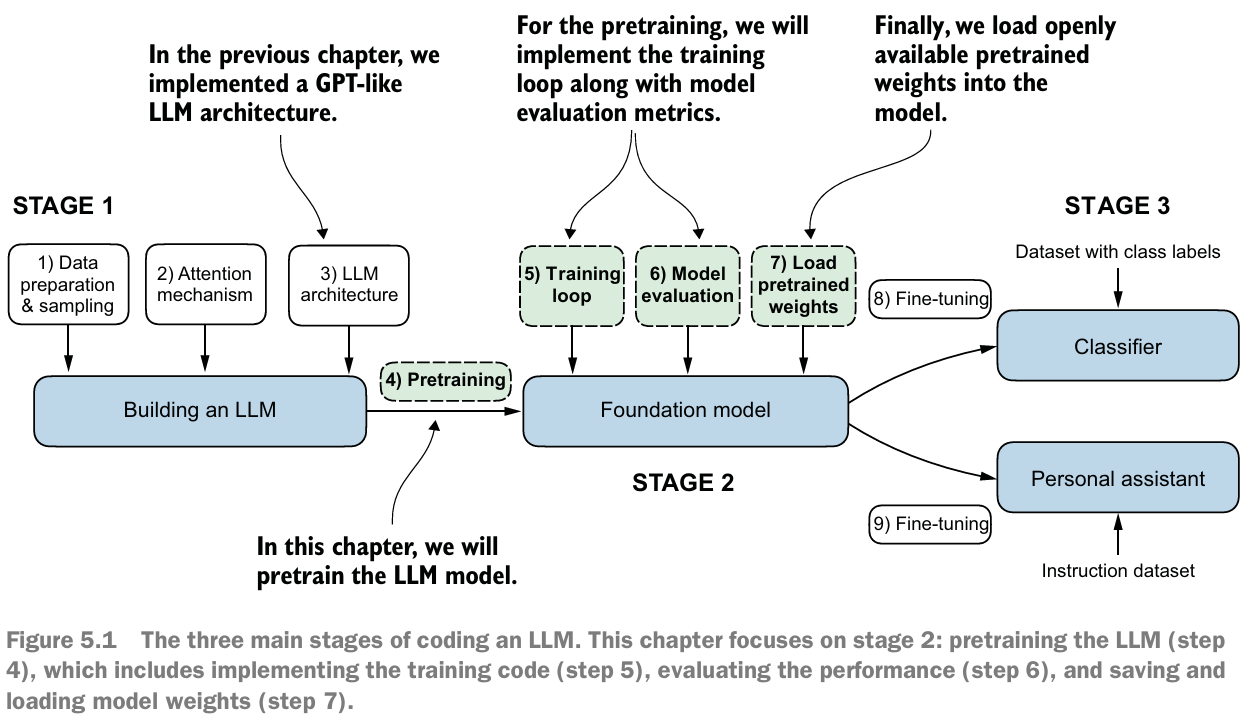

---

$\large \textbf{Parametros de Peso}$

No contexto de LLMs e outros modelos de aprendizado profundo, ***pesos*** referem-se aos parâmetros treináveis ​​que o processo de aprendizado ajusta. Esses pesos também são conhecidos como ***parâmetros de peso*** ou simplesmente ***parâmetros***. Em frameworks como o PyTorch, esses pesos são armazenados em camadas lineares; nós os usamos para implementar o módulo de atenção multi-cabeça no capítulo 3 e o `GPTModel` no capítulo 4. Após inicializar uma camada (`new_layer = torch.nn.Linear(...)`), podemos acessar seus pesos por meio do atributo `.weight`, `new_layer.weight`. Além disso, por conveniência, o PyTorch permite acesso direto a todos os parâmetros treináveis ​​de um modelo, incluindo pesos e vieses, por meio do método `model.parameters()`, que usaremos posteriormente ao implementar o treinamento do modelo.

---

## **1 - Avaliando Modelos de Texto Generativos**

Após recapitular brevemente a geração de texto do Capítulo 4, configuraremos nosso LLM para geração de texto e, em seguida, discutiremos maneiras básicas de avaliar a qualidade do texto gerado. Em seguida, calcularemos as perdas de treinamento e validação. A Figura 5.2 mostra os tópicos abordados neste capítulo, com as três primeiras etapas destacadas.

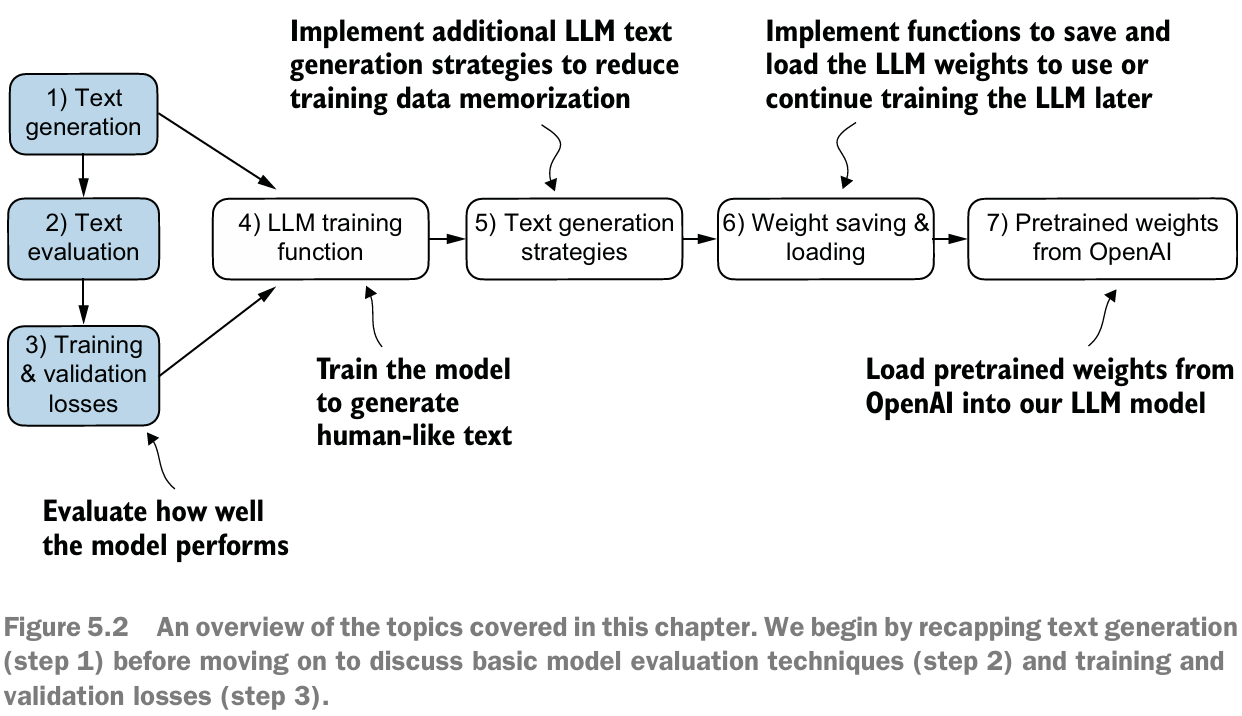

### **1.1 - Usando GPT para Gerar Texto**

Vamos configurar o LLM e recapitular brevemente o processo de geração de texto que implementamos no capítulo 4. Começamos inicializando o modelo GPT, que posteriormente avaliaremos e treinaremos usando a classe `GPTModel` e o dicionário `GPT_CONFIG_124M` (ver capítulo 4):

In [ ]:
# Precisamos baixar o pacote abaixo, ele permite usar funções dos capítulos anteriores
# A descrição desse pacote está no link abaixo
# https://github.com/rasbt/LLMs-from-scratch/tree/main/pkg/llms_from_scratch
!pip install llms-from-scratch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.3/83.3 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 108.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 84.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 76.8 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [ ]:
# Importa a biblioteca principal do PyTorch.
# PyTorch é um framework de aprendizado de máquina de código aberto
# que é amplamente utilizado para construir e treinar redes neurais,
# incluindo modelos de linguagem grandes (LLMs).
import torch

# Importa a classe GPTModel do módulo ch04 dentro do pacote llms_from_scratch.
# Este pacote contém implementações de modelos de linguagem do zero,
# como o nome sugere. A classe GPTModel provavelmente contém a arquitetura
# do modelo GPT que você está usando.
from llms_from_scratch.ch04 import GPTModel

In [ ]:
# Define um dicionário chamado GPT_CONFIG_124M que armazena os parâmetros de configuração
# para um modelo GPT específico, o modelo de 124M (milhões de parâmetros).
GPT_CONFIG_124M = {
   # vocab_size: Tamanho do vocabulário. Representa o número total de tokens únicos
   # que o modelo pode entender e gerar. 50257 é o tamanho do vocabulário do GPT-2.
   "vocab_size": 50257,
   # context_length: Comprimento máximo da sequência de entrada (e saída) que o modelo
   # pode processar de uma vez. Limita quantos tokens o modelo considera ao gerar o próximo token.
   "context_length": 256,
   # emb_dim: Dimensão do embedding (ou dimensão do modelo). É o tamanho dos vetores
   # que representam os tokens e as informações contextuais ao longo das camadas do modelo.
   # Um valor maior geralmente permite que o modelo capture mais informações.
   "emb_dim": 768,
   # n_heads: Número de cabeças de atenção no mecanismo de atenção multi-cabeça.
   # Múltiplas cabeças permitem que o modelo preste atenção a diferentes partes da sequência
   # de entrada simultaneamente.
   "n_heads": 12,
   # n_layers: Número de camadas (blocos de Transformer) no modelo. Cada camada processa
   # a representação da sequência e a aprimora. Mais camadas geralmente aumentam a capacidade do modelo.
   "n_layers": 12,
   # drop_rate: Taxa de dropout. É a probabilidade de um neurônio ser "desativado"
   # aleatoriamente durante o treinamento para evitar overfitting.
   "drop_rate": 0.1,
   # qkv_bias: Um booleano que indica se os vieses (bias) são usados nas projeções
   # de Query (Consulta), Key (Chave) e Value (Valor) dentro do mecanismo de atenção.
   "qkv_bias": False
}

# Define a semente para o gerador de números aleatórios do PyTorch.
# Isso garante que as inicializações de peso e outras operações aleatórias
# sejam reproduzíveis. Se você executar o código com a mesma semente,
# obterá os mesmos resultados.
torch.manual_seed(123)

# Inicializa uma instância da classe GPTModel usando as configurações definidas
# no dicionário GPT_CONFIG_124M. Isso cria a arquitetura do modelo com os
# parâmetros especificados, mas ainda sem treinamento.
model = GPTModel(GPT_CONFIG_124M)

# Coloca o modelo no modo de avaliação. Isso desativa funcionalidades como dropout
# e normalização em lote (batch normalization) que são usadas apenas durante o treinamento.
# É crucial chamar model.eval() antes de usar o modelo para inferência (geração de texto)
# para obter resultados consistentes.
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_resid): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=76

Considerando o dicionário `GPT_CONFIG_124M`, o único ajuste que fizemos em comparação com o capítulo anterior foi a redução do comprimento do contexto (`context_length`) para 256 tokens. Essa modificação reduz as demandas computacionais do treinamento do modelo, possibilitando a execução do treinamento em um laptop padrão.

Originalmente, o modelo GPT-2 com 124 milhões de parâmetros foi configurado para lidar com até 1.024 tokens. Após o processo de treinamento, atualizaremos a configuração do tamanho do contexto e carregaremos os pesos pré-treinados para funcionar com um modelo configurado para um comprimento de contexto de 1.024 tokens.

Usando a instância `GPTModel`, adotamos a função `generate_text_simple` do
capítulo 4 e introduzimos duas funções úteis: `text_to_token_ids` e `token_ids_to_text`. Essas funções facilitam a conversão entre representações de texto e token, uma técnica que utilizaremos ao longo deste capítulo.

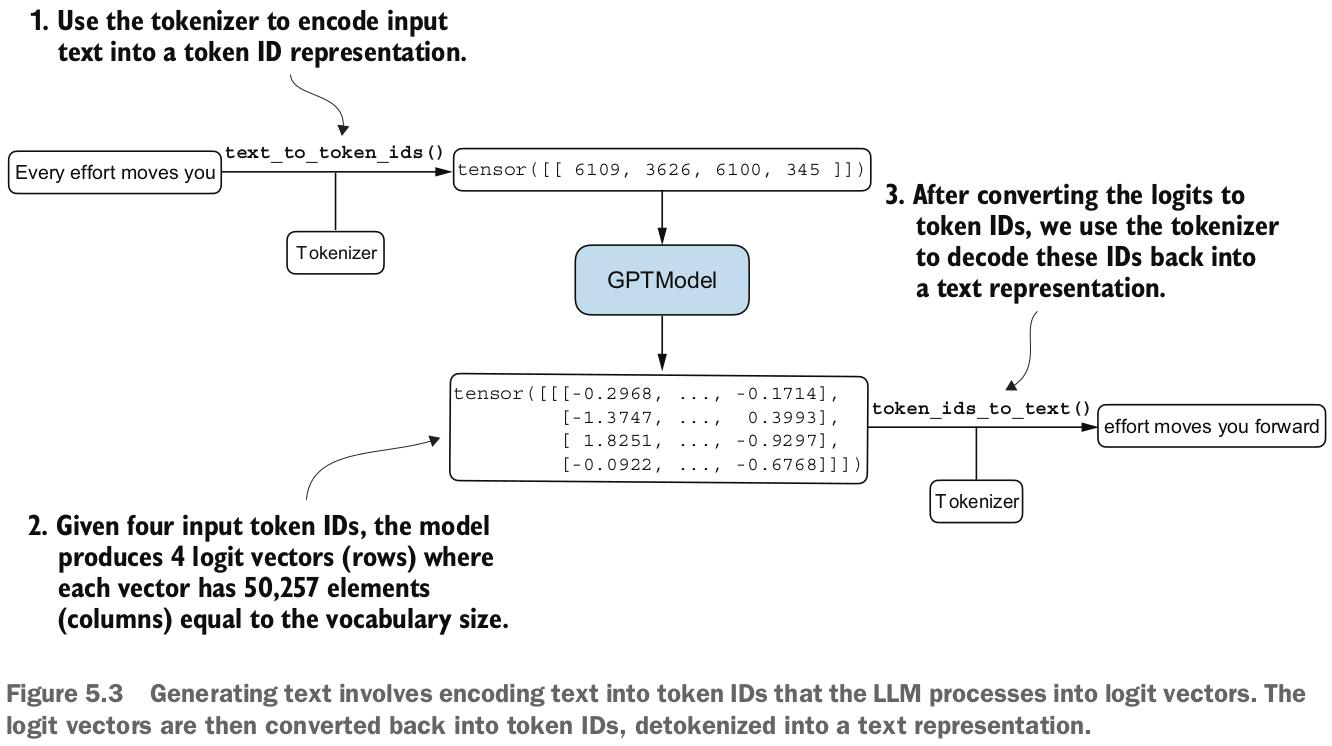

A Figura 5.3 ilustra um processo de geração de texto em três etapas usando um modelo GPT. Primeiro, o tokenizador converte o texto de entrada em uma série de IDs de token (consulte o Capítulo 2). Segundo, o modelo recebe esses IDs de token e gera os logits correspondentes, que são vetores que representam a distribuição de probabilidade para cada token no vocabulário (consulte o Capítulo 4). Terceiro, esses logits são convertidos novamente em IDs de token, que o tokenizador decodifica em texto legível por humanos, completando o ciclo da entrada textual para a saída textual.

Podemos implementar o processo de geração de texto, conforme mostrado na listagem a seguir.

In [ ]:
# Importa a biblioteca tiktoken, que é um tokenizador rápido desenvolvido pela OpenAI.
# Tokenizadores são essenciais para converter texto em sequências de números (tokens)
# que os modelos de linguagem podem processar, e vice-versa.
import tiktoken

# Importa a função generate_text_simple do módulo chapter04.
# Presumivelmente, esta função contém a lógica para gerar texto usando o modelo GPT,
# tomando como entrada o modelo, os tokens de início e outros parâmetros.
from llms_from_scratch.ch04 import generate_text_simple

# Define uma função auxiliar para converter texto em IDs de token.
# Esta função pega uma string de texto e um objeto tokenizer como entrada.
def text_to_token_ids(text, tokenizer):
    # Usa o método encode do tokenizer para converter a string de texto em uma lista de IDs de token.
    # allowed_special={'<|endoftext|>'} permite que o tokenizador inclua o token especial <|endoftext|>
    # se ele estiver presente no texto.
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    # Converte a lista de IDs de token em um tensor PyTorch.
    # unsqueeze(0) adiciona uma dimensão extra no início do tensor. Isso é comum
    # porque os modelos PyTorch geralmente esperam entradas em lote (batch),
    # mesmo que tenhamos apenas uma única sequência aqui. A forma resultante será (1, sequência_de_tokens).
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)
    # Retorna o tensor contendo os IDs de token.
    return encoded_tensor

# Define uma função auxiliar para converter IDs de token de volta para texto.
# Esta função pega um tensor PyTorch de IDs de token e um objeto tokenizer como entrada.
def token_ids_to_text(token_ids, tokenizer):
    # Remove a dimensão extra que foi adicionada anteriormente com unsqueeze(0).
    # Isso "achata" o tensor de volta para uma única dimensão contendo apenas os IDs de token.
    flat = token_ids.squeeze(0)
    # Converte o tensor PyTorch para uma lista Python usando tolist().
    # Em seguida, usa o método decode do tokenizer para converter a lista de IDs de token de volta para uma string de texto legível.
    return tokenizer.decode(flat.tolist())

# Define a string de contexto inicial a partir da qual o modelo começará a gerar texto.
start_context = "Every effort moves you"

# Obtém um tokenizador específico ("gpt2") usando tiktoken.
# Este tokenizador é compatível com o modelo GPT-2.
tokenizer = tiktoken.get_encoding("gpt2")

# Chama a função generate_text_simple para gerar texto.
token_ids = generate_text_simple(
            # Passa a instância do modelo GPT inicializado anteriormente.
            model=model,
            # Converte o texto inicial (start_context) em IDs de token usando a função auxiliar text_to_token_ids.
            # Este tensor de IDs de token serve como o prompt para o modelo.
            idx=text_to_token_ids(start_context, tokenizer),
            # Define o número máximo de novos tokens que o modelo deve gerar após o prompt inicial.
            max_new_tokens=10,
            # Passa o tamanho do contexto configurado para o modelo. Isso garante que a geração
            # de texto respeite o comprimento máximo da sequência que o modelo pode lidar.
            context_size=GPT_CONFIG_124M["context_length"]
)

# Imprime o texto de saída.
# A função token_ids_to_text é usada para converter os IDs de token gerados pelo modelo de volta para uma string de texto.
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


Claramente, o modelo ainda não está produzindo texto coerente porque não passou por treinamento. Para definir o que torna um texto **"coerente"** ou **"de alta qualidade"**, precisamos implementar um método numérico para avaliar o conteúdo gerado. Essa abordagem nos permitirá monitorar e aprimorar o desempenho do modelo durante todo o processo de treinamento.

Em seguida, calcularemos uma ***métrica de perda*** para os resultados gerados. Essa perda serve como um indicador de progresso e sucesso do treinamento. Além disso, em capítulos posteriores, quando refinarmos nosso LLM, revisaremos metodologias adicionais para avaliar a qualidade do modelo.

### **1.2 - Calculando a Perda de Geração de Texto**

A seguir, vamos explorar técnicas para avaliar numericamente a qualidade do texto gerado durante o treinamento, calculando uma ***perda na geração de texto***. Abordaremos este tópico passo a passo com um exemplo prático para tornar os conceitos claros e aplicáveis, começando com uma breve recapitulação de como os dados são carregados e como o texto é gerado por meio da função `generate_text_simple`.

A Figura 5.4 ilustra o fluxo geral do texto de entrada para o texto gerado pelo LLM usando um procedimento de cinco etapas. Este processo de geração de texto mostra o que a função `generate_text_simple` faz internamente. Precisamos executar essas mesmas etapas iniciais antes de podermos calcular uma perda que mede a qualidade do texto gerado posteriormente nesta seção.

A Figura 5.4 descreve o processo de geração de texto com um pequeno vocabulário de sete tokens para caber esta imagem em uma única página. No entanto, nosso `GPTModel` trabalha com um vocabulário muito maior, composto por 50.257 palavras; portanto, os IDs dos tokens no código a seguir variarão
de 0 a 50.256, em vez de 0 a 6.

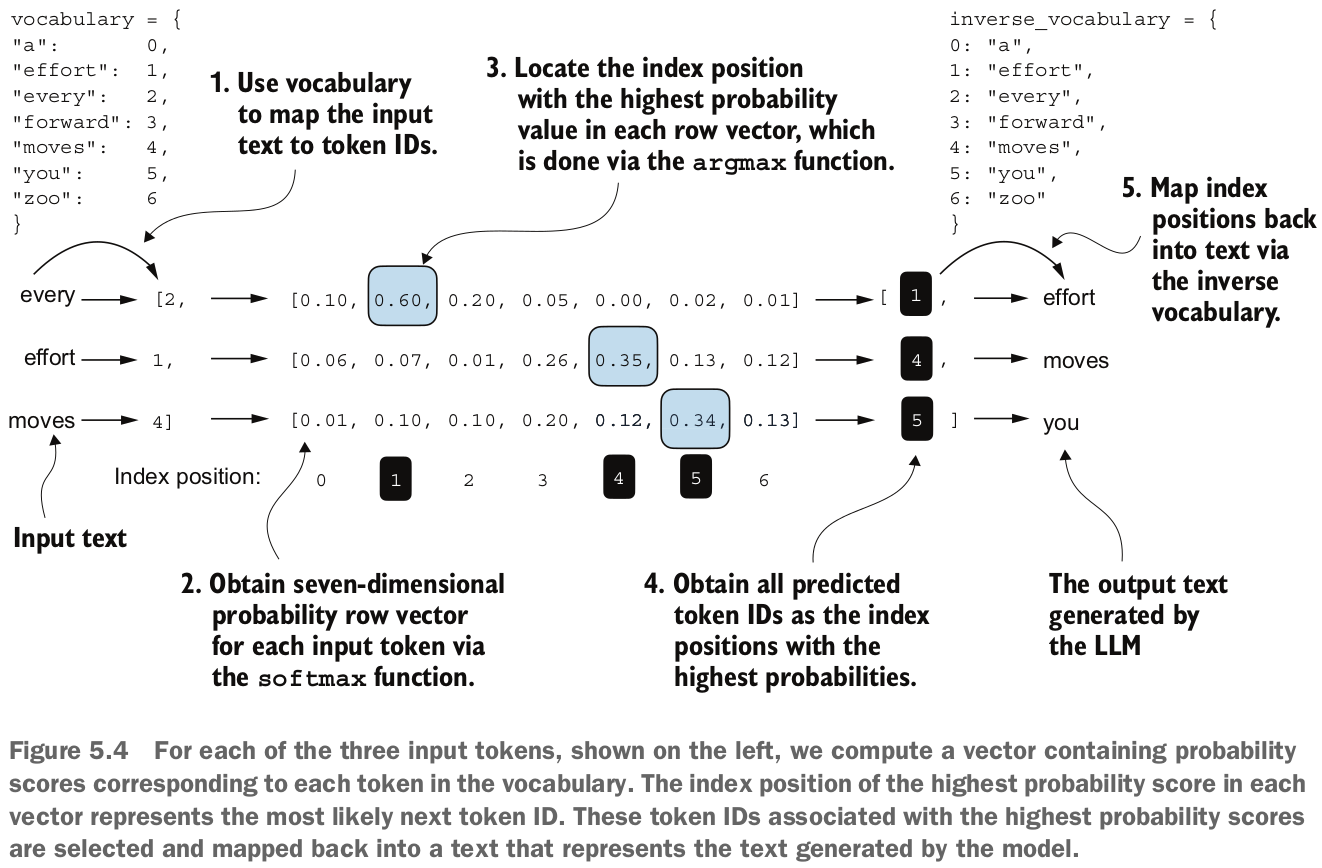

Além disso, a Figura 5.4 mostra apenas um único exemplo de texto (`"every effort moves"`) para simplificar. No exemplo prático de código a seguir, que implementa as etapas da figura, trabalharemos com dois exemplos de entrada para o modelo GPT (`"every effort moves"` e `"I really like"`).

Considere estes dois exemplos de entrada, que já foram mapeados para IDs de token (Figura 5.4, etapa 1):

In [ ]:
# Cria um tensor PyTorch chamado `inputs`.
# Um tensor é a estrutura de dados fundamental no PyTorch, similar a arrays NumPy.
# Ele contém os IDs de token que representam as sequências de texto de entrada para o modelo GPT.
# O tensor é bidimensional:
# - A primeira dimensão representa o número de exemplos (aqui, 2 exemplos).
# - A segunda dimensão representa a sequência de tokens para cada exemplo (aqui, 3 tokens por sequência).
inputs = torch.tensor(
    [
        [16833, 3626, 6100], # Primeira sequência: IDs de token para "every effort moves".
                             # Cada número inteiro é o ID único atribuído a uma palavra ou subpalavra específica pelo tokenizador (como o tiktoken).
        [40, 1107, 588]      # Segunda sequência: IDs de token para "I really like".
                             # Da mesma forma, cada número representa um token.
    ]
)

Correspondendo a essas entradas, os alvos contêm os IDs de token que queremos que o modelo produza:

In [ ]:
# Cria um tensor PyTorch chamado `targets`.
# Este tensor contém os IDs de token que o modelo deve prever como o próximo token na sequência,
# com base nas entradas correspondentes no tensor `inputs`.
# Assim como o tensor `inputs`, ele é bidimensional:
# - A primeira dimensão representa o número de exemplos (aqui, 2 exemplos), correspondendo aos exemplos em `inputs`.
# - A segunda dimensão representa a sequência de tokens alvo para cada exemplo (aqui, 3 tokens por sequência),
#   correspondendo aos tokens que seguem as sequências de entrada em `inputs`.
targets = torch.tensor([[3626, 6100, 345 ],  # Para a entrada "every effort moves", os alvos são os IDs para " effort moves you".
                        [1107, 588, 11311]]) # Para a entrada "I really like", os alvos são os IDs para " really like chocolate".
                                             # Cada número inteiro é o ID único atribuído a uma palavra ou subpalavra pelo tokenizador.

Observe que os alvos são as entradas, mas deslocados uma posição para a frente, um conceito que abordamos no capítulo 2, durante a implementação do carregador de dados. Essa estratégia de deslocamento é crucial para ensinar o modelo a prever o próximo token em uma sequência.

Agora, alimentamos o modelo com as entradas para calcular os vetores logits para os dois exemplos de entrada, cada um composto por três tokens. Em seguida, aplicamos a função `softmax` para transformar esses logits em pontuações de probabilidade (`probas`; figura 5.4, etapa 2):

In [ ]:
# O bloco `with torch.no_grad():` desativa o cálculo de gradientes.
# Durante a inferência (geração de texto) ou avaliação, não precisamos calcular
# gradientes para otimizar os pesos do modelo, pois isso é feito apenas durante o treinamento.
# Desativar o cálculo de gradientes reduz o uso de memória e acelera a execução.
with torch.no_grad():
    # Passa o tensor `inputs` (contendo os IDs de token das sequências de entrada)
    # para o modelo GPT. O modelo processa esses IDs através de suas camadas
    # (embeddings, atenção multi-cabeça, etc.) e retorna os logits.
    # Logits são as pontuações brutas de saída do modelo, uma para cada token
    # possível no vocabulário para cada posição na sequência de saída.
    logits = model(inputs)

# Aplica a função softmax aos logits.
# softmax é uma função matemática que converte um vetor de números reais (logits)
# em uma distribuição de probabilidade. A soma de todos os elementos na saída
# do softmax para uma determinada posição de token será 1.
# dim=-1 especifica que a operação softmax deve ser aplicada ao longo da última dimensão do tensor `logits`,
# que corresponde à dimensão do vocabulário. Para cada posição de token em cada exemplo no lote,
# o softmax transforma os logits em probabilidades sobre todos os tokens possíveis do vocabulário.
probas = torch.softmax(logits, dim=-1)

# Imprime a forma (shape) do tensor `probas`.
# A forma do tensor indica suas dimensões.
# Para este caso, `probas` terá a forma (número_de_exemplos, comprimento_da_sequência_de_entrada, tamanho_do_vocabulário).
# Por exemplo, se inputs tinha forma (2, 3) e o tamanho do vocabulário é 50257, a forma de probas será (2, 3, 50257).
# Isso significa que para cada um dos 2 exemplos, e para cada uma das 3 posições de token,
# temos um vetor de 50257 probabilidades, representando a probabilidade de cada token do vocabulário
# ser o próximo token na sequência.
print(probas.shape)

torch.Size([2, 3, 50257])


O primeiro número, 2, corresponde aos dois exemplos (linhas) nas entradas, também conhecido como tamanho do lote. O segundo número, 3, corresponde ao número de tokens em cada entrada (linha). Por fim, o último número corresponde à dimensionalidade de incorporação, que é determinada pelo tamanho do vocabulário. Após a conversão de logits para probabilidades por meio da função `softmax`, a função `generate_text_simple` converte as pontuações de probabilidade resultantes novamente em texto (Figura 5.4, etapas 3 a 5).

Podemos concluir as etapas 3 e 4 aplicando a função `argmax` às pontuações de probabilidade para obter os IDs de token correspondentes:

In [ ]:
# Aplica a função torch.argmax ao tensor `probas`.
# torch.argmax retorna o índice do maior valor ao longo de uma dimensão especificada.
# Neste caso, estamos aplicando-o ao tensor `probas`, que contém as probabilidades
# de cada token do vocabulário ser o próximo na sequência.
token_ids = torch.argmax(
    probas,
    dim=-1,     # dim=-1 significa que a operação é aplicada ao longo da última dimensão,
                # que é a dimensão do vocabulário (50257 probabilidades para cada posição).
                # Isso encontra o token com a maior probabilidade para cada posição na sequência.
    keepdim=True # keepdim=True garante que a dimensão ao longo da qual o argmax foi calculado
                 # (a última dimensão) seja mantida, mas com tamanho 1.
                 # Se keepdim fosse False (o padrão), a última dimensão seria removida.
                 # Manter a dimensão pode ser útil para operações subsequentes que esperam
                 # um certo número de dimensões.
)

# Imprime o tensor resultante `token_ids`.
# Este tensor agora contém os IDs dos tokens previstos pelo modelo para cada posição
# e cada exemplo no lote. A forma será (número_de_exemplos, comprimento_da_sequência_de_entrada, 1),
# por exemplo, (2, 3, 1). Cada número inteiro no tensor é o ID do token mais provável
# previsto para aquela posição específica.
print("Token IDs:\n", token_ids)

Token IDs:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


Considerando que temos dois lotes de entrada, cada um contendo três tokens, a aplicação da função argmax às pontuações de probabilidade (Figura 5.4, etapa 3) produz dois conjuntos de saídas, cada um com três IDs de token previstos. Por fim, a etapa 5 converte os IDs de token novamente em texto. Quando decodificamos esses tokens, descobrimos que esses tokens de saída são bastante diferentes dos tokens de destino que queremos que o modelo gere:

In [ ]:
# Imprime o texto correspondente aos IDs de token do primeiro exemplo no tensor `targets`.
# `targets[0]` seleciona a primeira linha (o primeiro exemplo) do tensor `targets`.
# A função `token_ids_to_text` é usada para converter essa sequência de IDs de token de volta para uma string legível.
# O f-string `f"Targets batch 1: ..."` formata a saída para incluir um rótulo claro.
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")

# Imprime o texto correspondente aos IDs de token previstos pelo modelo para o primeiro exemplo (`token_ids[0]`).
# `token_ids[0]` seleciona a primeira linha (o primeiro exemplo) do tensor `token_ids` (que contém os IDs previstos pelo modelo).
# `.flatten()` é usado para achatar o tensor de volta para uma única dimensão, pois `token_ids` foi criado com `keepdim=True`,
# resultando em uma forma (1, sequência_de_tokens, 1). `flatten()` remove a dimensão extra.
# A função `token_ids_to_text` converte essa sequência de IDs de token previstos de volta para texto.
# O f-string formata a saída.
print(f"Outputs batch 1:"
      f" {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets batch 1:  effort moves you
Outputs batch 1:  Armed heNetflix


O modelo produz texto aleatório diferente do texto-alvo porque ainda não foi treinado. Agora, queremos avaliar o desempenho do texto gerado pelo modelo numericamente por meio de uma perda (Figura 5.5). Isso não só é útil para medir a qualidade do texto gerado, como também é um bloco de construção para a implementação da função de treinamento, que usaremos para atualizar o peso do modelo e aprimorar o texto gerado.

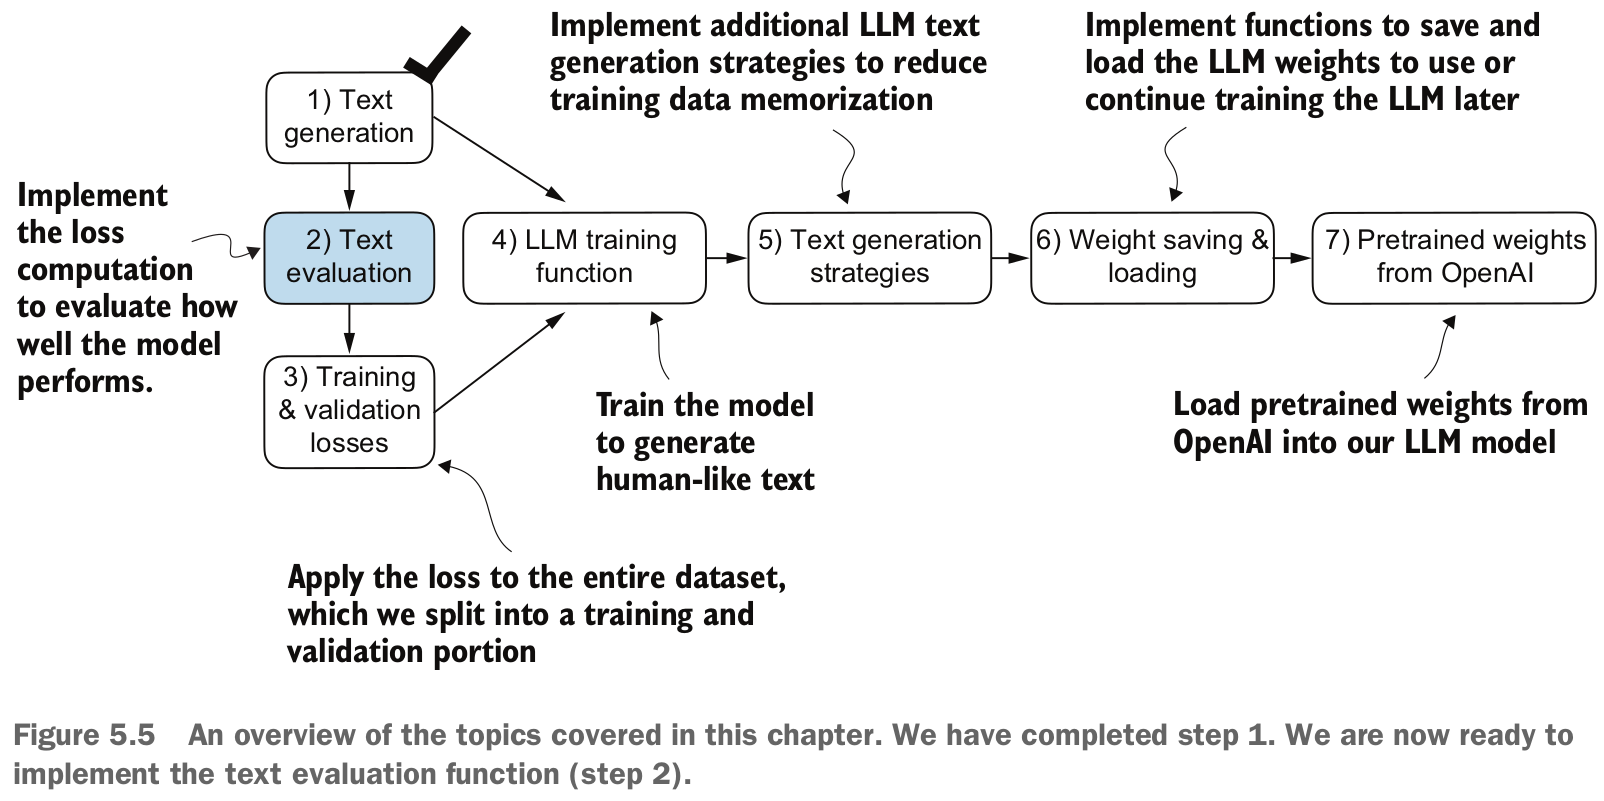

Parte do processo de avaliação de texto que implementamos, como mostrado na figura 5.5, é medir "quão distantes" os tokens gerados estão das previsões corretas (alvos). A função de treinamento que implementaremos posteriormente usará essas informações para ajustar os pesos do modelo e gerar um texto mais semelhante (ou, idealmente, que corresponda) ao texto de destino.

O treinamento do modelo visa aumentar a probabilidade softmax nas posições de índice
correspondentes aos IDs corretos dos tokens de destino, conforme ilustrado na figura 5.6. Essa probabilidade softmax também é usada na métrica de avaliação que implementaremos a seguir para avaliar numericamente as saídas geradas pelo modelo: quanto maior a probabilidade nas posições corretas, melhor.

Lembre-se de que a figura 5.6 exibe as probabilidades softmax para um vocabulário compacto de sete tokens, permitindo que tudo caiba em uma única figura. Isso implica que os valores aleatórios iniciais
ficarão em torno de $\frac{1}{7}$, o que equivale a aproximadamente 0,14. No entanto, o vocabulário que estamos usando para nosso modelo GPT-2 tem 50.257 tokens, então a maioria das probabilidades iniciais ficará em torno de 0,00002 $\left(\frac{1}{50.257} \right)$.

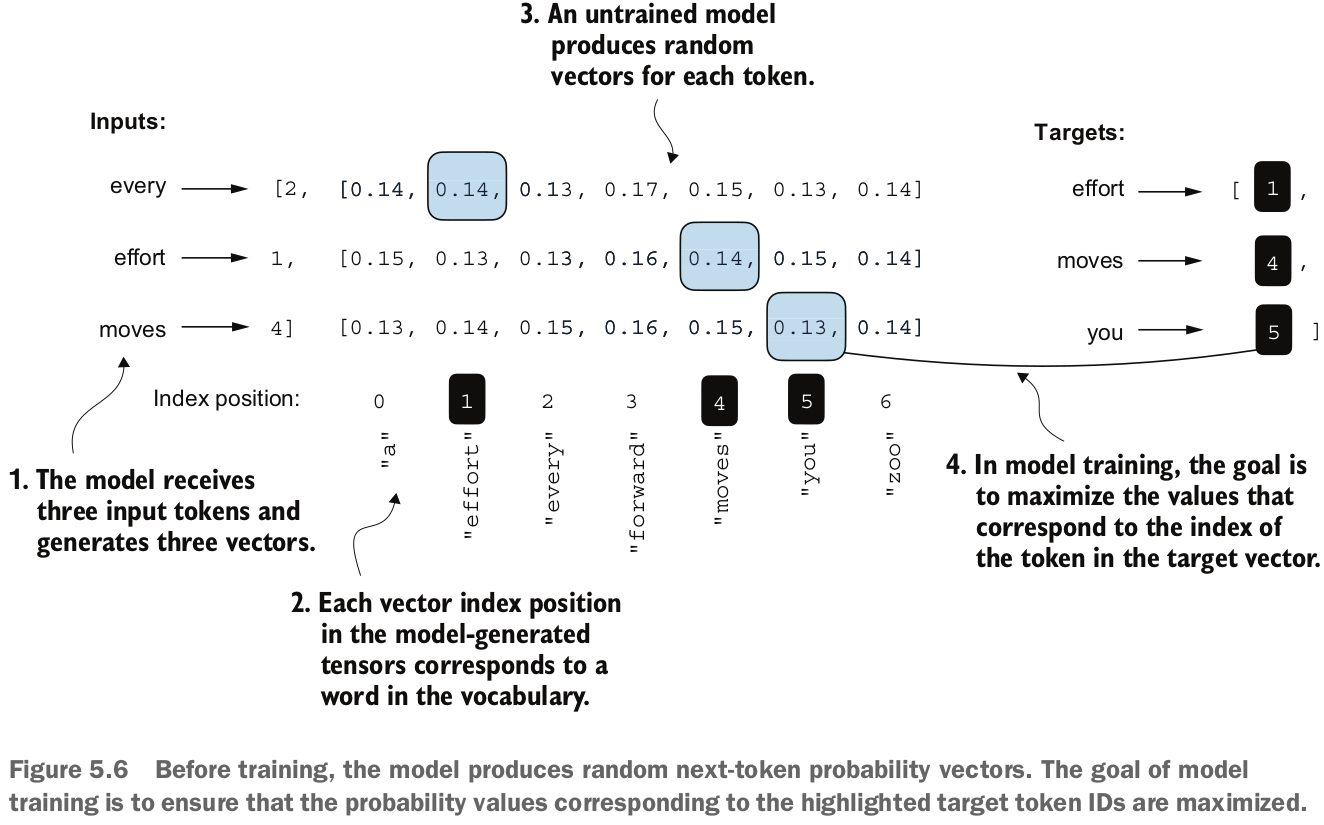

Para cada um dos dois textos de entrada, podemos imprimir as pontuações de probabilidade softmax iniciais correspondentes aos tokens de destino usando o seguinte código:

In [ ]:
# Define um índice para selecionar o primeiro exemplo do lote.
text_idx = 0
# Seleciona as probabilidades correspondentes aos tokens de destino para o primeiro exemplo.
# probas[text_idx, ...] acessa o primeiro exemplo (linha) no tensor `probas`.
# [0, 1, 2] são os índices das posições dos tokens na sequência para as quais queremos as probabilidades.
# targets[text_idx] seleciona os IDs dos tokens de destino para o primeiro exemplo.
# A indexação avançada probas[text_idx, [0, 1, 2], targets[text_idx]] seleciona
# as probabilidades nas posições especificadas ([0, 1, 2]) e nos índices de vocabulário
# especificados pelos IDs dos tokens de destino para o primeiro exemplo.
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
# Imprime as probabilidades selecionadas para o primeiro texto.
print("Text 1:", target_probas_1)

# Define um índice para selecionar o segundo exemplo do lote.
text_idx = 1
# Seleciona as probabilidades correspondentes aos tokens de destino para o segundo exemplo.
# A lógica é a mesma que para o primeiro exemplo, mas usando o índice text_idx = 1.
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
# Imprime as probabilidades selecionadas para o segundo texto.
print("Text 2:", target_probas_2)

Text 1: tensor([7.4540e-05, 3.1061e-05, 1.1563e-05])
Text 2: tensor([1.0337e-05, 5.6776e-05, 4.7559e-06])


O objetivo de treinar um LLM é maximizar a probabilidade do token correto, o que envolve aumentar sua probabilidade em relação a outros tokens. Dessa forma, garantimos que o LLM escolha consistentemente o token alvo — essencialmente a próxima palavra na frase — como o próximo token que ele gera.

---

$\large \textbf{Backpropagation}$

Como maximizamos os valores de probabilidade softmax correspondentes aos tokens-alvo? O panorama geral é que atualizamos os pesos do modelo para que ele produza valores mais altos para os respectivos IDs de token que queremos gerar. A atualização dos pesos é feita por meio de um processo chamado `Retropropagação (Backpropagation)`, uma técnica padrão para o treinamento de redes neurais profundas (consulte as seções A.3 a A.7 no apêndice A para obter mais detalhes sobre retropropagação e treinamento de modelos).

A retropropagação requer uma função de perda, que calcula a diferença entre
a saída prevista do modelo (aqui, as probabilidades correspondentes aos IDs
de token-alvo) e a saída desejada real. Essa função de perda mede a distância entre as previsões do modelo e os valores-alvo.

---

Em seguida, calcularemos a perda para as pontuações de probabilidade dos dois lotes de exemplo, `target_probas_1` e `target_probas_2`. As principais etapas são ilustradas na Figura 5.7. Como já aplicamos as etapas 1 a 3 para obter `target_probas_1` e `target_probas_2`, prosseguimos para a etapa 4, aplicando o ***logaritmo*** às pontuações de probabilidade:

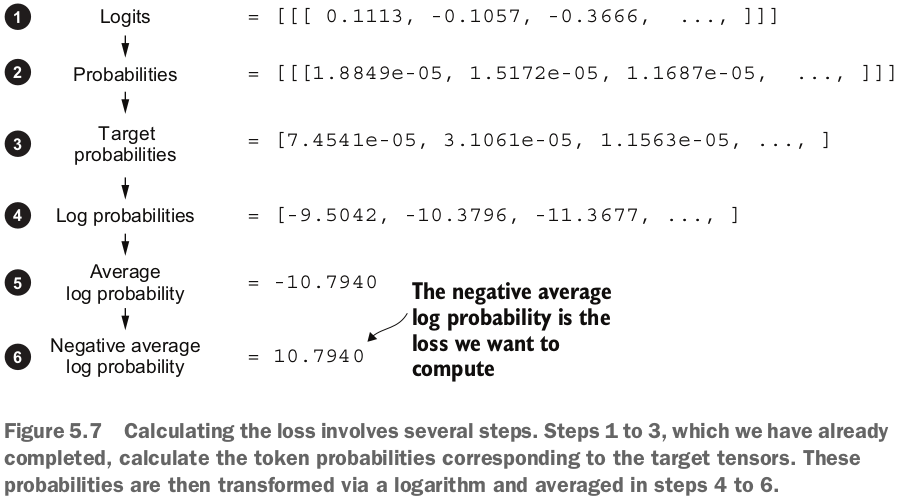

In [ ]:
# Concatena os tensores `target_probas_1` e `target_probas_2` em um único tensor.
# torch.cat() junta uma sequência de tensores ao longo de uma dimensão existente.
# Por padrão, concatena ao longo da primeira dimensão (dim=0).
# O tensor resultante `target_probas_1` e `target_probas_2` eram tensores unidimensionais,
# então a concatenação resultará em um único tensor unidimensional contendo
# todos os elementos de ambos os tensores originais.
concatenated_probas = torch.cat((target_probas_1, target_probas_2))

# Aplica a função de logaritmo natural (ln) a cada elemento do tensor `concatenated_probas`.
# torch.log() calcula o logaritmo natural de cada elemento do tensor de entrada.
# O logaritmo das probabilidades é frequentemente usado em funções de perda,
# como a entropia cruzada, porque transforma a multiplicação de probabilidades
# em uma soma de logaritmos, o que é computacionalmente mais estável e fácil de otimizar.
log_probas = torch.log(concatenated_probas)

# Imprime o tensor resultante `log_probas`.
# Este tensor contém os valores de logaritmo natural das probabilidades
# dos tokens de destino para ambos os exemplos concatenados.
# Valores de logaritmo mais próximos de 0 (ou seja, menos negativos) indicam probabilidades mais altas,
# o que é o objetivo do treinamento do modelo.
print(log_probas)

tensor([ -9.5042, -10.3796, -11.3677, -11.4798,  -9.7764, -12.2561])


Trabalhar com logaritmos de pontuações de probabilidade é mais fácil em otimização matemática do que lidar com as pontuações diretamente. Este tópico está fora do escopo deste livro, mas eu o detalhei mais em uma aula, que pode ser encontrada no apêndice B.

Em seguida, combinamos essas probabilidades de logaritmo em uma única pontuação, calculando a média (etapa 5 na figura 5.7):

In [ ]:
# Calcula a média dos valores no tensor `log_probas`.
# torch.mean() calcula a média de todos os elementos no tensor de entrada.
# A média dos logaritmos das probabilidades dos tokens de destino está relacionada
# à função de perda de entropia cruzada (Cross-Entropy Loss), que é comumente
# usada para treinar modelos de classificação, incluindo modelos de linguagem.
# Um valor médio de logaritmos mais próximo de 0 (ou seja, menos negativo) indica
# que o modelo está atribuindo probabilidades mais altas aos tokens corretos,
# o que significa um desempenho melhor.
avg_log_probas = torch.mean(log_probas)

# Imprime o valor da média dos logaritmos das probabilidades.
# Este valor representa a "perda" do modelo para este lote específico de dados.
# O objetivo do treinamento é minimizar essa perda, ou seja, tornar esse valor
# o menos negativo possível (o mais próximo de 0).
print(avg_log_probas)

tensor(-10.7940)


O objetivo é aproximar a probabilidade logarítmica média o máximo possível de 0, atualizando os pesos do modelo como parte do processo de treinamento. No entanto, em aprendizado profundo, a prática comum não é elevar a probabilidade logarítmica média a 0, mas sim reduzir a probabilidade logarítmica média negativa a 0. A probabilidade logarítmica média negativa é simplesmente a probabilidade logarítmica média multiplicada por -1, o que corresponde à etapa 6 na Figura 5.7:

In [ ]:
# Calcula a média negativa dos logaritmos das probabilidades.
# Isso é feito multiplicando a média dos logaritmos por -1.
# Na prática do aprendizado profundo, é comum usar a "perda logarítmica negativa"
# (Negative Log Likelihood) como função de perda, que é essencialmente o negativo
# da média dos logaritmos das probabilidades atribuídas às classes (tokens) corretas.
# Minimizar a perda logarítmica negativa é equivalente a maximizar a probabilidade
# dos tokens de destino.
neg_avg_log_probas = avg_log_probas * -1

# Imprime o valor da média negativa dos logaritmos das probabilidades.
# Este valor representa a perda logarítmica negativa para os dados.
# O objetivo do treinamento do modelo é minimizar este valor. Quanto menor o valor,
# melhor o modelo está em prever os tokens de destino.
print(neg_avg_log_probas)

tensor(10.7940)


Isso imprime `tensor(10.7940)`. Em aprendizado profundo, o termo para transformar esse valor negativo, –10.7940, em 10.7940, é conhecido como ***perda de entropia cruzada***. O PyTorch é útil aqui, pois já possui uma função `cross_entropy` integrada que cuida de todas essas seis etapas da Figura 5.7 para nós.

---

$\large \textbf{Perda de Entropia Cruzada (Cross Entropy Loss)}$

Em sua essência, a perda de entropia cruzada é uma medida popular em aprendizado de máquina e aprendizado profundo que mede a diferença entre duas distribuições de probabilidade — normalmente, a distribuição real de rótulos (aqui, tokens em um conjunto de dados) e a distribuição prevista de um modelo (por exemplo, as probabilidades de token geradas por um LLM).

No contexto de aprendizado de máquina e, especificamente, em frameworks como o PyTorch, a função `cross_entropy` calcula essa medida para resultados discretos, que é
semelhante à probabilidade logarítmica média negativa dos tokens-alvo, dadas as probabilidades dos tokens gerados pelo modelo, tornando os termos “entropia cruzada” e “probabilidade logarítmica média negativa” relacionados e frequentemente usados ​​de forma intercambiável na prática.

---

Antes de aplicarmos a função `cross_entropy`, vamos relembrar brevemente a forma dos logits e tensores de destino:

In [ ]:
# Imprime a forma (shape) do tensor `logits`.
# A forma de um tensor em PyTorch indica suas dimensões e o tamanho de cada dimensão.
# Para os logits de um modelo de linguagem, a forma geralmente é (tamanho_do_lote, comprimento_da_sequência, tamanho_do_vocabulário).
# - tamanho_do_lote: O número de sequências de entrada processadas em paralelo.
# - comprimento_da_sequência: O número de tokens na sequência de entrada.
# - tamanho_do_vocabulário: O número total de tokens possíveis que o modelo pode prever.
# Esta linha mostrará as dimensões do tensor de logits gerado pelo modelo para as entradas fornecidas.
print("Logits shape:", logits.shape)

# Imprime a forma (shape) do tensor `targets`.
# O tensor `targets` contém os IDs dos tokens que o modelo deve prever.
# A forma de `targets` geralmente é (tamanho_do_lote, comprimento_da_sequência).
# - tamanho_do_lote: Corresponde ao número de exemplos no lote, o mesmo que nos logits.
# - comprimento_da_sequência: Corresponde ao número de tokens alvo para cada exemplo.
# Observe que `targets` não tem a dimensão do vocabulário, pois ele apenas armazena o ID do token correto para cada posição,
# e não uma distribuição de probabilidade sobre todo o vocabulário.
# Esta linha mostrará as dimensões do tensor de alvos.
print("Targets shape:", targets.shape)

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])


Como podemos ver, o tensor `logits` tem três dimensões: tamanho do lote, número de tokens e tamanho do vocabulário. O tensor `targets` tem duas dimensões: tamanho do lote e número de tokens.

Para a função de perda `cross_entropy` no PyTorch, queremos nivelar esses tensores combinando-os sobre a dimensão do lote:

In [ ]:
# Achata o tensor `logits`.
# A função `flatten()` achata as dimensões do tensor em uma única dimensão.
# `0` e `1` como argumentos para `flatten()` especificam as dimensões inicial e final (exclusiva)
# a serem achatadas. Neste caso, as dimensões 0 (lote) e 1 (sequência) são achatadas juntas.
# Isso transforma o tensor de forma (tamanho_do_lote, comprimento_da_sequência, tamanho_do_vocabulário)
# para (tamanho_do_lote * comprimento_da_sequência, tamanho_do_vocabulário).
# Isso é feito para preparar os dados para a função de perda, que geralmente espera
# que as previsões sejam achatadas em uma única dimensão para cada classe possível.
logits_flat = logits.flatten(0, 1)

# Achata o tensor `targets`.
# Como `targets` tem forma (tamanho_do_lote, comprimento_da_sequência),
# `flatten()` sem argumentos achata todas as dimensões em uma única dimensão.
# Isso transforma o tensor de forma (tamanho_do_lote, comprimento_da_sequência)
# para (tamanho_do_lote * comprimento_da_sequência).
# O tensor achatado agora contém todos os IDs de token de destino em uma única sequência longa.
targets_flat = targets.flatten()

# Imprime a forma (shape) do tensor achatado `logits_flat`.
# Isso mostrará as novas dimensões do tensor após o achatamento, que deve ser
# (número total de tokens nos lotes, tamanho do vocabulário).
print("Flattened logits:", logits_flat.shape)

# Imprime a forma (shape) do tensor achatado `targets_flat`.
# Isso mostrará a nova dimensão do tensor `targets` após o achatamento, que deve ser
# uma única dimensão contendo o número total de tokens nos lotes.
print("Flattened targets:", targets_flat.shape)

Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])


Lembre-se de que os `targets` são os IDs dos tokens que queremos que o LLM gere, e os `logits` contêm as saídas do modelo sem escala antes de entrarem na função `softmax` para obter as pontuações de probabilidade.

Anteriormente, aplicamos a função `softmax`, selecionamos as pontuações de probabilidade correspondentes aos IDs dos alvos e calculamos as probabilidades logarítmicas médias negativas. A função `cross_entropy` do PyTorch cuidará de todas essas etapas para nós:

In [ ]:
# Calcula a perda de entropia cruzada (Cross-Entropy Loss).
# torch.nn.functional.cross_entropy é uma função conveniente no PyTorch que combina
# as etapas de aplicação do softmax (ou log-softmax) e o cálculo da perda
# logarítmica negativa. É comumente usada para problemas de classificação multi-classe,
# onde queremos medir o quão bem a distribuição de probabilidade prevista pelo modelo
# (derivada dos logits) corresponde à distribuição real (representada pelos targets).
#
# Parâmetros:
# - logits_flat: O tensor de logits achatado. Tem a forma (N, C), onde N é o número total
#   de elementos (tamanho_do_lote * comprimento_da_sequência) e C é o número de classes
#   (tamanho do vocabulário). Estes são os outputs brutos do modelo para cada token.
# - targets_flat: O tensor de alvos achatado. Tem a forma (N,), onde N é o número total
#   de elementos. Cada valor neste tensor é o ID da classe (token) correta para
#   o elemento correspondente nos logits.
#
# A função internamente:
# 1. Aplica log-softmax aos logits para obter log-probabilidades.
# 2. Seleciona as log-probabilidades correspondentes aos IDs dos targets.
# 3. Calcula a média negativa dessas log-probabilidades.
#
# O valor da perda resultante indica a "distância" entre as previsões do modelo e os alvos reais.
# Um valor de perda menor indica que o modelo está atribuindo uma probabilidade maior aos tokens corretos.
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)

# Imprime o valor calculado da perda de entropia cruzada.
# Este é o valor numérico que queremos minimizar durante o treinamento do modelo
# para melhorar seu desempenho na previsão do próximo token na sequência.
print(loss)

tensor(10.7940)


A perda resultante é a mesma que obtivemos anteriormente ao aplicar manualmente as etapas individuais da figura 5.7.

#### **1.2.1 - Derivação detalhada — Entropia cruzada / Negative Log-Likelihood (NLL) usada como perda para LLMs**

Abaixo segue o desenvolvimento passo a passo, em notação matricial, que leva diretamente à implementação Python que você mostrou. Vou trabalhar com um lote (batch) de tamanho $N$ e número de classes (vocab) $C$ — no caso de LLMs, $C$ é o tamanho do vocabulário.


$\large \textbf{1. Notação e objetivo}$

* **Logits**: denotamos por $\mathbf{z}\in\mathbb{R}^{N\times C}$ a matriz de *logits* produzida pelo modelo (cada linha corresponde a um exemplo/timestep e contém $C$ valores, um por classe/token). Elemento $z_{i,j}$ é o logit do exemplo $i$ para a classe $j$.
* **Targets**: denotamos por $t_i\in{0,\dots,C-1}$ o índice da classe correta para o exemplo $i$.
* Queremos uma função de perda escalar por lote: **média da entropia cruzada** entre a distribuição one-hot do alvo e a distribuição predita (softmax dos logits).

---

$\large \textbf{2. Softmax (prever probabilidades a partir dos logits)}$

Por definição, a função *softmax* transforma logits em probabilidades:

$$
\mathrm{softmax}(z)_{j} = \dfrac{e^{z_{j}}}{\sum\limits_{k=1}^C e^{z_{k}}}.
$$

Para uma linha (exemplo) (i) escrevemos:

$$
q_{i,j} \equiv \mathrm{softmax}(\mathbf z_i)*j = \frac{e^{z*{i,j}}}{\sum_{k=1}^C e^{z_{i,k}}}.
$$

Note que a softmax produz uma distribuição de probabilidade (todos valores positivos e somam 1).

---

$\large \textbf{3. Entropia cruzada entre distribuição alvo one-hot e predição}$

A entropia cruzada entre uma distribuição alvo (p) e a predição (q) é:

$$
H(p, q) = -\sum_{j=1}^C p_j \log q_j.
$$

Se o alvo é *one-hot* (classe correta é $t$), então $p_j = \mathbf{1}_{j=t}$ e a entropia cruzada reduz-se a:

$$
H(p,q) = -\log q_t.
$$

Substituindo (q_t) pela softmax:

$$
-\log q_t = -\log\left(\frac{e^{z_t}}{\sum_{k} e^{z_k}}\right) = -z_t + \log\left(\sum_{k=1}^C e^{z_k}\right).
$$

Portanto, a perda por exemplo (não média ainda) é:

$$
\ell_i = -z_{i,t_i} + \log\left(\sum_{k=1}^C e^{z_{i,k}}\right).
$$

Isto é exatamente o *negative log-likelihood* (NLL) para uma previsão categórica.

---

$\large \textbf{4. Média sobre o lote}$

A perda média usada no treino (por lote de tamanho (N)) é a média aritmética das perdas por exemplo:

$$
\mathcal{L} = \dfrac{\sum_{i=1}^N \ell_i}{N} = \dfrac{-\sum_{i=1}^N z_{i,t_i} + \sum_{i=1}^N \log\left(\sum_{k=1}^C e^{z_{i,k}}\right)}{N}.
$$

Uma forma compacta e frequentemente usada é escrever diretamente com o *log-softmax*:

$$
\log\mathrm{softmax}(z_{i,j}) = z_{i,j} - \log\left(\sum_{k} e^{z_{i,k}}\right)
$$

e então

$$
\mathcal{L} = \dfrac{-\sum_{i=1}^N \log\mathrm{softmax}(z_{i,t_i})}{N}.
$$

---

$\large \textbf{5. Estabilidade numérica: o truque do} \mathrm{logsumexp}$

Computar (\log\left(\sum_k e^{z_k}\right)) diretamente pode causar *overflow* quando os logits (z_k) são grandes. O truque é subtrair um escalar adequado (por exemplo, o máximo das componentes) dentro da exponenciação — isso não altera o valor do log-softmax (a softmax é invariante por adição de constante), mas evita overflow.

Se definirmos (m = \max_k z_k), então

$$
\log\left(\sum_k e^{z_k}\right) = \log\left(e^{m}\sum_k e^{z_k - m}\right) = m + \log\left(\sum_k e^{z_k - m}\right).
$$

Assim:

$$
-\log q_t = -z_t + m + \log\left(\sum_k e^{z_k - m}\right).
$$

Na implementação vetorizada usamos por exemplo: `max_logits = np.max(logits, axis=1, keepdims=True)` e então exponenciamos `logits - max_logits`.

---

$\large \textbf{6. Log-softmax e mapeamento para o código}$

A expressão do **log-softmax** (estável numericamente) para toda a linha (i) fica:

$$
\log\mathrm{softmax}(z_{i,j}) = z_{i,j} - \underbrace{\left(m_i + \log\sum_k e^{z_{i,k}-m_i}\right)}*{\displaystyle\log\sum_k e^{z*{i,k}}}
$$

No código que você mostrou:

```python
max_logits = np.max(logits, axis=1, keepdims=True)
exp_logits = np.exp(logits - max_logits)
sum_exp_logits = np.sum(exp_logits, axis=1, keepdims=True)
log_sum_exp = np.log(sum_exp_logits)

log_softmax = logits - max_logits - log_sum_exp
```

Aqui `log_softmax` corresponde a (\log\mathrm{softmax}(z)) linha a linha.

Em seguida, o código seleciona o logaritmo da probabilidade da classe correta para cada exemplo e computa a média negativa:

```python
N = logits.shape[0]
log_likelihood = log_softmax[np.arange(N), targets]
loss = -np.mean(log_likelihood)
```

Isto implementa exatamente

$$
\mathcal{L} = -\frac{1}{N}\sum_{i=1}^N \log\mathrm{softmax}(z_{i,t_i}).
$$

---

$\large \textbf{7. Derivada (gradiente) — útil para entender backprop}$

Para um único exemplo, a perda (\ell = -z_t + \log\left(\sum_k e^{z_k}\right)). Derivando em relação a (z_j):

$$
\frac{\partial \ell}{\partial z_j} = -\mathbf{1}_{j=t} + \frac{e^{z_j}}{\sum_k e^{z_k}} = \mathrm{softmax}(z)*j - \mathbf{1}*{j=t}.
$$

Ou seja, para cada componente (j) a derivada é a probabilidade predita menos a indicação (1 se (j) é a classe alvo, 0 caso contrário). Para a perda média sobre o lote, dividimos ainda por (N):

$$
\frac{\partial \mathcal{L}}{\partial z_{i,j}} = \frac{1}{N}\left(\mathrm{softmax}(z_{i})*j - \mathbf{1}*{j=t_i}\right).
$$

Essa expressão é compacta e explica por que, ao treinar com cross-entropy, o gradiente empurra a probabilidade da classe correta para cima e as demais para baixo.

---

$\large \textbf{8. Observações finais e extensão para LLMs}$

* Em LLMs treinados por predição de próximo token, os logits têm forma ((B\cdot T)\times V) (ou uma estrutura equivalente com batch (B) e comprimento de sequência (T)), e a entropia cruzada é tipicamente somada/medida em todos os tokens válidos e depois normalizada por número de *target tokens* usados no batch (pode ser média por token). A lógica matemática é a mesma.
* A versão com *label smoothing* altera levemente o termo alvo (\mathbf{1}_{j=t}) por uma distribuição levemente suavizada — o resto da derivação é análogo.
* O truque `logits - max_logits` é crucial para estabilidade numérica e é exatamente o que seu código faz.

---

$\large \textbf{Formulação final (resumida, 'caixa')}$

$$
\boxed{;\mathcal{L} = -\frac{1}{N}\sum_{i=1}^N \log\mathrm{softmax}(z_{i,t_i}) = -\frac{1}{N}\sum_{i=1}^N z_{i,t_i} + \frac{1}{N}\sum_{i=1}^N \log\left(\sum_{k=1}^C e^{z_{i,k}}\right);}
$$

Implementação numericamente estável (equivalente):

$$
\log\left(\sum_k e^{z_{i,k} }\right) = m_i + \log\left(\sum_k e^{z_{i,k} - m_i}\right),\quad m_i = \max_k z_{i,k}.
$$


Abaixo temos o algoritmo implementado:


In [ ]:
import numpy as np

def cross_entropy_manual(logits, targets):
    """
    Calcula a perda de entropia cruzada manualmente.

    Args:
        logits (np.ndarray): Tensor de logits com a forma (N, C), onde N é
                             o tamanho do lote e C é o número de classes.
        targets (np.ndarray): Tensor de targets com a forma (N,),
                              contendo os índices das classes corretas.

    Returns:
        float: O valor médio da perda de entropia cruzada.
    """

    # 1. Aplicar LogSoftmax para estabilidade numérica
    # log_softmax(x) = x - log(sum(exp(x)))
    # Usamos o truque de subtração do máximo para evitar overflow na exponenciação
    max_logits = np.max(logits, axis=1, keepdims=True)
    exp_logits = np.exp(logits - max_logits)
    sum_exp_logits = np.sum(exp_logits, axis=1, keepdims=True)
    log_sum_exp = np.log(sum_exp_logits)

    log_softmax = logits - max_logits - log_sum_exp

    # 2. Obter o logit da classe correta para cada exemplo
    # Usamos np.arange para selecionar os elementos corretos em cada linha
    # dos log_softmax.
    N = logits.shape[0]
    log_likelihood = log_softmax[np.arange(N), targets]

    # 3. Calcular a perda média
    # Perda = - (soma dos log likelihoods) / N
    loss = -np.mean(log_likelihood)

    return loss


In [ ]:
# Convertendo os tensores para arrays do NumPy antes de chamar a função
logits_flat_np = logits_flat.numpy()
targets_flat_np = targets_flat.numpy()

# Calcular a perda
loss_manual = cross_entropy_manual(logits_flat_np, targets_flat_np)

print(f"Logits shape (Numpy): {logits_flat_np.shape}")
print(f"Targets shape (Numpy): {targets_flat_np.shape}")
print(f"Perda calculada manualmente: {loss_manual}")

Logits shape (Numpy): (6, 50257)
Targets shape (Numpy): (6,)
Perda calculada manualmente: 10.793964385986328


---

$\large \textbf{Perplexidade (Perplexity)}$

***Perplexidade*** é uma medida frequentemente usada em conjunto com a perda de entropia cruzada para avaliar o desempenho de modelos em tarefas como modelagem de linguagem. Ela pode fornecer uma maneira mais interpretável de entender a incerteza de um modelo ao prever o próximo token em uma sequência.

A perplexidade mede o quão bem a distribuição de probabilidade prevista pelo modelo corresponde à distribuição real das palavras no conjunto de dados. Semelhante à perda, uma perplexidade menor indica que as previsões do modelo estão mais próximas da distribuição real. A perplexidade pode ser calculada como `perplexity = torch.exp(perda)`, que retorna
`tensor(48725.8203)` quando aplicada à perda calculada anteriormente.

A perplexidade é frequentemente considerada mais interpretável do que o valor bruto da perda, pois indica o tamanho efetivo do vocabulário sobre o qual o modelo é incerto em cada etapa. No exemplo dado, isso se traduziria em uma incerteza do modelo sobre qual, entre os 48.725 tokens no vocabulário, gerar como o próximo token.

---

Calculamos a perda para duas pequenas entradas de texto para fins ilustrativos. Em seguida, aplicaremos o cálculo de perda a todos os conjuntos de treinamento e validação.

### **1.3 - Calculando as Perdas do Conjunto de Treinamento e Validação**

Primeiro, precisamos preparar os conjuntos de dados de treinamento e validação que usaremos para treinar o LLM. Em seguida, conforme destacado na Figura 5.8, calcularemos a entropia cruzada para os conjuntos de treinamento e validação, que é um componente importante do processo de treinamento do modelo.

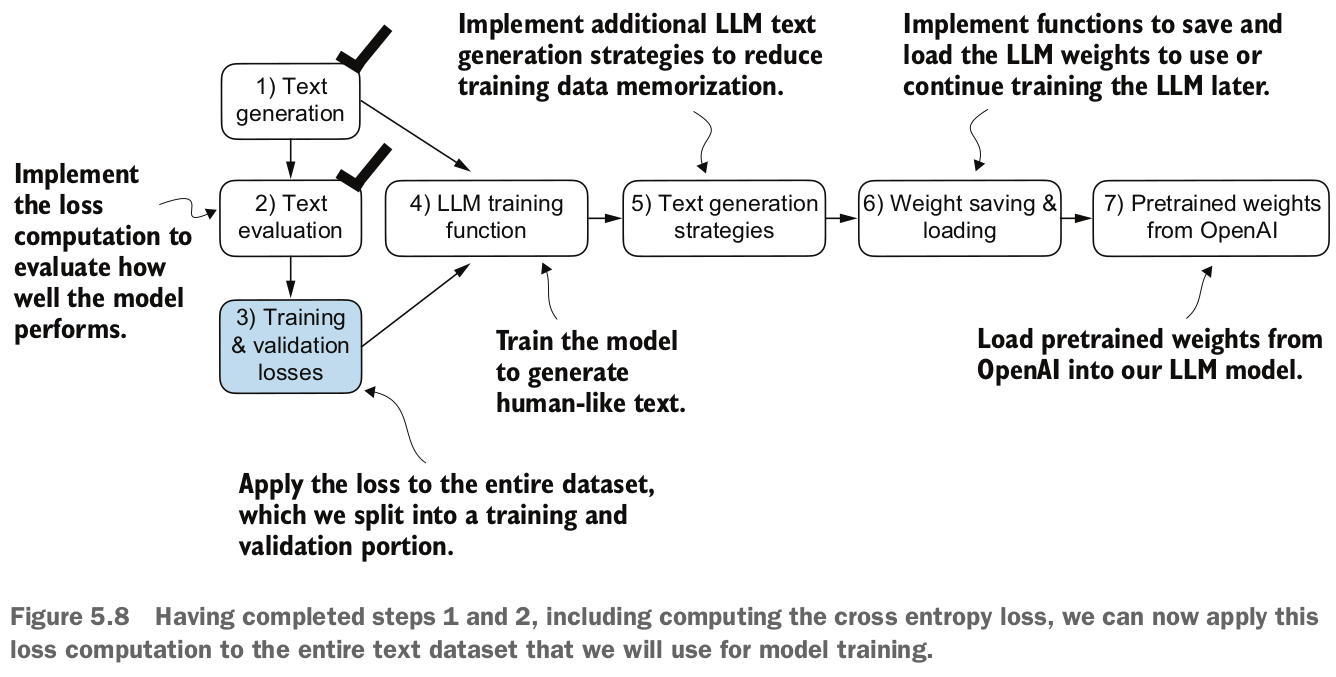

Para calcular a perda nos conjuntos de dados de treinamento e validação, utilizamos um conjunto de dados de texto muito pequeno, o conto "The Verdict", de Edith Wharton, com o qual já trabalhamos no capítulo 2. Ao selecionar um texto de domínio público, evitamos quaisquer preocupações relacionadas a direitos de uso. Além disso, o uso de um conjunto de dados tão pequeno permite a execução de exemplos de código em um laptop padrão em questão de minutos, mesmo sem uma GPU de última geração, o que é particularmente vantajoso para fins educacionais.

**NOTA:** Leitores interessados ​​também podem usar o código suplementar deste livro para preparar um conjunto de dados em larga escala, composto por mais de 60.000 livros de domínio público do Projeto Gutenberg, e treinar um LLM com base neles (consulte o apêndice D para obter detalhes).

---

$\large \textbf{O Custo do Pre-Treinamento de LLMs}$

Para colocar a escala do nosso projeto em perspectiva, considere o treinamento do modelo Llama 2 de 7 bilhões de parâmetros, um LLM relativamente popular e de acesso aberto. Este modelo exigiu 184.320 horas de GPU em GPUs A100 caras, processando 2 trilhões de tokens. No momento da redação deste texto, executar um servidor em nuvem 8 × A100 na AWS custava cerca de \\$ 30 por hora. Uma estimativa aproximada coloca o custo total de treinamento de tal LLM em cerca de \\$ 690.000 (calculado como 184.320 horas divididas por 8 e depois multiplicadas por \\$ 30).

---

O código a seguir carrega o conto "The Verdict":

In [ ]:
# Importa o módulo 'urllib.request', que é usado para lidar com URLs.
# Este módulo fornece funções para abrir e ler URLs.
import urllib.request

# Define a URL do arquivo de texto que será baixado.
# A string é quebrada em várias linhas para melhor legibilidade, mas é uma única URL.
# A URL aponta para o arquivo "the-verdict.txt" em um repositório do GitHub.
url = ("https://raw.githubusercontent.com/rasbt/"
      "LLMs-from-scratch/main/ch02/01_main-chapter-code/"
      "the-verdict.txt")

# Define o caminho do arquivo de texto que será lido.
# Neste caso, o arquivo é "the-verdict.txt".
file_path = "the-verdict.txt"

# Usa a função 'urlretrieve' do módulo 'urllib.request' para baixar o arquivo.
# O primeiro argumento é a URL do arquivo a ser baixado ('url').
# O segundo argumento é o caminho onde o arquivo será salvo localmente ('file_path').
# Esta função baixa o conteúdo da URL e o salva no caminho especificado.
urllib.request.urlretrieve(url, file_path)

# Abre o arquivo especificado pelo `file_path` para leitura ('r').
# O argumento `encoding="utf-8"` especifica a codificação do arquivo como UTF-8,
# que é uma codificação de caracteres comum e suporta uma ampla gama de caracteres.
# O uso de `with open(...) as file:` garante que o arquivo será fechado automaticamente
# após o bloco de código, mesmo que ocorra um erro.
with open(file_path, "r", encoding="utf-8") as file:
    # Lê todo o conteúdo do arquivo aberto e o armazena na variável `text_data`.
    # O método `.read()` lê o arquivo inteiro como uma única string.
    text_data = file.read()

Após carregar o conjunto de dados, podemos verificar o número de caracteres e tokens no conjunto de dados:

In [ ]:
# Calcula o número total de caracteres na string `text_data`.
# A função len() retorna o número de itens em um objeto. Para uma string, retorna o número de caracteres.
total_characters = len(text_data)

# Calcula o número total de tokens no texto.
# `tokenizer.encode(text_data)` tokeniza a string `text_data` e retorna uma lista de IDs de token.
# len() é então usado para obter o número de elementos (tokens) nesta lista.
total_tokens = len(tokenizer.encode(text_data))

# Imprime o número total de caracteres.
# A função print() exibe a saída no console.
# "Characters:" é um rótulo de texto que será impresso antes do valor de `total_characters`.
print("Characters:", total_characters)

# Imprime o número total de tokens.
# Similar à linha anterior, imprime um rótulo e o valor da variável `total_tokens`.
print("Tokens:", total_tokens)

Characters: 20479
Tokens: 5145


Com apenas 5.145 tokens, o texto pode parecer pequeno demais para treinar um LLM, mas, como mencionado anteriormente, é para fins educacionais, para que possamos executar o código em minutos, em vez de semanas. Além disso, posteriormente, carregaremos pesos pré-treinados do OpenAI em nosso código `GPTModel`.

Em seguida, dividimos o conjunto de dados em um conjunto de treinamento e um conjunto de validação e usamos os carregadores de dados do Capítulo 2 para preparar os lotes para o treinamento do LLM. Esse processo é visualizado na Figura 5.9. Devido a restrições espaciais, usamos `max_length=6`. No entanto, para os carregadores de dados reais, definimos `max_length` igual ao comprimento do contexto de 256 tokens suportado pelo LLM, para que o LLM veja textos mais longos durante o treinamento.

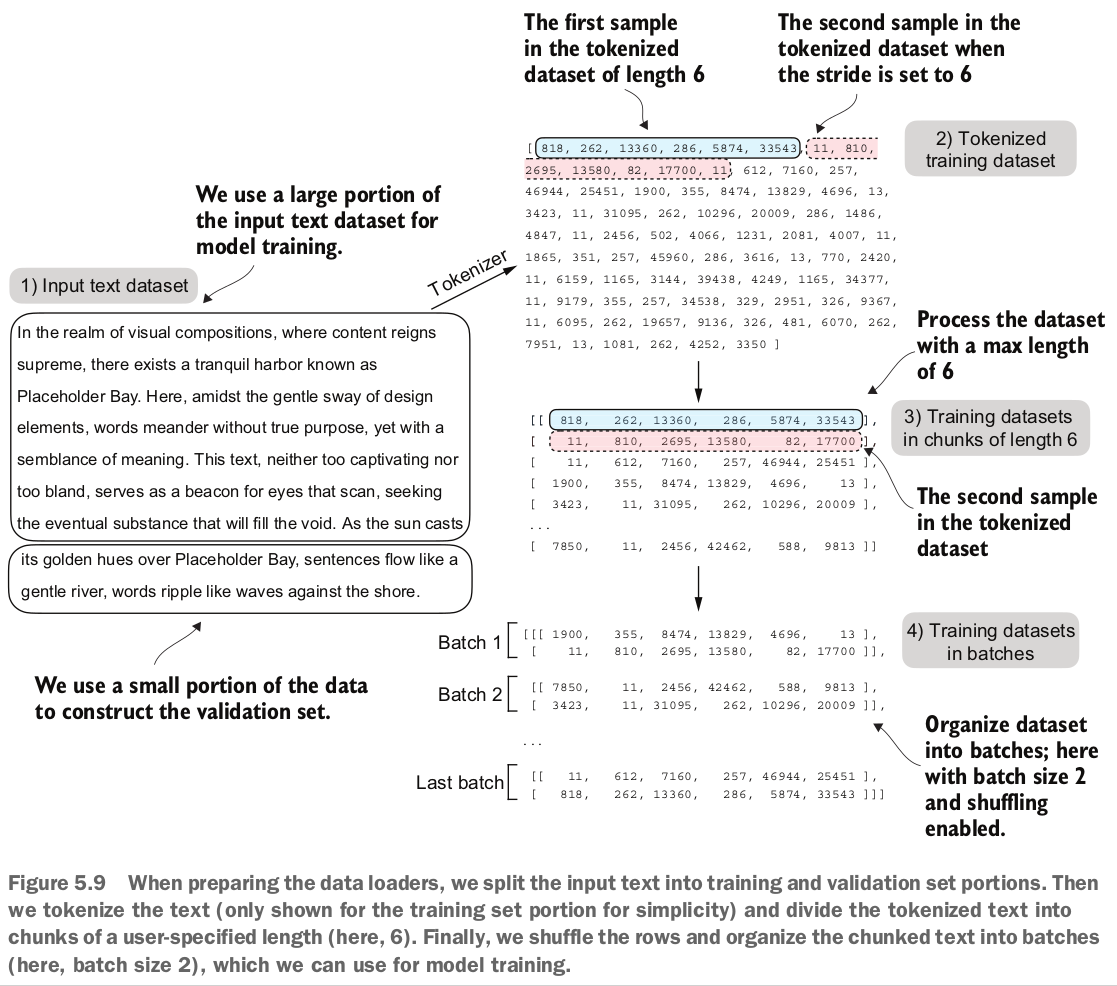

**NOTA:** Estamos treinando o modelo com dados de treinamento apresentados em blocos de tamanho semelhante para simplicidade e eficiência. No entanto, na prática, também pode ser benéfico treinar um LLM com entradas de comprimento variável para ajudar o LLM a generalizar melhor entre diferentes tipos de entradas quando estiver sendo usado.

Para implementar a divisão e o carregamento de dados, primeiro definimos um train_ratio para usar 90% dos dados para treinamento e os 10% restantes como dados de validação para avaliação do modelo durante o treinamento:

In [ ]:
# Define a proporção de dados a serem usados para treinamento.
# Neste caso, 90% (0.90) dos dados serão usados para treinamento.
train_ratio = 0.90

# Calcula o índice onde os dados devem ser divididos em conjuntos de treinamento e validação.
# len(text_data) obtém o número total de caracteres na string `text_data`.
# train_ratio * len(text_data) calcula o número de caracteres que correspondem a 90% do total.
# int(...) converte o resultado para um número inteiro, pois um índice deve ser um número inteiro.
split_idx = int(train_ratio * len(text_data))

# Cria o conjunto de dados de treinamento.
# text_data[:split_idx] usa fatiamento de string para obter todos os caracteres desde o início da string
# até o índice calculado `split_idx` (exclusivo).
train_data = text_data[:split_idx]

# Cria o conjunto de dados de validação.
# text_data[split_idx:] usa fatiamento de string para obter todos os caracteres desde o índice calculado `split_idx`
# até o final da string.
val_data = text_data[split_idx:]

Usando os subconjuntos `train_data` e `val_data`, agora podemos criar o respectivo carregador de dados reutilizando o código `create_dataloader_v1` do capítulo 2:

In [ ]:
from llms_from_scratch.ch02 import create_dataloader_v1
torch.manual_seed(123)

In [ ]:
GPT_CONFIG_124M["context_length"]

256

In [ ]:
train_loader = create_dataloader_v1(
    # O conjunto de dados de treinamento a ser carregado.
    train_data,
    # batch_size: O número de exemplos por lote.
    # Cada lote de dados será processado pelo modelo simultaneamente.
    # Um tamanho de lote maior pode acelerar o treinamento (se a GPU permitir),
    # mas requer mais memória.
    batch_size=2,
    # max_length: O comprimento máximo de cada sequência no lote.
    # Define o tamanho das "janelas" de texto que o modelo verá.
    # É crucial que isso corresponda ao `context_length` do modelo
    # para que o modelo possa processar as sequências corretamente.
    max_length=GPT_CONFIG_124M["context_length"],
    # stride: O passo (em número de tokens) entre o início de sequências consecutivas.
    # Se stride for igual a max_length, os lotes serão segmentos não sobrepostos do texto.
    # Se stride for menor que max_length, haverá sobreposição entre os lotes,
    # o que pode ajudar o modelo a ver mais contextos.
    stride=GPT_CONFIG_124M["context_length"],
    # drop_last: Se for True, o último lote será descartado se não contiver
    # o número completo de exemplos especificado por `batch_size`.
    # Isso garante que todos os lotes tenham o mesmo tamanho durante o treinamento,
    # o que pode simplificar o código e otimizar o desempenho em algumas operações.
    drop_last=True,
    # shuffle: Se for True, os dados serão embaralhados a cada época de treinamento.
    # Isso ajuda a evitar que o modelo memorize a ordem dos dados e melhora a generalização.
    shuffle=True,
    # num_workers: O número de subprocessos a serem usados para carregamento de dados assíncrono.
    # Um valor maior pode acelerar o carregamento de dados, mantendo a GPU ocupada.
    # 0 significa que o carregamento de dados será feito no processo principal.
    num_workers=0
)

val_loader = create_dataloader_v1(
    # O conjunto de dados de validação a ser carregado.
    val_data,
    # batch_size: O número de exemplos por lote para validação.
    # Geralmente, pode ser maior do que o lote de treinamento, pois não há cálculo de gradiente.
    batch_size=2,
    # max_length: O comprimento máximo de cada sequência no lote de validação.
    # Deve corresponder ao `context_length` do modelo.
    max_length=GPT_CONFIG_124M["context_length"],
    # stride: O passo (em número de tokens) entre o início de sequências consecutivas
    # no conjunto de validação.
    stride=GPT_CONFIG_124M["context_length"],
    # drop_last: Geralmente False para validação, para garantir que todos os exemplos
    # no conjunto de validação sejam avaliados, mesmo que o último lote seja incompleto.
    drop_last=False,
    # shuffle: Geralmente False para validação, para garantir que a avaliação seja consistente
    # e reproduzível em diferentes execuções.
    shuffle=False,
    # num_workers: Número de subprocessos para carregamento de dados de validação.
    num_workers=0
)

Utilizamos um tamanho de lote relativamente pequeno para reduzir a demanda por recursos computacionais, pois estávamos trabalhando com um conjunto de dados muito pequeno. Na prática, treinar LLMs com tamanhos de lote de 1.024 ou mais não é incomum.

Como verificação opcional, podemos iterar pelos carregadores de dados para garantir que eles foram criados corretamente:

In [ ]:
# Imprime um cabeçalho para a saída do carregador de treinamento.
print("Train loader:")
# Itera sobre o `train_loader`. Cada iteração retorna um lote de dados de treinamento,
# dividido em entradas (`x`) e alvos (`y`).
for x, y in train_loader:
    # Imprime as formas (shapes) dos tensores `x` (entradas) e `y` (alvos) para o lote atual.
    # A forma de `x` deve ser (batch_size, max_length), e a forma de `y` também deve ser (batch_size, max_length).
    # Isso confirma que o carregador de dados está gerando lotes com as dimensões esperadas.
    print(x.shape, y.shape)

# Imprime uma linha em branco e um cabeçalho para a saída do carregador de validação.
print("\nValidation loader:")
# Itera sobre o `val_loader`. Cada iteração retorna um lote de dados de validação,
# dividido em entradas (`x`) e alvos (`y`).
for x, y in val_loader:
    # Imprime as formas (shapes) dos tensores `x` (entradas) e `y` (alvos) para o lote atual.
    # A forma de `x` deve ser (batch_size, max_length), e a forma de `y` também deve ser (batch_size, max_length).
    # Isso confirma que o carregador de dados de validação está funcionando corretamente.
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


Com base na saída do código anterior, temos nove lotes de conjuntos de treinamento com duas amostras e 256 tokens cada. Como alocamos apenas 10% dos dados para validação, há apenas um lote de validação composto por dois exemplos de entrada. Como esperado, os dados de entrada (x) e os dados de destino (y) têm o mesmo formato (o tamanho do lote vezes o número de tokens em cada lote), visto que os alvos são as entradas deslocadas em uma posição, conforme discutido no Capítulo 2.

Em seguida, implementamos uma função de utilidade para calcular a perda de entropia cruzada de um determinado lote retornado pelo carregador de treinamento e validação:

In [ ]:
def calc_loss_batch(input_batch, target_batch, model, device):
    # Move o tensor `input_batch` para o dispositivo especificado (CPU ou GPU).
    # Isso é necessário para garantir que os dados e o modelo estejam no mesmo dispositivo
    # antes de realizar as operações. Se você estiver usando uma GPU, isso copiará
    # os dados da CPU para a memória da GPU.
    input_batch = input_batch.to(device)
    # Move o tensor `target_batch` para o mesmo dispositivo especificado.
    # Os alvos também precisam estar no mesmo dispositivo que as entradas e o modelo.
    target_batch = target_batch.to(device)
    # Passa o lote de entrada (`input_batch`) para o modelo.
    # O modelo processa as entradas e retorna os logits, que são as pontuações brutas
    # de saída antes da aplicação de uma função de ativação como softmax.
    logits = model(input_batch)
    # Calcula a perda de entropia cruzada.
    # torch.nn.functional.cross_entropy é uma função conveniente para calcular a perda
    # em problemas de classificação multi-classe. Ela espera os logits e os alvos.
    # - logits.flatten(0, 1): Achata as dimensões 0 (lote) e 1 (sequência) do tensor logits.
    #   Isso transforma a forma (batch_size, sequence_length, vocab_size) para
    #   (batch_size * sequence_length, vocab_size), que é o formato esperado pela
    #   função cross_entropy para os logits. Cada linha no tensor achatado representa
    #   as pontuações de logits para um único token na sequência do lote.
    # - target_batch.flatten(): Achata todo o tensor de alvos.
    #   Isso transforma a forma (batch_size, sequence_length) para (batch_size * sequence_length),
    #   que é o formato esperado pela função cross_entropy para os alvos. Cada valor
    #   no tensor achatado é o ID do token alvo correspondente.
    # A função cross_entropy internamente aplica log-softmax aos logits e calcula
    # a perda logarítmica negativa média com base nos targets.
    loss = torch.nn.functional.cross_entropy(
        logits.flatten(0, 1), target_batch.flatten()
    )
    # Retorna o valor da perda calculado para o lote atual.
    return loss

Agora podemos usar esta função utilitária `calc_loss_batch`, que calcula a perda de um único lote, para implementar a seguinte função `calc_loss_loader`, que calcula a perda de todos os lotes amostrados por um determinado carregador de dados.

In [ ]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
    # Inicializa o total da perda acumulada para este carregador de dados.
    # Começamos com 0.0 (um float) para garantir que as operações de soma subsequentes
    # mantenham o tipo float.
    total_loss = 0.

    # Verifica se o carregador de dados está vazio.
    # Se o comprimento do data_loader for 0, não há lotes para processar.
    if len(data_loader) == 0:
        # Retorna "NaN" (Not a Number) para indicar que a perda não pôde ser calculada
        # porque não havia dados.
        return float("nan")

    # Verifica se o número de lotes a serem processados não foi especificado explicitamente.
    elif num_batches is None:
        # Se `num_batches` for None, definimos o número de lotes a serem processados
        # como o número total de lotes disponíveis no `data_loader`.
        num_batches = len(data_loader)

    # Caso contrário (se `num_batches` foi especificado).
    else:
        # Definimos o número de lotes a serem processados como o menor valor entre
        # o `num_batches` especificado e o número total de lotes no `data_loader`.
        # Isso garante que não tentemos processar mais lotes do que existem.
        num_batches = min(num_batches, len(data_loader))

    # Itera sobre os lotes do `data_loader`.
    # `enumerate` fornece tanto o índice (`i`) quanto o item (o lote, desempacotado em `input_batch` e `target_batch`).
    for i, (input_batch, target_batch) in enumerate(data_loader):
        # Verifica se o índice do lote atual (`i`) é menor que o número de lotes que queremos processar (`num_batches`).
        if i < num_batches:
            # Calcula a perda para o lote atual usando a função auxiliar `calc_loss_batch`.
            # Passamos o lote de entrada, o lote de destino, o modelo e o dispositivo (CPU/GPU).
            loss = calc_loss_batch(
                input_batch, target_batch, model, device
            )
            # Soma o valor da perda do lote atual (`loss.item()`) à perda total acumulada.
            # `.item()` é usado para extrair o valor escalar de um tensor PyTorch de um único elemento.
            total_loss += loss.item()

        # Se o índice do lote atual for maior ou igual ao número de lotes a serem processados.
        else:
            # Quebra o loop, pois já processamos o número desejado de lotes.
            break

    # Retorna a perda média sobre os lotes processados.
    # Dividimos a perda total acumulada pelo número de lotes que foram efetivamente processados.
    return total_loss / num_batches

Por padrão, a função `calc_loss_loader` itera sobre todos os lotes em um determinado carregador de dados, acumula a perda na variável `total_loss` e, em seguida, calcula a média da perda sobre o número total de lotes. Como alternativa, podemos especificar um número menor de lotes por meio de `num_batches` para acelerar a avaliação durante o treinamento do modelo.

Vamos agora ver esta função `calc_loss_loader` em ação, aplicando-a aos carregadores de conjuntos de treinamento e validação:

In [ ]:
# Determina o dispositivo a ser usado para computação (GPU se disponível, caso contrário CPU).
# torch.cuda.is_available() retorna True se uma GPU CUDA estiver disponível no sistema.
# Se True, o dispositivo será configurado como "cuda" (para usar a GPU).
# Caso contrário, o dispositivo será configurado como "cpu".
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move o modelo para o dispositivo determinado.
# model.to(device) transfere os parâmetros e buffers do modelo para a memória da GPU (se device for "cuda")
# ou os mantém na CPU (se device for "cpu"). É essencial que o modelo e os dados estejam no mesmo dispositivo
# para que as operações de computação (como a passagem forward) possam ser realizadas.
model.to(device)

# O bloco `with torch.no_grad():` desativa o cálculo de gradientes.
# Isso é feito porque estamos apenas calculando a perda para avaliação (tanto no conjunto de treinamento quanto no de validação),
# e não precisamos calcular gradientes para otimização neste momento.
# Desativar gradientes economiza memória e acelera a computação.
with torch.no_grad():
    # Calcula a perda no conjunto de treinamento usando a função auxiliar `calc_loss_loader`.
    # Passamos o carregador de dados de treinamento (`train_loader`), o modelo (`model`) e o dispositivo (`device`).
    # O resultado (a perda média sobre os lotes de treinamento) é armazenado na variável `train_loss`.
    train_loss = calc_loss_loader(train_loader, model, device)
    # Calcula a perda no conjunto de validação usando a função auxiliar `calc_loss_loader`.
    # Passamos o carregador de dados de validação (`val_loader`), o modelo (`model`) e o dispositivo (`device`).
    # O resultado (a perda média sobre os lotes de validação) é armazenado na variável `val_loss`.
    val_loss = calc_loss_loader(val_loader, model, device)

# Imprime a perda calculada no conjunto de treinamento.
# Isso mostra o quão bem o modelo se saiu nos dados de treinamento (menor é melhor).
print("Training loss:", train_loss)

# Imprime a perda calculada no conjunto de validação.
# Isso mostra o quão bem o modelo se generaliza para dados que não viu durante o "treinamento" (embora ainda não tenhamos treinado).
# A perda de validação é uma métrica crucial para monitorar o overfitting.
print("Validation loss:", val_loss)

Training loss: 10.987583372328016
Validation loss: 10.98110580444336


Os valores de perda são relativamente altos porque o modelo ainda não foi treinado. Para efeito de comparação, a perda se aproxima de 0 se o modelo aprender a gerar os próximos tokens conforme eles aparecem nos conjuntos de treinamento e validação.

Agora que temos uma maneira de medir a qualidade do texto gerado, treinaremos
o LLM para reduzir essa perda, de modo que ele se torne melhor na geração de texto, conforme ilustrado na Figura 5.10.

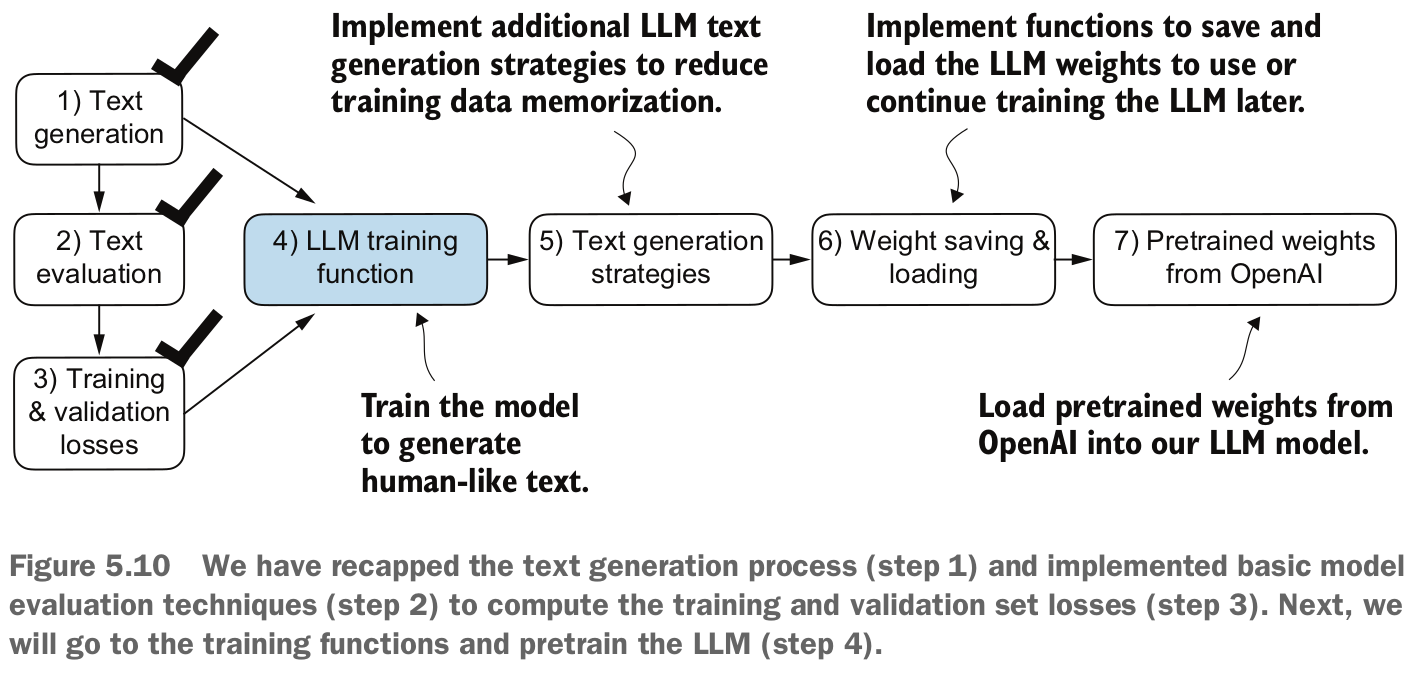

Em seguida, nos concentraremos no pré-treinamento do LLM. Após o treinamento do modelo, implementaremos estratégias alternativas de geração de texto e salvaremos e carregaremos os pesos do modelo pré-treinado.

## **2 - Treinamento de um LLM**

Finalmente chegou a hora de implementar o código para pré-treinamento do LLM, nosso `GPTModel`. Para isso, focamos em um loop de treinamento simples e direto para manter o código conciso e legível.

**NOTA:** Leitores interessados ​​podem aprender sobre técnicas mais avançadas, incluindo ***aquecimento da taxa de aprendizagem***, ***recozimento de cosseno*** e ***recorte de gradiente***, no apêndice D.

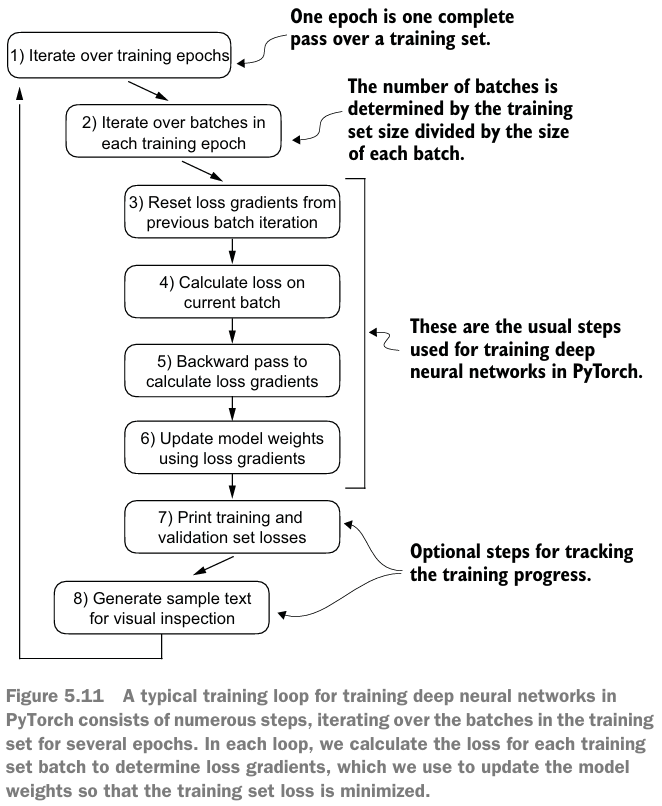

O fluxograma da Figura 5.11 descreve um fluxo de trabalho típico de treinamento de redes neurais com PyTorch, que usamos para treinar um LLM. Ele descreve oito etapas, começando com a iteração em cada época, processamento de lotes, redefinição de gradientes, cálculo de perdas e novos gradientes, atualização de pesos e concluindo com etapas de monitoramento, como impressão de perdas e geração de amostras de texto.

**NOTA:** Se você é relativamente novo no treinamento de redes neurais profundas com PyTorch e não está familiarizado com nenhuma dessas etapas, considere ler as seções A.5 a A.8 no apêndice A.

Podemos implementar esse fluxo de treinamento por meio da função `train_model_simple` em código.

In [ ]:
# Define a função de treinamento principal para um modelo de linguagem simples.
# Esta função itera sobre os dados de treinamento e validação para ajustar os pesos do modelo.
#
# Parâmetros:
# - model: A instância do modelo PyTorch a ser treinado (neste caso, a classe GPTModel).
#          Este objeto contém a arquitetura da rede neural e seus parâmetros treináveis.
# - train_loader: Um objeto DataLoader do PyTorch que fornece lotes de dados de treinamento.
#                 Ele lida com o carregamento dos dados, embaralhamento e organização em lotes.
# - val_loader: Um objeto DataLoader do PyTorch que fornece lotes de dados de validação.
#               Usado para avaliar o desempenho do modelo em dados não vistos durante o treinamento,
#               ajudando a monitorar o overfitting.
# - optimizer: Um objeto Optimizer do PyTorch (por exemplo, Adam, SGD).
#              Responsável por atualizar os pesos do modelo com base nos gradientes calculados.
# - device: O dispositivo de computação a ser usado ('cuda' para GPU ou 'cpu' para CPU).
#           Os tensores e o modelo devem estar no mesmo dispositivo para operações de computação.
# - num_epochs: O número total de vezes que o conjunto de dados de treinamento completo será iterado.
#               Cada iteração completa sobre o conjunto de treinamento é uma época.
# - eval_freq: A frequência (em número de passos globais) com que a avaliação nos
#              conjuntos de treinamento e validação será realizada e impressa.
# - eval_iter: O número de lotes a serem usados para calcular a perda de avaliação
#              em cada conjunto (treinamento e validação) quando a avaliação é acionada.
#              Um valor None ou igual ao número total de lotes usará o conjunto completo.
# - start_context: Uma string de texto inicial usada para gerar amostras de texto
#                  pelo modelo em intervalos regulares durante o treinamento. Isso ajuda a visualizar
#                  como a capacidade de geração de texto do modelo melhora ao longo do tempo.
# - tokenizer: Um objeto tokenizer (por exemplo, tiktoken) usado para converter
#              texto em IDs de token e vice-versa. Necessário para processar o `start_context`.
def train_model_simple(model, train_loader, val_loader,
                       optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):

    # Inicializa listas vazias para armazenar as perdas de treinamento e validação ao longo do tempo,
    # e o número total de tokens vistos até o ponto de avaliação.
    train_losses, val_losses, track_tokens_seen = [], [], []
    # Inicializa variáveis para rastrear o número total de tokens processados
    # e o número de passos de otimização (atualizações de peso) realizados globalmente.
    # global_step começa em -1 para que o primeiro passo (após a primeira atualização) seja 0.
    tokens_seen, global_step = 0, -1

    # Loop principal que itera sobre o número especificado de épocas.
    for epoch in range(num_epochs):
        # Coloca o modelo no modo de treinamento.
        # Isso habilita funcionalidades como dropout e normalização em lote
        # que são usadas apenas durante a fase de treinamento.
        model.train()
        # Itera sobre os lotes de dados fornecidos pelo `train_loader`.
        # Cada iteração obtém um lote de entradas (`input_batch`) e seus alvos correspondentes (`target_batch`).
        for input_batch, target_batch in train_loader:
            # Zera os gradientes acumulados de todos os parâmetros treináveis.
            # Isso é crucial em cada passo de treinamento para evitar acumular gradientes
            # de lotes anteriores, garantindo que a atualização de peso use apenas os gradientes
            # do lote atual.
            optimizer.zero_grad()
            # Calcula a perda para o lote de treinamento atual.
            # Chama a função auxiliar `calc_loss_batch` que calcula a entropia cruzada
            # entre as previsões do modelo (logits) e os alvos reais para este lote.
            # Passamos o lote de entrada, o lote de destino, o modelo e o dispositivo.
            loss = calc_loss_batch(
                input_batch, target_batch, model, device
            )
            # Calcula os gradientes da perda em relação a todos os parâmetros treináveis do modelo.
            # Este é o passo de backpropagation, onde a diferença entre a previsão e o alvo
            # é retropropagada através da rede para calcular como cada peso contribuiu para a perda.
            loss.backward()
            # Atualiza os pesos do modelo com base nos gradientes calculados no passo anterior.
            # O otimizador usa o algoritmo de otimização configurado (por exemplo, Adam)
            # para ajustar os pesos de forma a reduzir a perda.
            optimizer.step()
            # Atualiza o contador de tokens vistos.
            # `input_batch.numel()` retorna o número total de elementos (tokens)
            # no tensor `input_batch` (tamanho do lote * comprimento da sequência).
            # Adicionamos isso ao total de tokens vistos globalmente.
            tokens_seen += input_batch.numel()
            # Incrementa o contador de passos globais.
            # Cada chamada a `optimizer.step()` representa um passo de otimização.
            global_step += 1

            # Verifica se é hora de realizar uma avaliação (com base na frequência `eval_freq`).
            # O operador `%` calcula o resto da divisão. Se o resto for 0, significa que
            # `global_step` é um múltiplo de `eval_freq`.
            if global_step % eval_freq == 0:
                # Realiza a avaliação nos conjuntos de treinamento e validação.
                # Chama a função auxiliar `evaluate_model` (não mostrada aqui, mas presumidamente
                # calcula a perda em um subconjunto dos dados de treinamento e nos dados de validação).
                # Passamos o modelo, carregadores de dados, dispositivo e o número de iterações para avaliação.
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter
                )
                # Adiciona a perda de treinamento calculada à lista `train_losses` para rastreamento histórico.
                train_losses.append(train_loss)
                # Adiciona a perda de validação calculada à lista `val_losses` para rastreamento histórico.
                val_losses.append(val_loss)
                # Adiciona o número total de tokens vistos neste ponto de avaliação à lista `track_tokens_seen`.
                # Isso permite correlacionar as perdas com a quantidade de dados que o modelo viu.
                track_tokens_seen.append(tokens_seen)
                # Imprime o progresso atual, incluindo o número da época, o passo global,
                # a perda de treinamento e a perda de validação.
                # O formato f-string `f"..."` permite incorporar variáveis diretamente na string.
                # `:06d` formata `global_step` como um número inteiro preenchido com zeros à esquerda para ter 6 dígitos.
                # `:.3f` formata as perdas como números de ponto flutuante com 3 casas decimais.
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, "
                      f"Val loss {val_loss:.3f}"
                )
        # Gera e imprime uma amostra de texto usando o modelo no final de cada época.
        # Chama a função auxiliar `generate_and_print_sample` (não mostrada aqui, mas presumidamente
        # usa o modelo para gerar texto a partir de um contexto inicial e imprime o resultado).
        # Isso fornece uma visão qualitativa de como a geração de texto do modelo está progredindo.
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )
    # Retorna as listas contendo o histórico das perdas de treinamento, perdas de validação,
    # e o número de tokens vistos em cada ponto de avaliação. Estes podem ser usados
    # para plotar curvas de aprendizado e analisar o desempenho do treinamento.
    return train_losses, val_losses, track_tokens_seen

Observe que a função `train_model_simple` que acabamos de criar utiliza duas funções que ainda não definimos: `evaluate_model` e `generate_and_print_sample`.

A função `evaluate_model` corresponde à etapa 7 da Figura 5.11. Ela imprime as perdas dos conjuntos de treinamento e validação após cada atualização do modelo, para que possamos avaliar se o treinamento melhora o modelo. Mais especificamente, a função `evaluate_model` calcula a perda sobre o conjunto de treinamento e validação, garantindo que o modelo esteja no modo de avaliação com o rastreamento de gradiente e o dropout desabilitados ao calcular a perda sobre os conjuntos de treinamento e validação:

In [ ]:
# Define a função para avaliar o desempenho do modelo nos conjuntos de treinamento e validação.
# Esta função é chamada periodicamente durante o treinamento para monitorar o progresso do modelo.
#
# Parâmetros:
# - model: A instância do modelo PyTorch a ser avaliado (neste caso, a classe GPTModel).
#          Este objeto contém a arquitetura da rede neural e seus parâmetros.
# - train_loader: Um objeto DataLoader do PyTorch que fornece lotes de dados de treinamento.
#                 Usado para calcular a perda no conjunto de treinamento (geralmente em um subconjunto
#                 para economizar tempo durante a avaliação).
# - val_loader: Um objeto DataLoader do PyTorch que fornece lotes de dados de validação.
#               Usado para calcular a perda no conjunto de validação, o que indica a capacidade
#               de generalização do modelo para dados não vistos.
# - device: O dispositivo de computação a ser usado ('cuda' para GPU ou 'cpu' para CPU).
#           Os tensores e o modelo devem estar no mesmo dispositivo.
# - eval_iter: O número de lotes a serem usados para calcular a perda de avaliação
#              em cada carregador de dados (treinamento e validação). Usar um número menor
#              do que o total de lotes acelera a avaliação.
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    # Coloca o modelo no modo de avaliação.
    # Isso desativa funcionalidades que são específicas do treinamento, como dropout e
    # normalização em lote, para garantir que a avaliação seja determinística e reflita
    # o desempenho real do modelo treinado.
    model.eval()
    # O bloco `with torch.no_grad():` desativa o cálculo de gradientes.
    # Durante a avaliação, não precisamos calcular gradientes, pois não estamos
    # atualizando os pesos do modelo. Desativar o cálculo de gradientes economiza
    # memória e acelera a execução.
    with torch.no_grad():
        # Calcula a perda média em um subconjunto dos dados de treinamento.
        # Chama a função auxiliar `calc_loss_loader` para iterar sobre os lotes
        # do `train_loader` e calcular a perda de entropia cruzada para cada lote.
        # `num_batches=eval_iter` limita o número de lotes usados para esta avaliação
        # no conjunto de treinamento.
        train_loss = calc_loss_loader(
            train_loader, model, device, num_batches=eval_iter
        )
        # Calcula a perda média nos dados de validação.
        # Chama a função auxiliar `calc_loss_loader` para iterar sobre os lotes
        # do `val_loader` e calcular a perda de entropia cruzada para cada lote.
        # `num_batches=eval_iter` limita o número de lotes usados para esta avaliação
        # no conjunto de validação.
        val_loss = calc_loss_loader(
            val_loader, model, device, num_batches=eval_iter
        )
    # Coloca o modelo de volta no modo de treinamento.
    # Isso reativa funcionalidades como dropout e normalização em lote, preparando
    # o modelo para continuar a fase de treinamento no loop principal.
    model.train()
    # Retorna os valores calculados da perda média nos conjuntos de treinamento e validação.
    # Estes valores são usados para monitorar o progresso do treinamento e detectar
    # possíveis problemas como overfitting (quando a perda de treinamento diminui,
    # mas a perda de validação aumenta).
    return train_loss, val_loss

Semelhante a `evaluate_model`, a função `generate_and_print_sample` é uma função de conveniência que usamos para monitorar se o modelo melhora durante o treinamento. Em particular, a função `generate_and_print_sample` recebe um trecho de texto (`start_context`) como entrada, converte-o em IDs de token e o envia ao LLM para gerar uma amostra de texto usando a função `generate_text_simple` que usamos anteriormente:

In [ ]:
# Define a função para gerar e imprimir uma amostra de texto usando o modelo.
# Esta função é usada para visualizar a capacidade de geração de texto do modelo
# durante o treinamento, começando de um contexto inicial.
#
# Parâmetros:
# - model: A instância do modelo PyTorch (GPTModel) a ser usado para gerar texto.
# - tokenizer: Um objeto tokenizer (tiktoken) usado para converter texto em IDs de token e vice-versa.
#              É necessário para codificar o contexto inicial e decodificar a saída gerada.
# - device: O dispositivo de computação ('cuda' ou 'cpu') onde o modelo e os tensores estão localizados.
# - start_context: Uma string de texto inicial que serve como prompt para o modelo.
#                  O modelo continuará a sequência a partir deste ponto.
def generate_and_print_sample(model, tokenizer, device, start_context):
    # Coloca o modelo no modo de avaliação.
    # Isso desativa funcionalidades específicas do treinamento (como dropout) para garantir
    # que a geração de texto seja determinística e não afetada por randomizações de treinamento.
    model.eval()
    # Obtém o tamanho do contexto suportado pelo modelo a partir da forma dos pesos
    # da camada de positional embedding (`pos_emb`). A primeira dimensão desses pesos
    # corresponde ao comprimento máximo da sequência que o modelo pode lidar.
    context_size = model.pos_emb.weight.shape[0]
    # Converte a string de contexto inicial em IDs de token usando o tokenizer.
    # `.to(device)` move o tensor resultante de IDs de token para o mesmo dispositivo
    # onde o modelo está, garantindo que a entrada para o modelo esteja no local correto.
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    # O bloco `with torch.no_grad():` desativa o cálculo de gradientes.
    # Durante a geração de texto (inferência), não precisamos calcular gradientes
    # para otimizar os pesos do modelo, pois isso é feito apenas durante o treinamento.
    # Desativar gradientes economiza memória e acelera a execução.
    with torch.no_grad():
        # Chama a função auxiliar `generate_text_simple` para gerar IDs de token.
        # Esta função implementa a lógica de geração de texto, tomando o modelo,
        # os IDs de token iniciais (`idx`), o número máximo de novos tokens a gerar
        # (`max_new_tokens`) e o tamanho do contexto do modelo como entrada.
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    # Converte os IDs de token gerados pelo modelo de volta para uma string de texto legível
    # usando a função auxiliar `token_ids_to_text` e o tokenizer.
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    # Imprime o texto gerado.
    # `.replace("\n", " ")` substitui quaisquer caracteres de nova linha por espaços
    # para garantir que a saída seja impressa em uma única linha para melhor legibilidade no console.
    print(decoded_text.replace("\n", " "))
    # Coloca o modelo de volta no modo de treinamento.
    # Isso reativa funcionalidades como dropout e normalização em lote, preparando
    # o modelo para continuar a fase de treinamento no loop principal.
    model.train()

Enquanto a função `evaluate_model` nos fornece uma estimativa numérica do progresso do treinamento do modelo, a função de texto `generate_and_print_sample` fornece um exemplo de texto concreto gerado pelo modelo para avaliar suas capacidades durante o treinamento.

---

$\large \textbf{AdamW}$

Otimizadores ***Adam*** são uma escolha popular para o treinamento de redes neurais profundas. No entanto, em nosso loop de treinamento, optamos pelo otimizador ***AdamW***. AdamW é uma variante de Adam que aprimora a abordagem de decaimento de peso, que visa minimizar a complexidade do modelo e
prevenir o sobreajuste, penalizando pesos maiores. Esse ajuste permite que AdamW alcance uma regularização mais eficaz e uma melhor generalização; portanto, AdamW é frequentemente
usado no treinamento de LLMs.

---

Vamos ver tudo isso em ação treinando uma instância `GPTModel` por 10 épocas usando um otimizador `AdamW` e a função `train_model_simple` que definimos anteriormente. A execução da função `train_model_simple` inicia o processo de treinamento, que leva cerca de 5 minutos para ser concluído em um MacBook Air ou laptop similar. A saída impressa durante essa execução é a seguinte:

In [ ]:
# Define a semente para o gerador de números aleatórios do PyTorch.
# Isso garante que a inicialização do modelo e outras operações aleatórias
# sejam reproduzíveis. Se você executar este código com a mesma semente,
# obterá os mesmos resultados iniciais e a mesma sequência de eventos aleatórios
# durante o treinamento.
torch.manual_seed(123)
# Inicializa uma nova instância da classe GPTModel usando a configuração
# definida no dicionário GPT_CONFIG_124M. Esta linha cria a arquitetura
# do modelo com os parâmetros especificados (tamanho do vocabulário, comprimento
# do contexto, dimensão do embedding, número de cabeças de atenção, número de camadas,
# taxa de dropout e viés QKV). Os pesos do modelo são inicializados aleatoriamente neste ponto.
model = GPTModel(GPT_CONFIG_124M)
# Move o modelo para o dispositivo especificado (CPU ou GPU).
# Isso garante que as operações de computação do modelo sejam realizadas
# no dispositivo apropriado. Se `device` for 'cuda', o modelo será transferido
# para a memória da GPU. Se for 'cpu', ele permanecerá na CPU.
model.to(device)
# Inicializa o otimizador AdamW.
# O otimizador é responsável por atualizar os pesos do modelo durante o treinamento
# com base nos gradientes calculados pela retropropagação.
# torch.optim.AdamW é uma variante do otimizador Adam que inclui uma forma aprimorada
# de decaimento de peso (weight decay) para regularização.
optimizer = torch.optim.AdamW(
     # model.parameters(): Retorna um iterador sobre todos os parâmetros treináveis
     # (pesos e vieses) do modelo. O otimizador usará esses parâmetros para realizar as atualizações.
     model.parameters(),
    # lr=0.0004: Define a taxa de aprendizado (learning rate). Este é um hiperparâmetro
    # crucial que determina o tamanho do passo que o otimizador dá ao atualizar os pesos.
    # Uma taxa de aprendizado menor pode levar a um treinamento mais estável, mas mais lento.
    # Uma taxa de aprendizado maior pode acelerar o treinamento, mas pode causar oscilações
    # ou divergência. 0.0004 é um valor comum de partida.
    lr=0.0004,
    # weight_decay=0.1: Define a força da regularização por decaimento de peso.
    # O decaimento de peso é uma técnica de regularização que penaliza pesos grandes,
    # ajudando a prevenir o overfitting (quando o modelo memoriza os dados de treinamento
    # em vez de aprender a generalizar). Um valor maior aplica uma penalidade mais forte.
    weight_decay=0.1
)
# Define o número de épocas para o treinamento.
# Uma época é uma iteração completa sobre todo o conjunto de dados de treinamento.
# Definir `num_epochs` como 10 significa que o modelo verá o conjunto de dados de treinamento 10 vezes.
num_epochs = 10
# Chama a função de treinamento principal para iniciar o processo de treinamento do modelo.
# Esta função executa o loop de treinamento para o número especificado de épocas.
# Ela passa todos os componentes necessários: o modelo, os carregadores de dados,
# o otimizador, o dispositivo, o número de épocas, a frequência de avaliação,
# o número de iterações de avaliação, o contexto inicial para amostragem de texto
# e o tokenizer.
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs,
    # eval_freq=5: Especifica que a avaliação do modelo nos conjuntos de treinamento
    # e validação será realizada a cada 5 passos globais (atualizações de peso).
    eval_freq=5,
    # eval_iter=5: Especifica que 5 lotes serão usados do `train_loader` e 5 lotes
    # do `val_loader` para calcular as perdas de avaliação em cada ponto de avaliação.
    # Isso economiza tempo em comparação com a avaliação em todo o conjunto.
    eval_iter=5,
    # start_context="Every effort moves you": Define a string de texto inicial
    # para a função `generate_and_print_sample`, que é chamada no final de cada época
    # para visualizar a qualidade do texto gerado pelo modelo.
    start_context="Every effort moves you",
    # tokenizer=tokenizer: Passa o objeto tokenizer para que a função de treinamento
    # possa converter o contexto inicial em IDs de token e as saídas geradas em texto.
    tokenizer=tokenizer
)

Ep 1 (Step 000000): Train loss 9.818, Val loss 9.930
Ep 1 (Step 000005): Train loss 8.066, Val loss 8.336
Every effort moves you,,,,,,,,,,,,.                                     
Ep 2 (Step 000010): Train loss 6.623, Val loss 7.053
Ep 2 (Step 000015): Train loss 6.047, Val loss 6.605
Every effort moves you, and,, and,,,,,,, and,.                                   
Ep 3 (Step 000020): Train loss 5.532, Val loss 6.507
Ep 3 (Step 000025): Train loss 5.399, Val loss 6.389
Every effort moves you, and to the to the of the to the, and I had. Gis, and, and, and, and, and, and I had the, and, and, and, and, and, and, and, and, and
Ep 4 (Step 000030): Train loss 4.895, Val loss 6.280
Ep 4 (Step 000035): Train loss 4.648, Val loss 6.304
Every effort moves you.  "I the picture.                    "I"I the picture"I had the the honour of the picture and I had been the picture of
Ep 5 (Step 000040): Train loss 4.023, Val loss 6.165
Every effort moves you know                                         

Como podemos ver, a perda de treinamento melhora drasticamente, começando com um valor de 9.781 e convergindo para 0,391. As habilidades linguísticas do modelo melhoraram bastante.
No início, o modelo só consegue adicionar vírgulas ao contexto inicial (`Every effort moves you,,,,,,,,,,,,`) ou repetir a palavra `and`. Ao final do treinamento, ele consegue gerar um texto gramaticalmente correto.

Semelhante à perda do conjunto de treinamento, podemos ver que a perda de validação começa alta (9.933) e diminui durante o treinamento. No entanto, ela nunca se torna tão pequena quanto a perda do conjunto de treinamento e permanece em 6.452 após a 10ª época.

Antes de discutir a perda de validação em mais detalhes, vamos criar um gráfico simples que mostra as perdas dos conjuntos de treinamento e validação lado a lado:

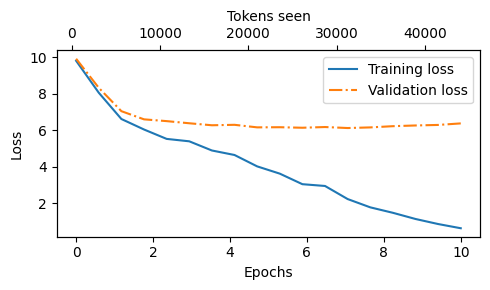

In [ ]:
# Importa a biblioteca matplotlib.pyplot, que é usada para criar visualizações estáticas,
# interativas e animadas em Python. É comumente usada para plotar dados.
import matplotlib.pyplot as plt
# Importa a classe MaxNLocator do módulo matplotlib.ticker.
# MaxNLocator é um localizador de ticks que tenta escolher no máximo N+1 ticks
# em intervalos "agradáveis" (por exemplo, múltiplos de potências de 10).
# É útil para garantir que os ticks em um eixo sejam números inteiros.
from matplotlib.ticker import MaxNLocator

# Define a função para plotar as curvas de perda de treinamento e validação.
#
# Parâmetros:
# - epochs_seen: Uma lista ou tensor dos números de época nos quais a avaliação foi realizada.
# - tokens_seen: Uma lista ou tensor do número total de tokens vistos até cada ponto de avaliação.
# - train_losses: Uma lista ou tensor dos valores da perda de treinamento calculada em cada avaliação.
# - val_losses: Uma lista ou tensor dos valores da perda de validação calculada em cada avaliação.
def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    # Cria uma figura e um conjunto de subplots.
    # fig é o objeto Figure (a janela ou página inteira).
    # ax1 é o objeto Axes (a área onde os dados são plotados).
    # figsize=(5, 3) define o tamanho da figura em polegadas (largura x altura).
    fig, ax1 = plt.subplots(figsize=(5, 3))
    # Plota a curva de perda de treinamento no eixo primário (ax1).
    # epochs_seen são os valores no eixo x (épocas).
    # train_losses são os valores no eixo y (perda de treinamento).
    # label="Training loss" define o rótulo para esta linha na legenda.
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    # Plota a curva de perda de validação no eixo primário (ax1).
    # epochs_seen são os valores no eixo x (épocas).
    # val_losses são os valores no eixo y (perda de validação).
    # linestyle="-." define o estilo da linha como traço-ponto.
    # label="Validation loss" define o rótulo para esta linha na legenda.
    ax1.plot(
        epochs_seen, val_losses, linestyle="-.", label="Validation loss"
    )
    # Define o rótulo para o eixo x do eixo primário.
    ax1.set_xlabel("Epochs")
    # Define o rótulo para o eixo y do eixo primário.
    ax1.set_ylabel("Loss")
    # Exibe a legenda no eixo primário.
    # loc="upper right" posiciona a legenda no canto superior direito do plot.
    ax1.legend(loc="upper right")
    # Configura o localizador de ticks para o eixo x do eixo primário.
    # MaxNLocator(integer=True) garante que os ticks no eixo x sejam números inteiros.
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    # Cria um segundo eixo x (`ax2`) que compartilha o mesmo eixo y (`ax1`).
    # Isso permite ter dois eixos x diferentes para o mesmo plot.
    ax2 = ax1.twiny()
    # Plota a curva de tokens vistos no segundo eixo x (`ax2`).
    # tokens_seen são os valores no eixo x (tokens vistos).
    # train_losses (ou val_losses, pois o eixo y é compartilhado) são os valores no eixo y.
    # alpha=0 torna esta linha completamente transparente. A linha em si não é visível,
    # mas ela é usada para definir a escala do segundo eixo x com base nos valores de `tokens_seen`.
    ax2.plot(tokens_seen, train_losses, alpha=0)
    # Define o rótulo para o segundo eixo x.
    ax2.set_xlabel("Tokens seen")
    # Ajusta automaticamente os parâmetros de subplot para que o layout da figura fique apertado.
    # Isso ajuda a evitar que rótulos ou títulos se sobreponham.
    fig.tight_layout()
    # Exibe a figura plotada.
    plt.show()

# Cria um tensor PyTorch para representar as épocas no eixo x.
# torch.linspace(start, end, steps) gera uma sequência de `steps` números
# igualmente espaçados entre `start` e `end` (inclusive).
# 0 é o valor inicial (a primeira época).
# num_epochs é o valor final (a última época).
# len(train_losses) é o número de pontos de avaliação (e, portanto, o número de perdas registradas).
# Isso cria uma sequência de números de época correspondente aos pontos onde as perdas foram registradas.
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
# Chama a função `plot_losses` para gerar o gráfico.
# Passa o tensor de épocas, a lista de tokens vistos, a lista de perdas de treinamento
# e a lista de perdas de validação como argumentos.
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

O gráfico de perdas de treinamento e validação resultante é mostrado na Figura 5.12. Como podemos ver, tanto as perdas de treinamento quanto as de validação começam a melhorar na primeira época. No entanto, as perdas começam a divergir após a segunda época. Essa divergência e o fato de a perda de validação ser muito maior do que a perda de treinamento indicam que o modelo está se ajustando excessivamente aos dados de treinamento. Podemos confirmar que o modelo memoriza os dados de treinamento literalmente pesquisando os trechos de texto gerados, como `quite insensible to the irony` no arquivo de texto "The Verdict".

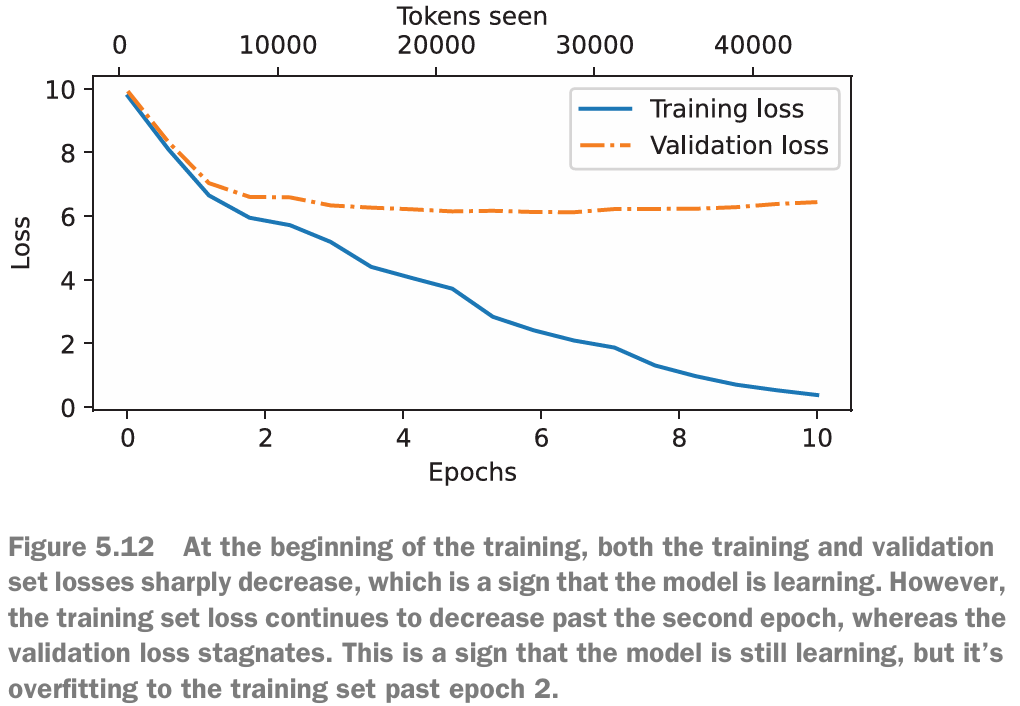

Essa memorização é esperada, visto que estamos trabalhando com um conjunto de dados de treinamento muito pequeno e treinando o modelo para múltiplas épocas. Normalmente, é comum treinar um modelo em um conjunto de dados muito maior para apenas uma época.

**NOTA:** Como mencionado anteriormente, leitores interessados ​​podem tentar treinar o modelo em 60.000 livros de domínio público do Projeto Gutenberg, onde esse sobreajuste não ocorre; veja o apêndice B para mais detalhes.

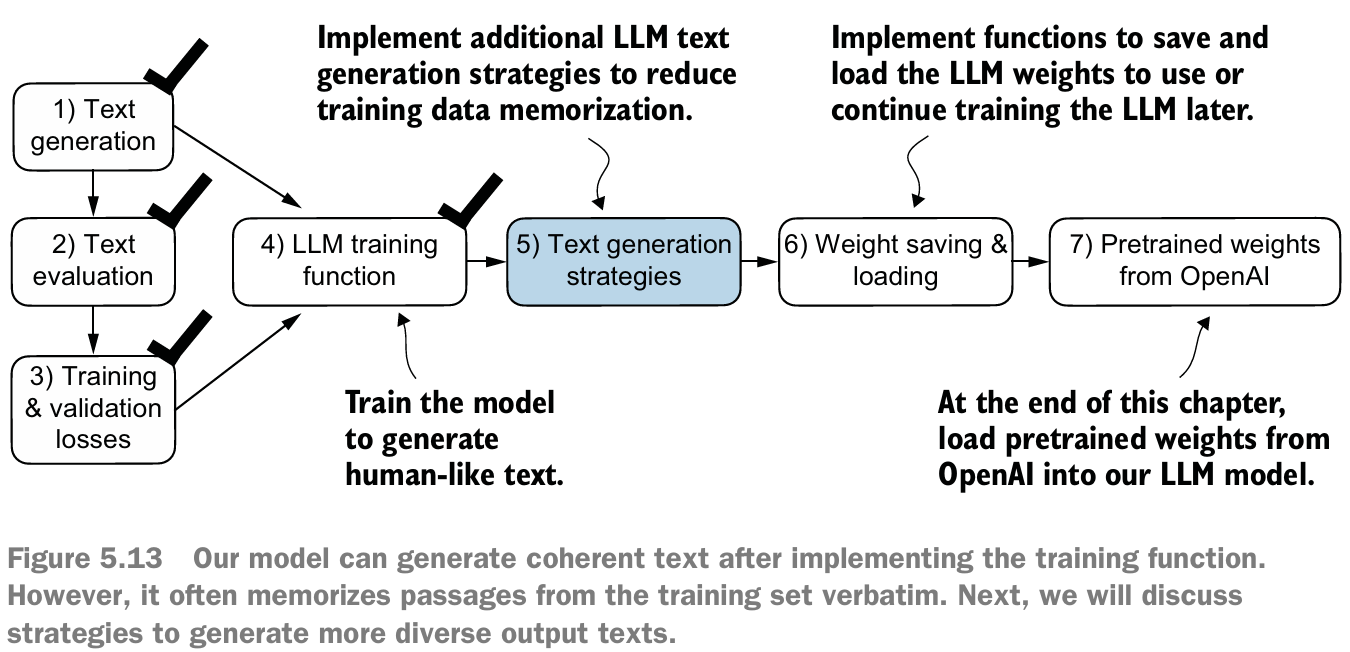

Conforme ilustrado na figura 5.13, cumprimos quatro dos nossos objetivos para este capítulo. Em seguida, abordaremos estratégias de geração de texto para LLMs para reduzir a memorização de dados de treinamento e aumentar a originalidade do texto gerado pelo LLM, antes de abordarmos o carregamento e o salvamento de pesos e o carregamento de pesos pré-treinados do modelo GPT da OpenAI.

## **3 - Estratégias de Decodificação para Controlar a Aleatoriedade**

Vamos analisar estratégias de geração de texto (também chamadas de estratégias de decodificação) para gerar texto mais original. Primeiro, revisitaremos brevemente a função `generate_text_simple` que usamos anteriormente em `generate_and_print_sample`. Em seguida, abordaremos duas técnicas, `escalonamento de temperatura` e `amostragem top-k`, para aprimorar essa função.

Começamos transferindo o modelo de volta da GPU para a CPU, já que a inferência com um modelo relativamente pequeno não requer uma GPU. Além disso, após o treinamento, colocamos o modelo em modo de avaliação para desativar componentes aleatórios, como dropout:

In [ ]:
model.to("cpu")
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_resid): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=76

Em seguida, conectamos a instância `GPTModel` (`model`) à função `generate_text_simple`, que usa o LLM para gerar um token por vez:

In [ ]:
# Obtém um tokenizador específico ("gpt2") usando tiktoken.
# Este tokenizador é compatível com o modelo GPT-2.
# O tokenizador é essencial para converter texto legível por humanos em IDs de token
# que o modelo pode processar, e para converter os IDs de token gerados pelo modelo
# de volta em texto.
tokenizer = tiktoken.get_encoding("gpt2")
# Chama a função auxiliar `generate_text_simple` para gerar texto usando o modelo.
# Esta função implementa a lógica passo a passo para gerar novos tokens
# com base em um contexto inicial.
token_ids = generate_text_simple(
    # model=model: Passa a instância do modelo GPT (que foi treinado anteriormente)
    # para a função de geração de texto. É este modelo que fará as previsões
    # sobre o próximo token.
    model=model,
    # idx=text_to_token_ids("Every effort moves you", tokenizer): Prepara a entrada
    # para a função de geração. Primeiro, a string "Every effort moves you"
    # é convertida em IDs de token usando a função auxiliar `text_to_token_ids`
    # e o tokenizador. O tensor resultante de IDs de token serve como o prompt
    # inicial para o modelo. A geração de texto começará a partir desta sequência.
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    # max_new_tokens=25: Especifica o número máximo de novos tokens que o modelo
    # deve gerar após o contexto inicial. A função de geração continuará adicionando
    # tokens à sequência até que este limite seja atingido.
    max_new_tokens=25,
    # context_size=GPT_CONFIG_124M["context_length"]: Passa o tamanho do contexto
    # configurado para o modelo. Isso garante que a função de geração de texto
    # respeite o comprimento máximo da sequência que o modelo foi treinado para lidar.
    # O modelo só pode usar informações dentro desta janela de contexto para fazer previsões.
    context_size=GPT_CONFIG_124M["context_length"]
)
# Imprime o texto de saída gerado pelo modelo.
# "Output text:\n": Um rótulo de texto para indicar que o que segue é o texto gerado.
# `token_ids_to_text(token_ids, tokenizer)`: Converte o tensor de IDs de token
# gerado pela função `generate_text_simple` de volta para uma string de texto
# legível por humanos usando a função auxiliar `token_ids_to_text` e o tokenizador.
# O resultado é a sequência de texto completa, incluindo o contexto inicial e os
# novos tokens gerados.
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you?"

"Yes--quite insensible to the irony. She wanted him vindicated--and by me!"




Conforme explicado anteriormente, o token gerado é selecionado em cada etapa de geração correspondente à maior pontuação de probabilidade entre todos os tokens no vocabulário. Isso significa que o LLM sempre gerará as mesmas saídas, mesmo se executarmos a função `generate_text_simple` anterior várias vezes no mesmo contexto inicial (`Every effort moves you`).

### **3.1 - Escala de Temperatura (Temperature Scaling)**

Vamos agora analisar o escalonamento de temperatura, uma técnica que adiciona um processo de seleção probabilística à tarefa de geração do próximo token. Anteriormente, dentro da função `generate_text_simple`, sempre amostramos o token com a maior probabilidade de ser o próximo token usando `torch.argmax`, também conhecido como ***decodificação gananciosa (greedy decoding)***. Para gerar texto com mais variedade, podemos substituir `argmax` por uma função que amostra a partir de uma distribuição de probabilidade (aqui, as pontuações de probabilidade que o LLM gera para cada entrada de vocabulário em cada etapa de geração de token).

Para ilustrar a amostragem probabilística com um exemplo concreto, vamos discutir brevemente o processo de geração do próximo token usando um vocabulário muito pequeno para fins ilustrativos:

In [ ]:
# Define um dicionário chamado `vocab`.
# Este dicionário mapeia palavras (tokens) para seus IDs de token correspondentes (números inteiros).
# Em modelos de linguagem, cada palavra ou subpalavra no vocabulário recebe um ID único.
# O modelo opera com esses IDs numéricos em vez das strings de texto diretamente.
# A estrutura é { "palavra": ID_do_token }.
vocab = {
    "closer": 0,  # A palavra "closer" é mapeada para o ID de token 0.
    "every": 1,   # A palavra "every" é mapeada para o ID de token 1.
    "effort": 2,  # A palavra "effort" é mapeada para o ID de token 2.
    "forward": 3, # A palavra "forward" é mapeada para o ID de token 3.
    "inches": 4,  # A palavra "inches" é mapeada para o ID de token 4.
    "moves": 5,   # A palavra "moves" é mapeada para o ID de token 5.
    "pizza": 6,   # A palavra "pizza" é mapeada para o ID de token 6.
    "toward": 7,  # A palavra "toward" é mapeada para o ID de token 7.
    "you": 8,     # A palavra "you" é mapeada para o ID de token 8.
}
# Cria um dicionário chamado `inverse_vocab`.
# Este dicionário é o inverso de `vocab`, mapeando IDs de token de volta para suas palavras correspondentes.
# Isso é útil para converter a saída numérica do modelo (IDs de token) de volta em texto legível por humanos.
# A estrutura é { ID_do_token: "palavra" }.
# {v: k for k, v in vocab.items()} é uma list comprehension de dicionário.
# Ela itera sobre os pares chave-valor (`k`, `v`) do dicionário `vocab` (`vocab.items()`).
# Para cada par, ela cria um novo par no `inverse_vocab` onde a chave é o valor (`v`) do `vocab`
# (o ID do token) e o valor é a chave (`k`) do `vocab` (a palavra).
inverse_vocab = {v: k for k, v in vocab.items()}

Em seguida, suponha que o LLM receba o contexto inicial **"every effort moves you"** e gere os seguintes logits de próximo token:

In [ ]:
# Cria um tensor PyTorch chamado `next_token_logits`.
# Um tensor é a estrutura de dados fundamental no PyTorch, similar a arrays NumPy.
# Este tensor contém os "logits" previstos pelo modelo para o próximo token.
# Logits são as pontuações de saída bruta do modelo, uma para cada token possível
# no vocabulário. Eles não são probabilidades, mas sim valores que serão convertidos
# em probabilidades usando uma função como softmax.
# O tensor é unidimensional, onde cada elemento corresponde a um token no vocabulário.
# A ordem dos logits neste tensor corresponde à ordem dos tokens no dicionário `vocab` definido anteriormente.
next_token_logits = torch.tensor(
    [4.51,  # Logit para o token com ID 0 ("closer")
     0.89,  # Logit para o token com ID 1 ("every")
    -1.90,  # Logit para o token com ID 2 ("effort")
     6.75,  # Logit para o token com ID 3 ("forward")
     1.63,  # Logit para o token com ID 4 ("inches")
    -1.62,  # Logit para o token com ID 5 ("moves")
    -1.89,  # Logit para o token com ID 6 ("pizza")
     6.28,  # Logit para o token com ID 7 ("toward")
     1.79]  # Logit para o token com ID 8 ("you")
)
# A magnitude do logit indica a "confiança" do modelo de que o token correspondente
# é o próximo na sequência. Valores mais altos de logit implicam em maior probabilidade
# após a aplicação do softmax. Por exemplo, 6.75 (para "forward") e 6.28 (para "toward")
# são os logits mais altos, sugerindo que o modelo acredita que "forward" ou "toward"
# são os próximos tokens mais prováveis.

Conforme discutido no capítulo 4, dentro de `generate_text_simple`, convertemos os logits em probabilidades por meio da função `softmax` e obtemos o ID do token correspondente ao token gerado por meio da função `argmax`, que podemos então mapear de volta para texto por meio do vocabulário inverso:

In [ ]:
# Aplica a função softmax aos logits.
# torch.softmax() converte um tensor de pontuações brutas (logits) em uma distribuição de probabilidade.
# Cada elemento na saída é um valor entre 0 e 1, e a soma de todos os elementos é 1.
# Isso transforma os logits que podem ter qualquer valor real em probabilidades que podem ser interpretadas.
# - next_token_logits: O tensor de logits de entrada.
# - dim=0: Especifica a dimensão ao longo da qual o softmax será calculado.
#          Neste caso, como `next_token_logits` é um tensor unidimensional, `dim=0`
#          aplica o softmax a todos os elementos do tensor. Se o tensor fosse bidimensional
#          (por exemplo, representando um lote de exemplos), você escolheria a dimensão
#          que corresponde ao vocabulário.
probas = torch.softmax(next_token_logits, dim=0)
# Encontra o índice (ID do token) com a maior probabilidade.
# torch.argmax() retorna o índice do maior valor ao longo de uma dimensão especificada.
# Neste caso, como `probas` é unidimensional (após o softmax), `torch.argmax(probas)`
# retorna o índice do elemento com a maior probabilidade. Este índice corresponde
# ao ID do token que o modelo prevê ser o mais provável.
# `.item()`: Extrai o valor escalar de um tensor PyTorch de um único elemento.
#            torch.argmax() retorna um tensor contendo um único valor, e `.item()`
#            converte este tensor para um tipo numérico padrão do Python.
next_token_id = torch.argmax(probas).item()
# Imprime a palavra correspondente ao ID do token previsto.
# inverse_vocab: O dicionário que mapeia IDs de token de volta para palavras.
# inverse_vocab[next_token_id]: Usa o ID do token encontrado no passo anterior como chave
#                               para procurar a palavra correspondente no dicionário `inverse_vocab`.
# print(...): Exibe a palavra encontrada no console.
print(inverse_vocab[next_token_id])

forward


Como o maior valor logit e, consequentemente, a maior pontuação de probabilidade softmax estão na quarta posição (posição de índice 3, já que Python usa indexação 0), a palavra gerada é **"forward"**.

Para implementar um processo de amostragem probabilística, podemos agora substituir `argmax` pela função `multinomial` no PyTorch:

In [ ]:
# Define a semente para o gerador de números aleatórios do PyTorch.
# Isso garante que a amostragem probabilística usando `torch.multinomial`
# seja reproduzível. Se você executar este código com a mesma semente,
# obterá a mesma sequência de números aleatórios e, portanto, o mesmo resultado de amostragem.
torch.manual_seed(123)
# Realiza a amostragem probabilística a partir da distribuição de probabilidades.
# torch.multinomial() sorteia `num_samples` elementos de um tensor de entrada,
# onde a probabilidade de sortear cada elemento é dada pelos valores no tensor de entrada.
# - probas: O tensor de probabilidades (resultante da aplicação do softmax aos logits).
#           Este tensor representa a distribuição de probabilidade sobre o vocabulário
#           para o próximo token. A soma de seus elementos deve ser 1.
# - num_samples=1: Especifica quantos elementos (IDs de token) devem ser sorteados.
#                  Neste caso, queremos sortear apenas um único token.
# O resultado é um tensor contendo os IDs dos tokens sorteados.
# `.item()`: Extrai o valor escalar do tensor resultante (que contém apenas um elemento)
#            e o converte para um tipo numérico padrão do Python.
next_token_id = torch.multinomial(probas, num_samples=1).item()
# Imprime a palavra correspondente ao ID do token sorteado.
# inverse_vocab: O dicionário que mapeia IDs de token de volta para palavras.
# inverse_vocab[next_token_id]: Usa o ID do token sorteado como chave para
#                               procurar a palavra correspondente no dicionário `inverse_vocab`.
# print(...): Exibe a palavra encontrada no console.
print(inverse_vocab[next_token_id])

forward


A saída impressa é **"forward"**, assim como antes. O que aconteceu? A função `multinomial` amostra o próximo token proporcionalmente à sua pontuação de probabilidade. Em outras palavras, **"forward"** ainda é o token mais provável e será selecionado por `multinomial` na maioria das vezes, mas não o tempo todo. Para ilustrar isso, vamos implementar uma função que repete essa amostragem 1.000 vezes:

In [ ]:
# Define uma função para amostrar tokens a partir de uma distribuição de probabilidades e imprimir suas frequências.
#
# Parâmetros:
# - probas: Um tensor PyTorch contendo a distribuição de probabilidade sobre o vocabulário
#           para o próximo token. A soma de seus elementos deve ser 1.
def print_sampled_tokens(probas):
    # Define a semente para o gerador de números aleatórios do PyTorch dentro da função.
    # Isso garante que as amostragens realizadas dentro desta função sejam reproduzíveis
    # cada vez que a função é chamada.
    torch.manual_seed(123)
    # Realiza a amostragem de 1000 tokens a partir da distribuição de probabilidades.
    # [torch.multinomial(probas, num_samples=1).item() for i in range(1_000)]:
    # - range(1_000): Cria uma sequência de números de 0 a 999, indicando que o loop
    #   será executado 1000 vezes.
    # - torch.multinomial(probas, num_samples=1): Em cada iteração, sorteia um único
    #   elemento (um ID de token) do tensor `probas` com probabilidades dadas pelos
    #   valores em `probas`.
    # - .item(): Extrai o valor escalar (o ID do token sorteado) do tensor resultante.
    # - [...] (List Comprehension): Coleta os IDs de token sorteados em cada iteração
    #   em uma lista Python chamada `sample`.
    sample = [torch.multinomial(probas, num_samples=1).item()
              for i in range(1_000)]
    # Conta a frequência de cada ID de token sorteado na lista `sample`.
    # torch.tensor(sample): Converte a lista Python `sample` em um tensor PyTorch.
    # torch.bincount(...): Conta o número de ocorrências de cada valor inteiro não negativo
    #                      no tensor de entrada. O resultado é um tensor onde o índice
    #                      corresponde ao ID do token e o valor corresponde à sua frequência.
    # Por exemplo, se o ID do token 3 apareceu 500 vezes, `sampled_ids[3]` será 500.
    sampled_ids = torch.bincount(torch.tensor(sample))
    # Itera sobre os IDs de token que foram amostrados e suas frequências.
    # enumerate(sampled_ids): Retorna pares de (índice, valor) para o tensor `sampled_ids`.
    # - i: O índice, que corresponde ao ID do token.
    # - freq: O valor no índice `i`, que corresponde à frequência com que o token `i` foi amostrado.
    for i, freq in enumerate(sampled_ids):
        # Imprime a frequência e a palavra correspondente para cada ID de token amostrado.
        # f"{freq} x {inverse_vocab[i]}": Um f-string que formata a saída.
        # - {freq}: Exibe a frequência de amostragem do token.
        # - " x ": Um separador.
        # - {inverse_vocab[i]}: Usa o ID do token `i` para procurar a palavra correspondente
        #   no dicionário `inverse_vocab` e exibe a palavra.
        print(f"{freq} x {inverse_vocab[i]}")

# Chama a função `print_sampled_tokens` para executar o processo de amostragem e impressão.
# Passamos o tensor `probas` (a distribuição de probabilidade calculada anteriormente)
# como entrada para a função.
print_sampled_tokens(probas)

73 x closer
0 x every
0 x effort
582 x forward
2 x inches
0 x moves
0 x pizza
343 x toward


Como podemos ver, a palavra **forward** é amostrada na maioria das vezes (582 de 1.000 vezes), mas outros tokens, como **closer**, **inches** e **toward**, também serão amostrados algumas vezes. Isso significa que, se substituíssemos a função `argmax` pela função `multinomial` dentro da função `generate_and_print_sample`, o LLM às vezes geraria textos como **every effort moves you toward, every effort moves you inches** e **every effort moves you closer** em vez de **every effort moves you forward**.

Podemos controlar ainda mais o processo de distribuição e seleção por meio de um conceito chamado ***Escala de Temperatura (Temperature Scaling)**. A escala de temperatura é apenas uma descrição sofisticada para dividir os logits por um número maior que 0:

In [ ]:
# Define uma função para aplicar a função softmax com escalonamento de temperatura aos logits.
# O escalonamento de temperatura é uma técnica usada em modelos de linguagem para controlar
# a aleatoriedade das previsões. Uma temperatura mais alta torna a distribuição de probabilidade
# mais suave (mais aleatória), enquanto uma temperatura mais baixa a torna mais nítida (mais determinística).
#
# Parâmetros:
# - logits: Um tensor PyTorch contendo os logits (pontuações brutas de saída) do modelo.
#           Estes são os valores antes de serem convertidos em probabilidades.
# - temperature: Um valor numérico (float) que controla a temperatura.
#                Deve ser maior que 0. Valores comuns estão entre 0.5 e 1.5.
#                temperature = 1.0 é equivalente ao softmax padrão.
def softmax_with_temperature(logits, temperature):
    # Escala os logits dividindo-os pela temperatura.
    # Se temperature > 1, os logits escalados serão menores em magnitude, tornando a
    # distribuição de probabilidade mais uniforme após o softmax (maior aleatoriedade).
    # Se temperature < 1, os logits escalados serão maiores em magnitude, tornando a
    # distribuição de probabilidade mais acentuada após o softmax (menor aleatoriedade).
    scaled_logits = logits / temperature
    # Aplica a função softmax aos logits escalados.
    # torch.softmax() converte o tensor de logits escalados em uma distribuição de probabilidade.
    # Cada elemento na saída é um valor entre 0 e 1, e a soma de todos os elementos é 1.
    # - scaled_logits: O tensor de logits após serem divididos pela temperatura.
    # - dim=0: Especifica a dimensão ao longo da qual o softmax será calculado.
    #          Neste caso, assume-se que a última dimensão dos logits corresponde
    #          ao vocabulário, mas para este exemplo unidimensional, `dim=0`
    #          aplica o softmax a todos os elementos. Em um LLM completo,
    #          você usaria `dim=-1`.
    return torch.softmax(scaled_logits, dim=0)

Temperaturas maiores que 1 resultam em probabilidades de token distribuídas de forma mais uniforme, e temperaturas menores que 1 resultam em distribuições mais confiáveis ​​(mais nítidas ou com mais picos). Vamos ilustrar isso plotando as probabilidades originais juntamente com probabilidades escalonadas com diferentes valores de temperatura:

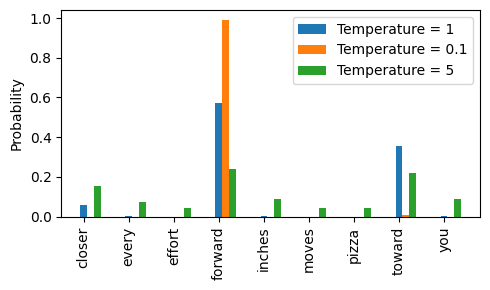

In [ ]:
# Define uma lista de diferentes valores de temperatura a serem usados para visualização.
# temperature = 1: Temperatura padrão, equivalente ao softmax normal.
# temperature = 0.1: Temperatura baixa, tornando a distribuição de probabilidade mais acentuada.
# temperature = 5: Temperatura alta, tornando a distribuição de probabilidade mais uniforme.
temperatures = [1, 0.1, 5]
# Calcula as probabilidades escaladas para cada temperatura definida na lista `temperatures`.
# [softmax_with_temperature(next_token_logits, T) for T in temperatures]:
# - Loop de list comprehension que itera sobre cada valor `T` na lista `temperatures`.
# - Em cada iteração, chama a função `softmax_with_temperature` com os logits originais
#   (`next_token_logits`) e a temperatura atual `T`.
# - O resultado de cada chamada (um tensor de probabilidades escaladas) é coletado em uma lista
#   chamada `scaled_probas`. Esta lista conterá um tensor de probabilidades para cada temperatura.
scaled_probas = [softmax_with_temperature(next_token_logits, T)
                 for T in temperatures]
# Cria um tensor PyTorch que representa os índices dos tokens no vocabulário.
# torch.arange(len(vocab)): Gera uma sequência de números inteiros de 0 até len(vocab) - 1.
# Este tensor será usado como as posições no eixo x do gráfico de barras.
# Cada índice corresponde a um token específico no dicionário `vocab`.
x = torch.arange(len(vocab))
# Define a largura de cada barra no gráfico.
# Um valor menor que 1.0 permite que as barras de diferentes temperaturas para o mesmo token
# sejam plotadas lado a lado sem sobreposição.
bar_width = 0.15
# Cria uma figura e um conjunto de eixos para o gráfico.
# fig é o objeto Figure (a janela ou página inteira).
# ax é o objeto Axes (a área onde os dados são plotados).
# figsize=(5, 3) define o tamanho da figura em polegadas (largura x altura).
fig, ax = plt.subplots(figsize=(5, 3))
# Loop que itera sobre os valores de temperatura e suas probabilidades escaladas correspondentes.
# enumerate(temperatures): Fornece pares de (índice, valor) para a lista `temperatures`.
# - i: O índice da temperatura na lista (0, 1, 2).
# - T: O valor da temperatura (1, 0.1, 5).
# zipped_data = zip(temperatures, scaled_probas): Cria um iterador que combina
# elementos de `temperatures` e `scaled_probas` em pares (T, probas_para_T).
# O loop `for T, probas in zipped_data:` itera sobre esses pares.
for i, T in enumerate(temperatures):
    # Plota um conjunto de barras para a temperatura atual.
    # ax.bar(...): Cria um gráfico de barras.
    # x + i * bar_width: Define as posições centrais das barras no eixo x.
    #                    Para cada token (dado por `x`), as barras são deslocadas
    #                    horizontalmente com base no índice `i` da temperatura e na `bar_width`,
    #                    colocando as barras de diferentes temperaturas lado a lado para o mesmo token.
    # scaled_probas[i]: O tensor de probabilidades escaladas para a temperatura atual.
    #                   Estes valores definem a altura de cada barra.
    # bar_width: Define a largura de cada barra.
    # label=f'Temperature = {T}': Define o rótulo para este conjunto de barras na legenda do gráfico.
    rects = ax.bar(x + i * bar_width, scaled_probas[i],
                   bar_width, label=f'Temperature = {T}')

# Define o rótulo para o eixo y do gráfico.
ax.set_ylabel('Probability')
# Define as posições dos ticks principais no eixo x para corresponder aos índices dos tokens.
ax.set_xticks(x)
# Define os rótulos dos ticks no eixo x para serem os nomes das palavras do vocabulário.
# vocab.keys(): Obtém uma view das chaves (palavras) do dicionário `vocab`.
# rotation=90: Rotaciona os rótulos do eixo x em 90 graus para evitar sobreposição,
#              especialmente com vocabulários maiores ou nomes de palavras longos.
ax.set_xticklabels(vocab.keys(), rotation=90)
# Exibe a legenda no gráfico.
# A legenda mostra qual cor de barra corresponde a qual temperatura.
ax.legend()
# Ajusta automaticamente os parâmetros de subplot para que o layout da figura fique apertado.
# Isso ajuda a evitar que rótulos ou títulos se sobreponham à área de plotagem.
plt.tight_layout()
# Exibe a figura plotada.
plt.show()

Uma temperatura de 1 divide os logits por 1 antes de passá-los para a função `softmax` para calcular as pontuações de probabilidade. Em outras palavras, usar uma temperatura de 1 é o mesmo que não usar nenhuma escala de temperatura. Nesse caso, os tokens são selecionados com uma probabilidade igual às pontuações de probabilidade do softmax original por meio da função de amostragem `multinomial` no PyTorch. Por exemplo, para a configuração de temperatura 1, o token correspondente a **“forward”** seria selecionado em cerca de 60% das vezes, como podemos ver na figura 5.14.

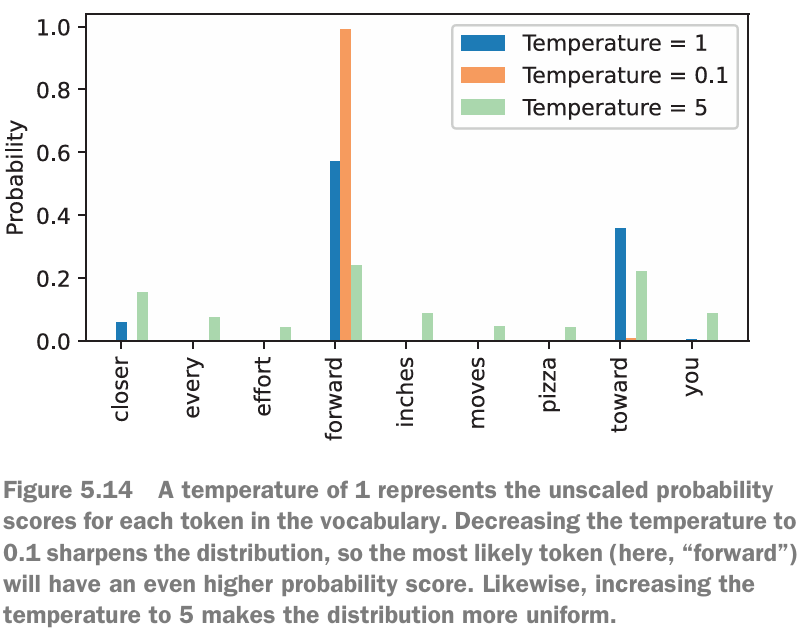

Além disso, como podemos ver na Figura 5.14, a aplicação de temperaturas muito baixas, como 0,1, resultará em distribuições mais precisas, de modo que o comportamento da função `multinomial`
seleciona o token mais provável (aqui, **"forward"**) quase 100% das vezes, aproximando-se do comportamento da função `argmax`. Da mesma forma, uma temperatura de 5 resulta em uma distribuição mais uniforme, onde outros tokens são selecionados com mais frequência. Isso pode adicionar mais variedade aos textos gerados, mas também resulta, com mais frequência, em textos sem sentido. Por exemplo, usar a temperatura de 5 resulta em textos como **"every effort moves you pizza"** em cerca de 4% das vezes.

---

Exercício 5.1

Use a função `print_sampled_tokens` para imprimir as frequências de amostragem das probabilidades softmax escalonadas com as temperaturas mostradas na figura 5.14. Com que frequência a palavra `pizza` é amostrada em cada caso? Você consegue pensar em uma maneira mais rápida e precisa de determinar com que frequência a palavra `pizza` é amostrada?

---

### **Amostragem Top-k**

Implementamos uma abordagem de amostragem probabilística acoplada à escala de temperatura para aumentar a diversidade dos resultados. Observamos que valores de temperatura mais altos resultam em probabilidades do próximo token mais uniformemente distribuídas, o que resulta em resultados mais diversos, pois reduz a probabilidade de o modelo selecionar repetidamente o token mais provável. Esse método permite a exploração de caminhos menos prováveis, mas potencialmente mais interessantes e criativos no processo de geração. No entanto, uma desvantagem dessa abordagem é que ela às vezes leva a resultados gramaticalmente incorretos ou completamente sem sentido, como **"every effort moves you pizza"**.

A ***amostragem top-k***, quando combinada com amostragem probabilística e escalonamento de temperatura, pode melhorar os resultados da geração de texto. Na amostragem top-k, podemos restringir os tokens amostrados aos k tokens mais prováveis ​​e excluir todos os outros tokens do processo de seleção, mascarando suas pontuações de probabilidade, conforme ilustrado na Figura 5.15.

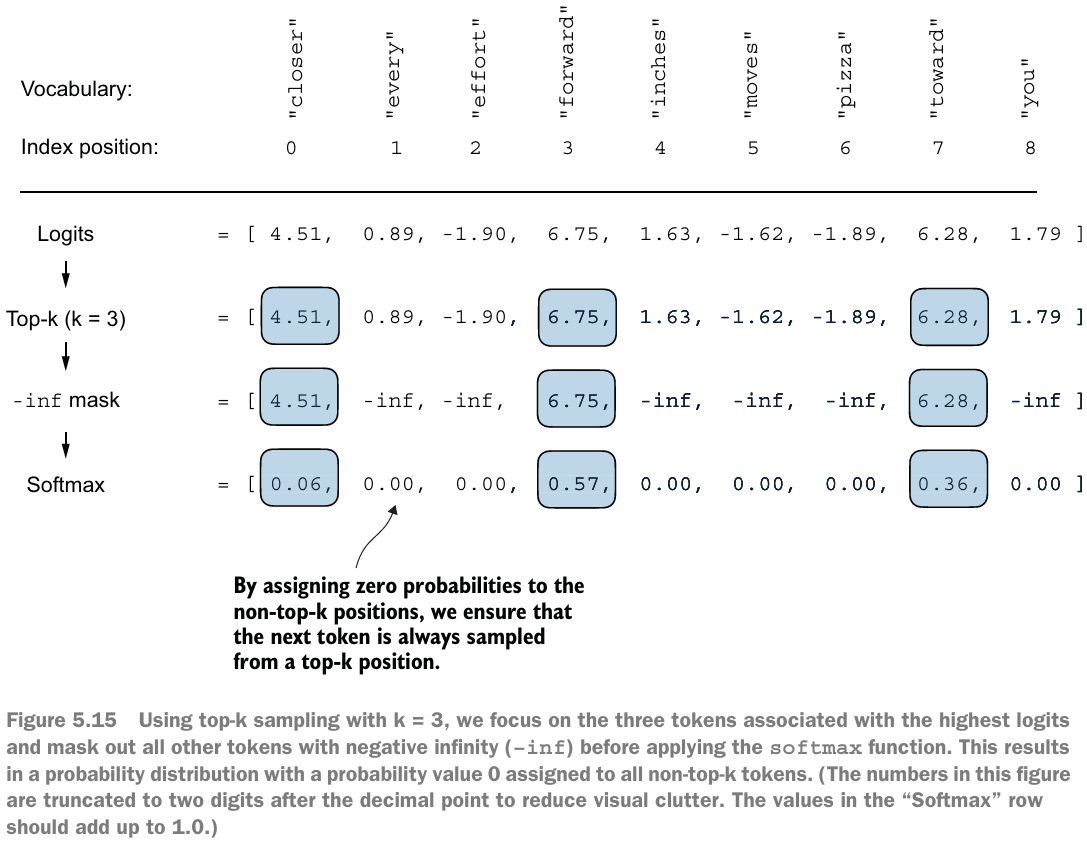

A abordagem top-k substitui todos os logits não selecionados por valores de infinito negativo (`-inf`), de forma que, ao calcular os valores softmax, as pontuações de probabilidade dos tokens não top-k sejam 0 e as probabilidades restantes somem 1. (Leitores atentos podem se lembrar deste truque de mascaramento do módulo de atenção causal que implementamos no Capítulo 3, seção 3.5.1.)

Em código, podemos implementar o procedimento top-k da Figura 5.15 da seguinte forma, começando com a seleção dos tokens com os maiores valores de logit. Os valores de logits e IDs de token dos três principais tokens, em ordem decrescente, são:

In [ ]:
# Define o valor de 'k' para a amostragem Top-k.
# Top-k restringe a amostragem aos k tokens mais prováveis.
top_k = 3
# Usa torch.topk para encontrar os k maiores valores (logits) e seus índices (posições).
# - next_token_logits: O tensor de logits de onde queremos selecionar os maiores valores.
# - top_k: O número de maiores valores a serem selecionados.
# - dim=-1: Especifica a dimensão ao longo da qual encontrar os maiores valores.
#           Em um tensor de logits de um LLM, a última dimensão (-1) corresponde
#           ao vocabulário. Neste exemplo unidimensional, dim=-1 ou dim=0
#           resultam no mesmo comportamento.
# torch.topk retorna uma tupla: (valores, índices).
# - top_logits: Um tensor contendo os `top_k` maiores valores de logit.
# - top_pos: Um tensor contendo os índices (IDs de token) correspondentes aos `top_k` maiores valores de logit.
top_logits, top_pos = torch.topk(next_token_logits, top_k, dim=-1)
# Imprime os valores dos logits selecionados (os k mais altos).
# Estes são os logits brutos para os tokens mais prováveis.
print("Top logits:", top_logits)
# Imprime as posições (IDs de token) dos logits selecionados.
# Estes são os IDs dos k tokens mais prováveis de acordo com o modelo.
print("Top positions:", top_pos)

Top logits: tensor([6.7500, 6.2800, 4.5100])
Top positions: tensor([3, 7, 0])


Em seguida, aplicamos a função `where` do PyTorch para definir os valores de logit dos tokens que estão abaixo do menor valor de logit dentro da nossa seleção dos três primeiros para infinito negativo (`-inf`). Os logits resultantes para o próximo token no vocabulário de nove tokens são:

In [ ]:
# Aplica uma máscara aos logits para implementar a amostragem Top-k.
# torch.where() é uma função que seleciona elementos de dois tensores de entrada
# com base em uma condição booleana.
#
# Parâmetros:
# - condition: Um tensor booleano (com a mesma forma do `next_token_logits`).
#              Para cada elemento, se a condição for True, o elemento correspondente
#              será selecionado do tensor `input`. Se a condição for False,
#              o elemento correspondente será selecionado do tensor `other`.
#              Neste caso, a condição é `next_token_logits < top_logits[-1]`.
#              `top_logits[-1]` obtém o menor valor entre os top-k logits (porque `top_logits`
#              é ordenado decrescentemente). A condição é True para todos os logits
#              que são menores que o menor dos top-k logits (ou seja, todos os logits
#              que NÃO estão entre os top-k).
# - input: O tensor de onde selecionar elementos quando a condição é True.
#          Aqui, `torch.tensor(float('-inf'))` cria um tensor contendo o valor de
#          infinito negativo para todos os elementos. Isso significa que, para os logits
#          que não estão entre os top-k (onde a condição é True), seus valores serão
#          substituídos por infinito negativo. Quando o softmax for aplicado a esses
#          novos logits, os tokens correspondentes terão probabilidade zero.
# - other: O tensor de onde selecionar elementos quando a condição é False.
#          Aqui, `next_token_logits` é o tensor original de logits. Isso significa que,
#          para os logits que estão entre os top-k (onde a condição é False), seus
#          valores originais são mantidos.
new_logits = torch.where(
    condition=next_token_logits < top_logits[-1],
    input=torch.tensor(float('-inf')),
    other=next_token_logits
)

# Imprime o tensor resultante `new_logits`.
# Este tensor agora contém os logits originais para os top-k tokens,
# e infinito negativo para todos os outros tokens. Isso efetivamente "mascara"
# os tokens menos prováveis antes de calcular as probabilidades.
print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


Por fim, vamos aplicar a função `softmax` para transformá-las em probabilidades do próximo token. Como podemos ver, o resultado dessa abordagem dos três primeiros são três pontuações de probabilidade diferentes de zero:

In [ ]:
topk_probas = torch.softmax(new_logits, dim=0)
print(topk_probas)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


Agora podemos aplicar a escala de temperatura e a função multinomial à amostragem probabilística para selecionar o próximo token entre essas três pontuações de probabilidade diferentes de zero para gerar o próximo token. Fazemos isso modificando a função de geração de texto.

### **3.3 - Modificando a Função de Geração de Texto**

Agora, vamos combinar a amostragem de temperatura e a amostragem top-k para modificar a função `generate_ text_simple` que usamos para gerar texto por meio do LLM anteriormente, criando uma nova função `generate`.

In [ ]:
# Define uma função para gerar texto usando o modelo GPT com opções de escalonamento de temperatura e amostragem top-k.
# Esta função gera texto token por token, com base em um contexto inicial.
#
# Parâmetros:
# - model: A instância do modelo PyTorch (GPTModel) a ser usado para gerar texto.
# - idx: Um tensor PyTorch contendo os IDs de token do contexto inicial.
#        A forma deve ser (batch_size, initial_sequence_length).
# - max_new_tokens: O número máximo de novos tokens a serem gerados. O processo de geração
#                   parará após gerar este número de tokens, a menos que um token de fim
#                   de sequência (eos_id) seja gerado antes.
# - context_size: O comprimento máximo da sequência de entrada que o modelo pode lidar.
#                 Isso é usado para limitar o contexto que o modelo vê a cada passo.
# - temperature: Um valor numérico (float) para controlar a aleatoriedade da amostragem.
#                Se temperature > 0.0, o softmax é aplicado aos logits escalados.
#                Se temperature <= 0.0, a amostragem gulosa (greedy, usando argmax) é usada.
#                Um valor de 1.0 é o comportamento padrão do softmax. Valores maiores aumentam a aleatoriedade.
#                O valor padrão é 0.0 (amostragem gulosa).
# - top_k: Um número inteiro opcional. Se especificado, restringe a amostragem aos `top_k`
#          tokens com os logits mais altos em cada passo. Tokens fora do top-k são descartados
#          antes de calcular as probabilidades. Se None, todos os tokens são considerados.
# - eos_id: Um número inteiro opcional representando o ID do token de fim de sequência.
#           Se especificado, a geração para quando este token é amostrado.
def generate(model, idx, max_new_tokens, context_size,
             temperature=0.0, top_k=None, eos_id=None):

    # Loop principal de geração de texto. Itera para gerar até `max_new_tokens`.
    # O "_" indica que não precisamos da variável de iteração neste loop.
    for _ in range(max_new_tokens):
       # Seleciona os últimos `context_size` tokens da sequência atual (`idx`).
       # Isso garante que a entrada para o modelo não exceda o comprimento máximo do contexto
       # com o qual o modelo foi treinado. `[:, -context_size:]` usa fatiamento:
       # `:` seleciona todas as linhas (exemplos no lote).
       # `-context_size:` seleciona os elementos da última dimensão a partir do índice `-context_size` até o final.
       idx_cond = idx[:, -context_size:]

       # Desativa o cálculo de gradientes. Isso é essencial para a inferência (geração de texto),
       # pois não precisamos calcular gradientes para otimizar os pesos do modelo durante a geração.
       # Economiza memória e acelera a execução.
       with torch.no_grad():
          # Passa o contexto de entrada condicionado (`idx_cond`) para o modelo.
          # O modelo processa esta sequência e retorna os logits (pontuações brutas de saída)
          # para cada posição na sequência de entrada, prevendo o próximo token para cada posição.
          # A forma de `logits` será (batch_size, sequence_length, vocab_size).
          logits = model(idx_cond)

       # Seleciona os logits correspondentes ao último token na sequência.
       # No pipeline de modelagem de linguagem, o modelo prevê o próximo token
       # com base em todos os tokens anteriores. Portanto, estamos interessados apenas
       # na previsão para a última posição de token na sequência de entrada.
       # `[:, -1, :]` usa fatiamento:
       # `:` seleciona todas as linhas (exemplos no lote).
       # `-1` seleciona o último elemento na segunda dimensão (a dimensão da sequência).
       # `:` seleciona todos os elementos na última dimensão (a dimensão do vocabulário).
       # A forma resultante de `logits` será (batch_size, vocab_size).
       logits = logits[:, -1, :]

       # Implementa a amostragem Top-k, se `top_k` for especificado.
       if top_k is not None:
           # Encontra os `top_k` maiores logits e seus índices para cada exemplo no lote.
           # torch.topk() retorna uma tupla de (valores, índices).
           # `_` é usado para descartar os índices, pois só precisamos dos valores dos logits principais.
           # `dim=-1` especifica para encontrar os maiores valores ao longo da última dimensão (vocabulário).
           top_logits, _ = torch.topk(logits, top_k, dim=-1)
           # Obtém o menor valor entre os `top_k` logits.
           # `top_logits` é ordenado decrescentemente, então o menor valor é o último elemento.
           # `[:, -1]` seleciona a última coluna para todos os exemplos no lote.
           # `.unsqueeze(1)` adiciona uma dimensão extra para que `min_val` possa ser transmitido (broadcast)
           # corretamente com `logits` na operação `torch.where`.
           min_val = top_logits[:, -1].unsqueeze(1)
           # Aplica uma máscara aos logits: substitui os logits que são menores que `min_val`
           # (ou seja, aqueles que não estão entre os top-k) por infinito negativo.
           # torch.where() seleciona entre dois tensores com base em uma condição.
           # - condition: `logits < min_val`. True para logits que são menores que o menor logit top-k.
           # - input: `torch.tensor(float('-inf')).to(logits.device)`. O valor a usar quando a condição é True (infinito negativo).
           #          `.to(logits.device)` garante que este tensor esteja no mesmo dispositivo que `logits`.
           # - other: `logits`. O valor a usar quando a condição é False (os logits originais dos top-k tokens).
           logits = torch.where(
               logits < min_val,
               torch.tensor(float('-inf')).to(logits.device),
               logits
           )

       # Implementa a amostragem com escalonamento de temperatura ou amostragem gulosa.
       if temperature > 0.0:
           # Escala os logits dividindo-os pela temperatura.
           # Uma temperatura maior suaviza a distribuição (aumenta a aleatoriedade).
           # Uma temperatura menor acentua a distribuição (reduz a aleatoriedade).
           logits = logits / temperature
           # Converte os logits (escalados ou não) em probabilidades usando a função softmax.
           # torch.softmax() garante que os valores resultantes sejam entre 0 e 1 e somem 1.
           # `dim=-1` especifica para aplicar o softmax ao longo da dimensão do vocabulário.
           probs = torch.softmax(logits, dim=-1)
           # Realiza a amostragem probabilística a partir da distribuição de probabilidades.
           # torch.multinomial() sorteia um token (`num_samples=1`) com probabilidades dadas por `probs`.
           # O resultado é um tensor contendo o ID do token amostrado.
           idx_next = torch.multinomial(probs, num_samples=1)

       else:
           # Realiza a amostragem gulosa (greedy decoding) se a temperatura for 0 ou negativa.
           # torch.argmax() seleciona o token com a maior probabilidade (o maior logit).
           # `dim=-1` especifica para encontrar o índice do maior valor ao longo da dimensão do vocabulário.
           # `keepdim=True` mantém a dimensão original com tamanho 1.
           idx_next = torch.argmax(logits, dim=-1, keepdim=True)

       # Verifica se o token amostrado é o token de fim de sequência, se especificado.
       if eos_id is not None and idx_next == eos_id:
           # Se for o token de fim de sequência, para o loop de geração.
           break

       # Concatena o token gerado (`idx_next`) à sequência atual (`idx`).
       # torch.cat() junta os tensores ao longo de uma dimensão especificada.
       # `dim=1` especifica para juntar ao longo da segunda dimensão (a dimensão da sequência).
       # Isso estende a sequência atual com o novo token gerado.
       idx = torch.cat((idx, idx_next), dim=1)

    # Retorna o tensor contendo a sequência completa de IDs de token gerada,
    # incluindo o contexto inicial e os novos tokens gerados.
    return idx

Vamos agora ver esta nova função generate em ação:

In [ ]:
# Define a semente para o gerador de números aleatórios do PyTorch.
# Isso garante que a geração de texto, que envolve amostragem probabilística
# (se temperature > 0 ou top_k é usado), seja reproduzível.
# Se você executar este código com a mesma semente, obterá os mesmos resultados
# de geração de texto.
torch.manual_seed(123)
# Chama a função `generate` para gerar texto usando o modelo treinado.
# Esta função implementa a lógica para gerar novos tokens passo a passo,
# com opções para controlar a aleatoriedade (temperatura e top-k).
token_ids = generate(
    # model=model: Passa a instância do modelo GPT (treinado) para a função de geração.
    # É este modelo que fará as previsões sobre o próximo token.
    model=model,
    # idx=text_to_token_ids("Every effort moves you", tokenizer): Prepara a entrada
    # para a função de geração. A string "Every effort moves you" é convertida
    # em IDs de token usando o tokenizer, servindo como o prompt inicial.
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    # max_new_tokens=15: Especifica o número máximo de novos tokens a serem gerados
    # após o contexto inicial. A geração para quando este limite é atingido.
    max_new_tokens=15,
    # context_size=GPT_CONFIG_124M["context_length"]: Passa o tamanho do contexto
    # configurado para o modelo. A função de geração usará apenas os últimos
    # `context_size` tokens do contexto atual para fazer a próxima previsão.
    context_size=GPT_CONFIG_124M["context_length"],
    # top_k=25: Especifica que a amostragem será restrita aos 25 tokens
    # com os logits mais altos em cada passo de geração. Isso ajuda a evitar
    # a amostragem de tokens muito improváveis.
    top_k=25,
    # temperature=1.4: Define a temperatura para o escalonamento de temperatura.
    # Um valor de 1.4 (maior que 1) torna a distribuição de probabilidade sobre
    # os tokens mais uniforme, aumentando a aleatoriedade e a diversidade
    # do texto gerado em comparação com a amostragem gulosa ou temperaturas mais baixas.
    temperature=1.4
)
# Imprime o texto de saída gerado pelo modelo.
# "Output text:\n": Um rótulo para a saída.
# `token_ids_to_text(token_ids, tokenizer)`: Converte o tensor de IDs de token
# gerado pela função `generate` de volta para uma string de texto legível
# usando o tokenizer. O resultado inclui o contexto inicial e os novos tokens.
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you?"
His up surprise. And whenever his glory, when by his head


Como podemos ver, o texto gerado é muito diferente daquele que geramos anteriormente por meio da função `generate_simple` na seção 5.3 (**"Every effort moves you know," was one of the axioms he laid...!**), que era uma passagem memorizada do conjunto de treinamento.

---

$\large \textbf{Exercício 5.2}$

Experimente diferentes temperaturas e configurações de top-k. Com base em suas observações, você consegue pensar em aplicações em que configurações de temperatura e top-k mais baixas são desejadas? Da mesma forma, você consegue pensar em aplicações em que configurações de temperatura e top-k mais altas são preferíveis? (Recomenda-se também revisitar este exercício no final do capítulo, após carregar os pesos pré-treinados do OpenAI.)

$\large \textbf{Exercício 5.3}$

Quais são as diferentes combinações de configurações para a função `generate` forçar o comportamento determinístico, ou seja, desabilitar a amostragem aleatória de forma que ela sempre produza as mesmas saídas, semelhantes à função `generate_simple`?

---

## **4 - Carregando e Salvando Pesos de Modelos no PyTorch**

Até agora, discutimos como avaliar numericamente o progresso do treinamento e pré-treinar um LLM do zero. Embora tanto o LLM quanto o conjunto de dados fossem relativamente pequenos, este exercício mostrou que o pré-treinamento de LLMs é computacionalmente caro. Portanto, é importante poder salvar o LLM para que não tenhamos que executar o treinamento novamente sempre que quisermos usá-lo em uma nova sessão.

Então, vamos discutir como salvar e carregar um modelo pré-treinado, conforme destacado na Figura 5.16. Posteriormente, carregaremos um modelo GPT pré-treinado mais capaz do OpenAI em nossa instância `GPTModel`.

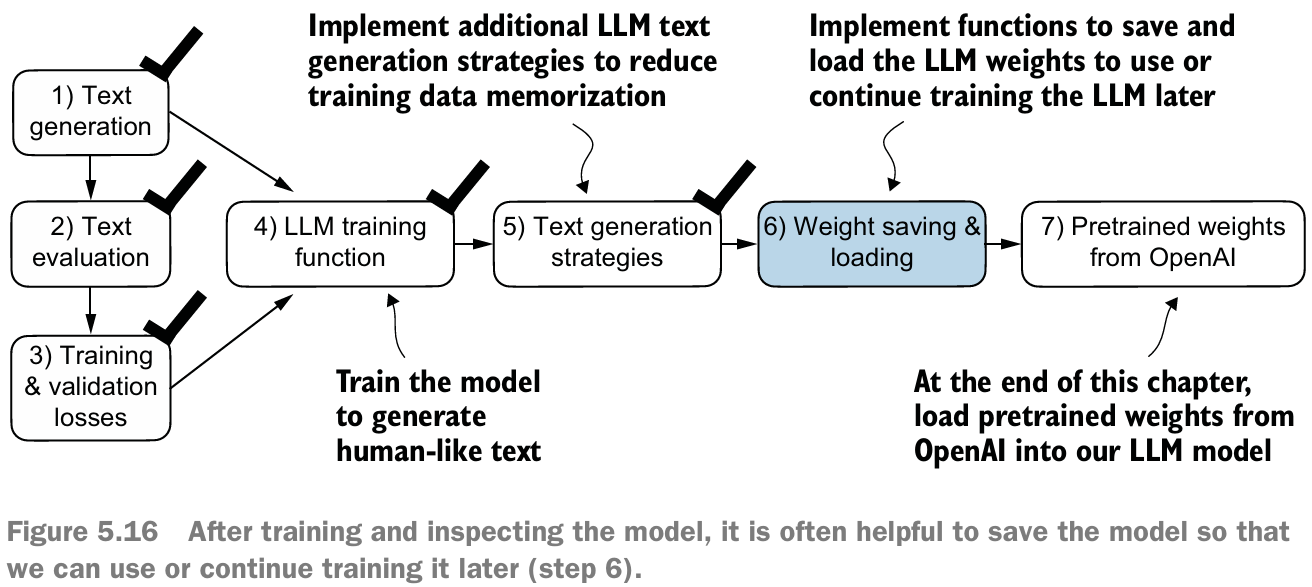

Felizmente, salvar um modelo PyTorch é relativamente simples. A maneira recomendada é salvar o `state_dict` do modelo, um dicionário que mapeia cada camada para seus parâmetros, usando a função `torch.save`:

In [ ]:
# Salva o dicionário de estado (state_dict) do modelo em um arquivo.
# O state_dict é um dicionário Python que mapeia cada camada do modelo
# para seus tensores de parâmetros (pesos e vieses). Salvar apenas o state_dict
# é a maneira recomendada no PyTorch para salvar modelos, pois é mais flexível
# do que salvar o objeto do modelo inteiro.
#
# Parâmetros:
# - model.state_dict(): Retorna o dicionário de estado do modelo. Este é o objeto
#                       que será salvo no arquivo.
# - "model.pth": O nome do arquivo onde o state_dict será salvo.
#                A extensão ".pth" ou ".pt" é comumente usada para arquivos
#                de modelo PyTorch.
#
# A função torch.save() serializa o objeto Python (neste caso, o state_dict)
# usando o módulo pickle e o salva em um arquivo no disco.
# Para carregar o modelo posteriormente, você precisará primeiro inicializar
# uma instância da classe do modelo e depois carregar o state_dict salvo nela.
torch.save(model.state_dict(), "model.pth")

`"model.pth"` é o nome do arquivo onde o `state_dict` é salvo. A extensão .pth é uma convenção para arquivos PyTorch, embora tecnicamente possamos usar qualquer extensão de arquivo.

Então, após salvar os pesos do modelo por meio do `state_dict`, podemos carregá-los em uma nova instância do modelo `GPTModel`:

In [ ]:
# Inicializa uma nova instância da classe GPTModel com a configuração especificada.
# É necessário criar uma instância do modelo com a mesma arquitetura daquela que foi salva
# antes de carregar o state_dict. O state_dict contém apenas os pesos e vieses,
# não a estrutura da rede.
model = GPTModel(GPT_CONFIG_124M)
# Carrega o dicionário de estado (state_dict) salvo de um arquivo e o carrega no modelo.
# torch.load("model.pth", map_location=device):
# - "model.pth": O caminho para o arquivo contendo o state_dict salvo.
# - map_location=device: Este argumento especifica para qual dispositivo (CPU ou GPU)
#   os tensores do state_dict devem ser carregados. Isso é importante para garantir
#   que os pesos sejam carregados no dispositivo correto, especialmente se você
#   salvou o modelo em um dispositivo (por exemplo, GPU) e está carregando-o
#   em outro (por exemplo, CPU), ou vice-versa.
# model.load_state_dict(...): Este método da instância do modelo carrega os parâmetros
# (pesos e vieses) do dicionário de estado carregado no modelo. As chaves no state_dict
# devem corresponder aos nomes dos parâmetros no modelo.
model.load_state_dict(torch.load("model.pth", map_location=device))
# Coloca o modelo no modo de avaliação.
# model.eval() desativa camadas específicas usadas durante o treinamento, como dropout
# e normalização em lote (batch normalization), garantindo que o modelo se comporte de forma
# consistente para inferência (geração de texto) ou avaliação. É crucial chamar este método
# após carregar um modelo treinado antes de usá-lo para fazer previsões.
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_resid): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=76

Conforme discutido no capítulo 4, o dropout ajuda a evitar que o modelo se ajuste excessivamente aos dados de treinamento, eliminando aleatoriamente os neurônios de uma camada durante o treinamento.No entanto, durante a inferência, não queremos eliminar aleatoriamente nenhuma informação aprendida pela rede. Usar `model.eval()` alterna o modelo para o modo de avaliação para inferência, desabilitando as camadas de dropout do `model`. Se planejamos continuar o pré-treinamento de um modelo posteriormente — por exemplo, usando a função `train_model_simple` que definimos anteriormente neste capítulo — também é recomendável salvar o estado do otimizador.

Otimizadores adaptativos, como o AdamW, armazenam parâmetros adicionais para cada peso do modelo. O AdamW usa dados históricos para ajustar dinamicamente as taxas de aprendizado para cada parâmetro do modelo. Sem isso, o otimizador é reinicializado e o modelo pode aprender de forma subótima ou até mesmo falhar na convergência adequada, o que significa que perderá a capacidade de gerar texto coerente. Usando `torch.save`, podemos salvar o conteúdo `state_dict` do modelo e do otimizador:

In [ ]:
torch.save({
    # "model_state_dict": model.state_dict(),
    # Salva o dicionário de estado (state_dict) do modelo.
    # O state_dict contém os parâmetros aprendidos (pesos e vieses) de cada camada do modelo.
    # Salvar isso permite carregar os pesos treinados em uma nova instância do modelo posteriormente.
    "model_state_dict": model.state_dict(),
    # "optimizer_state_dict": optimizer.state_dict(),
    # Salva o dicionário de estado (state_dict) do otimizador.
    # Para otimizadores adaptativos como AdamW, o state_dict inclui informações sobre
    # o estado interno do otimizador (como momentos de média e variância) para cada parâmetro.
    # Salvar o estado do otimizador é crucial para retomar o treinamento de onde parou,
    # garantindo que o otimizador continue ajustando as taxas de aprendizado corretamente.
    "optimizer_state_dict": optimizer.state_dict(),
    },
    # "model_and_optimizer.pth"
    # O nome do arquivo onde o dicionário contendo os state_dict do modelo e do otimizador será salvo.
    # A extensão ".pth" ou ".pt" é uma convenção comum para arquivos PyTorch.
    "model_and_optimizer.pth"
)

Podemos então restaurar os estados do modelo e do otimizador carregando primeiro os dados salvos via `torch.load` e depois usando o método `load_state_dict`:

In [ ]:
# Carrega o ponto de verificação (checkpoint) salvo do arquivo.
# O checkpoint é um dicionário que contém o state_dict do modelo e do otimizador.
# torch.load("model_and_optimizer.pth", map_location=device):
# - "model_and_optimizer.pth": O caminho para o arquivo contendo o checkpoint salvo.
# - map_location=device: Especifica para qual dispositivo (CPU ou GPU) os tensores
#   do checkpoint devem ser carregados. Isso garante que os dados sejam carregados
#   no dispositivo correto.
checkpoint = torch.load("model_and_optimizer.pth", map_location=device)
# Inicializa uma nova instância da classe GPTModel com a configuração especificada.
# A arquitetura do modelo deve ser a mesma daquela que foi salva no checkpoint.
model = GPTModel(GPT_CONFIG_124M)
# Carrega o state_dict do modelo a partir do checkpoint carregado.
# checkpoint["model_state_dict"] acessa o state_dict do modelo dentro do dicionário do checkpoint.
# model.load_state_dict(...) carrega os parâmetros (pesos e vieses) salvos no modelo.
model.load_state_dict(checkpoint["model_state_dict"])
# Inicializa o otimizador AdamW com a mesma configuração usada durante o treinamento original.
# É importante usar a mesma classe de otimizador (AdamW neste caso) e, idealmente,
# os mesmos hiperparâmetros (como learning rate e weight decay) para garantir
# que a retomada do treinamento seja consistente.
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.1)
# Carrega o state_dict do otimizador a partir do checkpoint carregado.
# checkpoint["optimizer_state_dict"] acessa o state_dict do otimizador dentro do dicionário do checkpoint.
# optimizer.load_state_dict(...) restaura o estado interno do otimizador, permitindo
# que ele continue de onde parou (especialmente importante para otimizadores adaptativos).
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
# Coloca o modelo no modo de treinamento.
# model.train() habilita funcionalidades como dropout e normalização em lote,
# preparando o modelo para continuar a fase de treinamento. Isso é necessário
# se o objetivo for retomar o treinamento após carregar o checkpoint.
model.train();

---
$\large \textbf{ Exercício 5.4}$

Após salvar os pesos, carregue o modelo e o otimizador em uma nova sessão Python ou em um arquivo de notebook do Jupyter e continue o pré-treinamento por mais uma época usando a função `train_model_simple`.

---

## **5 - Carregando Pesos Pré-Treinados do OpenAI**

Anteriormente, treinamos um pequeno modelo GPT-2 usando um conjunto de dados limitado, composto por um livro de contos. Essa abordagem nos permitiu focar nos fundamentos sem a necessidade de muito tempo e recursos computacionais.

Felizmente, a OpenAI compartilhou abertamente os pesos de seus modelos GPT-2, eliminando assim a necessidade de investir dezenas a centenas de milhares de dólares no retreinamento do modelo em um grande corpus. Então, vamos carregar esses pesos em nossa classe `GPTModel` e usar o modelo para geração de texto. Aqui, os pesos referem-se aos parâmetros ***weight*** armazenados nos atributos `.weight` das camadas `Linear` e `Embedding` do PyTorch, por exemplo. Nós os acessamos anteriormente via `model.parameters()` ao treinar o modelo. No capítulo 6, reutilizaremos esses pesos pré-treinados para ajustar o modelo para uma tarefa de classificação de texto e seguiremos instruções semelhantes às do ChatGPT.

Observe que o OpenAI salvou originalmente os pesos do GPT-2 via TensorFlow, que precisamos instalar para carregar os pesos em Python. O código a seguir usará uma ferramenta de barra de progresso chamada `tqdm` para monitorar o processo de download, que também precisamos instalar.

Você pode instalar essas bibliotecas executando o seguinte comando no seu terminal:

In [ ]:
# Este é um comando de shell (`!`) executado diretamente no ambiente do Colab.
# `pip install`: Este é o comando padrão do gerenciador de pacotes do Python (`pip`)
#                para instalar bibliotecas.
# `tensorflow>=2.15.0`: Instala a biblioteca TensorFlow.
#                       TensorFlow é uma biblioteca de código aberto amplamente usada para
#                       aprendizado de máquina e redes neurais.
#                       `>=2.15.0`: Especifica que queremos instalar a versão 2.15.0 ou superior.
#                                 Isso garante que temos uma versão compatível com o restante do código.
# `tqdm>=4.66`: Instala a biblioteca tqdm.
#               tqdm é uma biblioteca que permite adicionar barras de progresso a loops,
#               tornando o monitoramento de tarefas de longa duração (como downloads ou treinamento)
#               mais visual e informativo.
#               `>=4.66`: Especifica que queremos instalar a versão 4.66 ou superior.
!pip install tensorflow>=2.15.0  tqdm>=4.66

O código para download é relativamente longo, basicamente um clichê, e não muito interessante. Portanto, em vez de dedicar um espaço precioso à discussão de código Python para buscar arquivos da internet, baixamos o módulo Python `gpt_download.py` diretamente do repositório online deste capítulo:

In [ ]:
# Importa o módulo `urllib.request` da biblioteca padrão do Python.
# Este módulo é usado para trabalhar com URLs e baixar dados da internet.
import urllib.request
# Define a URL do arquivo que queremos baixar.
# Esta URL aponta para o arquivo `gpt_download.py` no repositório GitHub do livro "LLMs from Scratch".
url = (
    "https://raw.githubusercontent.com/rasbt/"
    "LLMs-from-scratch/main/ch05/"
    "01_main-chapter-code/gpt_download.py"
)
# Extrai o nome do arquivo da URL.
# url.split('/') divide a string da URL em uma lista de substrings usando '/' como delimitador.
# [-1] seleciona o último elemento da lista, que é o nome do arquivo (`gpt_download.py`).
filename = url.split('/')[-1]
# Baixa o arquivo da URL especificada e o salva com o nome de arquivo extraído.
# urllib.request.urlretrieve(url, filename):
# - url: A URL do recurso a ser baixado.
# - filename: O caminho local onde o recurso baixado será salvo.
# Esta função baixa o conteúdo da URL e o escreve diretamente no arquivo especificado.
urllib.request.urlretrieve(url, filename)

('gpt_download.py', <http.client.HTTPMessage at 0x7a205251e7b0>)

Em seguida, após baixar este arquivo para o diretório local da sua sessão Python, você deve inspecionar brevemente o conteúdo deste arquivo para garantir que ele foi salvo corretamente e contém código Python válido.

Agora podemos importar a função `download_and_load_gpt2` do arquivo `gpt_download.py` da seguinte forma, o que carregará as configurações de arquitetura do GPT-2 (`settings`) e os parâmetros de peso (`params`) em nossa sessão Python. A execução deste código baixa os sete arquivos a seguir associados ao modelo GPT-2 de 124M de parâmetros:

In [ ]:
# Importa a função `download_and_load_gpt2` do módulo `gpt_download`.
# Este módulo (baixado anteriormente) contém a lógica para baixar
# os pesos pré-treinados e as configurações de arquitetura do modelo GPT-2 da OpenAI.
from gpt_download import download_and_load_gpt2
# Chama a função `download_and_load_gpt2` para baixar e carregar os dados do modelo GPT-2.
# O resultado da função é retornado como uma tupla contendo as configurações
# do modelo e os parâmetros de peso.
settings, params = download_and_load_gpt2(
    # model_size="124M": Este parâmetro especifica o tamanho do modelo GPT-2 a ser baixado.
    #                    "124M" refere-se ao modelo com 124 milhões de parâmetros.
    #                    Outras opções podem estar disponíveis dependendo da implementação
    #                    no arquivo `gpt_download.py`.
    model_size="124M",
    # models_dir="gpt2": Este parâmetro especifica o diretório onde os arquivos
    #                    do modelo GPT-2 baixados serão salvos localmente.
    #                    Se o diretório não existir, a função provavelmente o criará.
    models_dir="gpt2"
)
# A variável `settings` agora conterá um dicionário ou estrutura de dados com as
# configurações de arquitetura do modelo (como tamanho do vocabulário, número de camadas,
# etc.).
# A variável `params` agora conterá um dicionário ou estrutura de dados com os
# parâmetros de peso (tensôres PyTorch ou compatíveis) do modelo GPT-2 pré-treinado.

checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 178kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:01<00:00, 569kiB/s]
hparams.json: 100%|██████████| 90.0/90.0 [00:00<00:00, 153kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 498M/498M [04:11<00:00, 1.98MiB/s]
model.ckpt.index: 100%|██████████| 5.21k/5.21k [00:00<00:00, 7.44MiB/s]
model.ckpt.meta: 100%|██████████| 471k/471k [00:01<00:00, 393kiB/s]
vocab.bpe: 100%|██████████| 456k/456k [00:01<00:00, 437kiB/s]


**NOTA:** Se o código para download não funcionar, pode ser devido a uma conexão de internet intermitente, problemas no servidor ou alterações na forma como o OpenAI compartilha os pesos do modelo GPT-2 de código aberto. Nesse caso, visite o repositório de código online deste capítulo em https://github.com/rasbt/LLMs-from-scratch para obter instruções alternativas e atualizadas e entre em contato pelo Fórum Manning para mais perguntas.

Supondo que a execução do código anterior tenha sido concluída, vamos inspecionar o conteúdo de `settings` e `params`:

In [ ]:
# Imprime o conteúdo da variável `settings`.
# A variável `settings` contém as configurações de arquitetura do modelo GPT-2
# que foram carregadas pela função `download_and_load_gpt2`.
# Isso geralmente inclui informações como tamanho do vocabulário, número de camadas,
# dimensão do embedding, etc. Imprimir isso ajuda a verificar se as configurações
# foram carregadas corretamente.
print("Settings:", settings)

# Imprime as chaves do dicionário de parâmetros do modelo.
# A variável `params` contém um dicionário onde as chaves são os nomes das camadas
# ou parâmetros do modelo e os valores são os tensores de peso correspondentes.
# `params.keys()` retorna uma view das chaves deste dicionário.
# Imprimir as chaves ajuda a entender quais parâmetros foram carregados
# e como eles estão organizados no dicionário `params`. Isso é útil ao mapear
# esses parâmetros para as camadas do seu modelo PyTorch.
print("Parameter dictionary keys:", params.keys())

Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


Tanto `settings` quanto `params` são dicionários Python. O dicionário `settings` armazena as configurações da arquitetura LLM de forma semelhante às nossas configurações `GPT_CONFIG_124M` definidas manualmente. O dicionário `params` contém os tensores de peso reais. Observe que imprimimos apenas as chaves do dicionário, pois imprimir o conteúdo dos pesos ocuparia muito espaço na tela; no entanto, podemos inspecionar esses tensores de peso imprimindo o dicionário inteiro com `print(params)` ou selecionando tensores individuais com as respectivas chaves do dicionário, por exemplo, os pesos da camada de incorporação:

In [ ]:
# Imprime o tensor de pesos da camada de embedding de token.
# `params` é o dicionário que contém os parâmetros de peso carregados do modelo GPT-2 da OpenAI.
# `params["wte"]` acessa o tensor de pesos correspondente à camada de token embedding (`wte` significa "weight token embedding").
# Este tensor é uma matriz onde cada linha representa o vetor de embedding para um token específico no vocabulário.
print(params["wte"])
# Imprime a forma (shape) do tensor de pesos da camada de embedding de token.
# A forma de um tensor indica suas dimensões. Para a camada de embedding de token,
# a forma é (tamanho do vocabulário, dimensão do embedding).
# - A primeira dimensão (50257 neste caso) é o número total de tokens no vocabulário.
# - A segunda dimensão (768 neste caso) é o tamanho do vetor de embedding para cada token.
# Isso confirma as dimensões do tensor de pesos e indiretamente o tamanho do vocabulário
# e a dimensão do embedding do modelo GPT-2 carregado.
print("Token embedding weight tensor dimensions:", params["wte"].shape)

[[-0.11010301 -0.03926672  0.03310751 ... -0.1363697   0.01506208
   0.04531523]
 [ 0.04034033 -0.04861503  0.04624869 ...  0.08605453  0.00253983
   0.04318958]
 [-0.12746179  0.04793796  0.18410145 ...  0.08991534 -0.12972379
  -0.08785918]
 ...
 [-0.04453601 -0.05483596  0.01225674 ...  0.10435229  0.09783269
  -0.06952604]
 [ 0.1860082   0.01665728  0.04611587 ... -0.09625227  0.07847701
  -0.02245961]
 [ 0.05135201 -0.02768905  0.0499369  ...  0.00704835  0.15519823
   0.12067825]]
Token embedding weight tensor dimensions: (50257, 768)


Baixamos e carregamos os pesos do menor modelo GPT-2 por meio da configuração `download_and_load_gpt2(model_size="124M", ...)`. O OpenAI também compartilha os pesos dos modelos maiores: `355M`, `774M` e `1558M`. A arquitetura geral desses modelos GPT de tamanhos diferentes é a mesma, como ilustrado na Figura 5.17, exceto que diferentes elementos arquitetônicos são repetidos em diferentes números de vezes e o tamanho da incorporação é diferente. O código restante neste capítulo também é compatível com esses modelos
maiores.

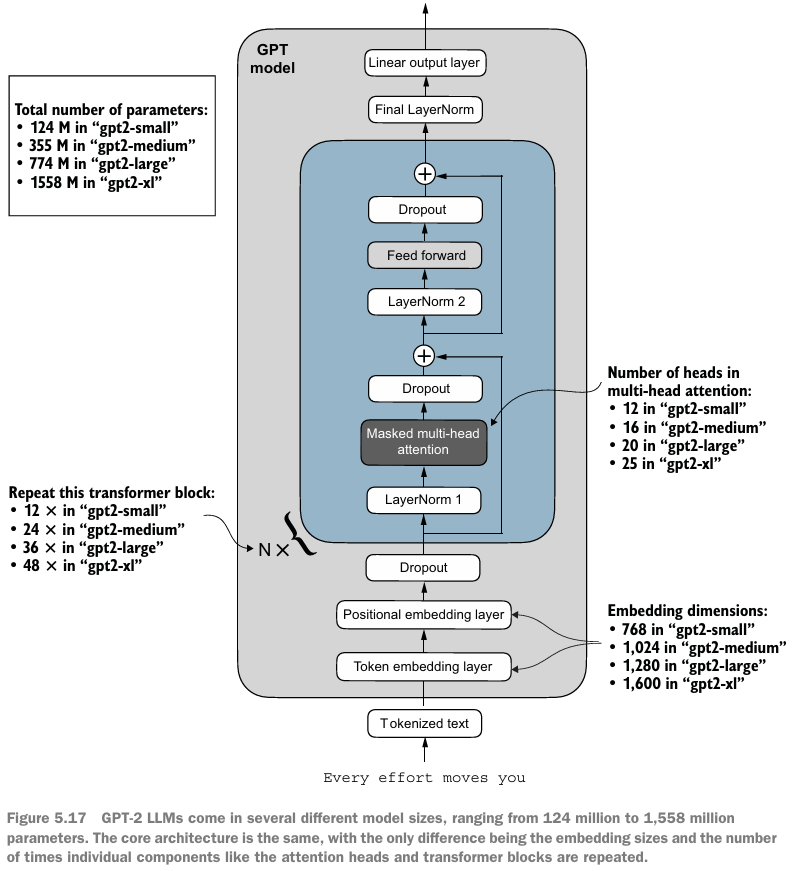

Após carregar os pesos do modelo GPT-2 em Python, ainda precisamos transferi-los dos dicionários `settings` e `params` para nossa instância `GPTModel`. Primeiro, criamos um dicionário que lista as diferenças entre os diferentes tamanhos de modelo GPT na figura 5.17:

In [ ]:
# Define um dicionário chamado `model_configs`.
# Este dicionário armazena as diferenças principais de configuração entre os diferentes tamanhos
# de modelos GPT-2 (small, medium, large, xl) liberados pela OpenAI.
# Cada chave no dicionário é uma string que identifica o tamanho do modelo (e o número aproximado
# de parâmetros), como "gpt2-small (124M)".
# O valor associado a cada chave é outro dicionário, que contém os hiperparâmetros
# específicos para a arquitetura daquele modelo.
model_configs = {
    # Configurações para o modelo GPT-2 "small" com 124 milhões de parâmetros.
    "gpt2-small (124M)": {
        # "emb_dim": Dimensão do embedding e dimensão do modelo. Tamanho dos vetores
        # de representação interna. 768 para o modelo small.
        "emb_dim": 768,
        # "n_layers": Número de camadas do Transformer no modelo. 12 camadas para o small.
        "n_layers": 12,
        # "n_heads": Número de cabeças de atenção no mecanismo de atenção multi-cabeça. 12 cabeças para o small.
        "n_heads": 12
    },
    # Configurações para o modelo GPT-2 "medium" com 355 milhões de parâmetros.
    "gpt2-medium (355M)": {
        # 1024 é a dimensão do embedding para o modelo medium.
        "emb_dim": 1024,
        # 24 é o número de camadas para o modelo medium.
        "n_layers": 24,
        # 16 é o número de cabeças de atenção para o modelo medium.
        "n_heads": 16
    },
    # Configurações para o modelo GPT-2 "large" com 774 milhões de parâmetros.
    "gpt2-large (774M)": {
        # 1280 é a dimensão do embedding para o modelo large.
        "emb_dim": 1280,
        # 36 é o número de camadas para o modelo large.
        "n_layers": 36,
        # 20 é o número de cabeças de atenção para o modelo large.
        "n_heads": 20
    },
    # Configurações para o modelo GPT-2 "xl" com 1558 milhões (1.5 bilhão) de parâmetros.
    "gpt2-xl (1558M)": {
        # 1600 é a dimensão do embedding para o modelo xl.
        "emb_dim": 1600,
        # 48 é o número de camadas para o modelo xl.
        "n_layers": 48,
        # 25 é o número de cabeças de atenção para o modelo xl.
        "n_heads": 25
    },
}

Suponha que estejamos interessados ​​em carregar o menor modelo, `"gpt2-small (124M)"`. Podemos usar as configurações correspondentes da tabela `model_configs` para atualizar nosso `GPT_CONFIG_124M` completo que definimos e usamos anteriormente:

In [ ]:
# Define o nome do modelo GPT-2 que queremos carregar e cujas configurações usaremos.
# Neste caso, estamos escolhendo o modelo "gpt2-small" com 124 milhões de parâmetros.
model_name = "gpt2-small (124M)"
# Cria uma cópia do dicionário de configuração GPT_CONFIG_124M que foi definido
# anteriormente no notebook. Usar `.copy()` é importante para garantir que não
# estamos modificando o dicionário original diretamente.
NEW_CONFIG = GPT_CONFIG_124M.copy()
# Atualiza o dicionário NEW_CONFIG com os valores específicos do modelo selecionado.
# model_configs[model_name] acessa o dicionário de configurações para o `model_name` especificado
# dentro do dicionário `model_configs`.
# O método `.update()` de um dicionário adiciona ou atualiza pares chave-valor
# de outro dicionário. Se uma chave já existir em NEW_CONFIG, seu valor será atualizado
# com o valor do dicionário `model_configs[model_name]`. Se a chave não existir, ela será adicionada.
# Isso sobrescreve as configurações padrão em NEW_CONFIG com as configurações
# específicas do modelo "gpt2-small", como `emb_dim`, `n_layers` e `n_heads`.
NEW_CONFIG.update(model_configs[model_name])

Leitores atentos podem se lembrar de que usamos um comprimento de 256 tokens anteriormente, mas os modelos GPT-2 originais da OpenAI foram treinados com um comprimento de 1.024 tokens, então temos que atualizar o `NEW_CONFIG` adequadamente:

In [ ]:
# Atualiza o dicionário `NEW_CONFIG` com o novo valor para a chave "context_length".
# O método `.update()` de um dicionário adiciona ou atualiza pares chave-valor de outro dicionário.
# Aqui, estamos usando um dicionário literal `{"context_length": 1024}` para fornecer a chave e o valor a serem atualizados.
# Se a chave "context_length" já existir em `NEW_CONFIG`, seu valor será substituído por 1024.
# Se a chave não existir, ela será adicionada.
# Isso é feito para ajustar o `context_length` do modelo para 1024, que é o valor
# usado nos modelos GPT-2 originais da OpenAI, permitindo que o modelo carregado
# processe sequências de até 1024 tokens.
NEW_CONFIG.update({"context_length": 1024})

Além disso, a OpenAI utilizou vetores de viés nas camadas lineares do módulo de atenção multicabeça para implementar os cálculos de consulta, chave e matriz de valor. Vetores de viés não são mais comumente usados ​​em LLMs, pois não melhoram o desempenho da modelagem e, portanto, são desnecessários. No entanto, como estamos trabalhando com pesos pré-treinados, precisamos ajustar as configurações para garantir a consistência e habilitar estes vetores de viés:

In [ ]:
# Atualiza o dicionário `NEW_CONFIG` com o novo valor para a chave "qkv_bias".
# O método `.update()` de um dicionário adiciona ou atualiza pares chave-valor de outro dicionário.
# Aqui, estamos usando um dicionário literal `{"qkv_bias": True}` para fornecer a chave e o valor a serem atualizados.
# Isso é feito para definir o `qkv_bias` como True, o que é necessário para carregar os pesos pré-treinados
# dos modelos GPT-2 da OpenAI, pois esses modelos foram treinados com vieses nas projeções de Query, Key e Value
# dentro do mecanismo de atenção multi-cabeça.
NEW_CONFIG.update({"qkv_bias": True})

Agora podemos usar o dicionário `NEW_CONFIG` atualizado para inicializar uma nova instância `GPTModel`:

In [ ]:
# Inicializa uma nova instância da classe GPTModel usando as configurações definidas
# no dicionário `NEW_CONFIG`. Este dicionário foi atualizado para refletir as
# configurações específicas do modelo GPT-2 da OpenAI que será carregado (neste caso, o modelo de 124M).
# A arquitetura do modelo é criada com base nestas configurações, mas os pesos ainda
# são inicializados aleatoriamente neste ponto.
gpt = GPTModel(NEW_CONFIG)
# Coloca o modelo no modo de avaliação.
# model.eval() desativa camadas específicas usadas durante o treinamento, como dropout
# e normalização em lote (batch normalization), garantindo que o modelo se comporte de forma
# consistente para inferência (geração de texto) ou avaliação. Isso é crucial ao carregar
# pesos pré-treinados e usá-los para gerar texto, pois não queremos que a aleatoriedade
# do treinamento afete a saída.
gpt.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_resid): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768,

Por padrão, a instância `GPTModel` é inicializada com pesos aleatórios para pré-treinamento. O último passo para usar os pesos do modelo do OpenAI é substituir esses pesos aleatórios pelos pesos que carregamos no dicionário params. Para isso, primeiro definiremos uma pequena função utilitária `assign` que verifica se dois tensores ou matrizes (`left` e `right`) têm as mesmas dimensões ou formato e retorna o tensor direito como parâmetros treináveis ​​do PyTorch:

In [ ]:
def assign(left, right):
    # Verifica se as formas (dimensões) dos tensores `left` e `right` são diferentes.
    # `.shape` retorna uma tupla representando as dimensões do tensor.
    if left.shape != right.shape:
        # Se as formas não corresponderem, levanta um erro `ValueError`.
        # Isso é crucial para garantir que estamos tentando atribuir pesos com as dimensões corretas
        # à camada correspondente no modelo. Uma incompatibilidade de forma impediria a operação
        # e potencialmente levaria a resultados inesperados ou erros posteriores.
        # A mensagem de erro formatada (`f"..."`) inclui as formas de ambos os tensores
        # para ajudar na depuração.
        raise ValueError(f"Shape mismatch. Left: {left.shape}, "
                          "Right: {right.shape}"
        )
    # Cria um novo tensor PyTorch a partir dos dados do tensor `right`.
    # torch.tensor(right) converte os dados no tensor `right` em um novo tensor PyTorch.
    # torch.nn.Parameter(...) envolve este novo tensor em um objeto `torch.nn.Parameter`.
    # Isso registra o tensor como um parâmetro treinável do modelo quando ele é atribuído
    # a um atributo de um módulo (como uma camada). Parâmetros são tensores que o otimizador
    # tentará ajustar durante o treinamento.
    # O tensor `right` (que contém os pesos carregados do modelo GPT-2 da OpenAI neste contexto)
    # é retornado, mas agora envolvido como um parâmetro treinável, pronto para ser atribuído
    # à camada correspondente no seu `GPTModel`.
    return torch.nn.Parameter(torch.tensor(right))

Em seguida, definimos uma função `load_weights_into_gpt` que carrega os pesos do dicionário params em uma instância `GPTModel` gpt.

In [ ]:
# Importa a biblioteca NumPy, que é fundamental para computação científica em Python
# NumPy fornece suporte para arrays multidimensionais e funções matemáticas para operar com eles
# É usado aqui para manipular os arrays de pesos do modelo pré-treinado
import numpy as np

# Define a função que carrega os pesos pré-treinados em uma arquitetura GPT personalizada
# Esta função é crucial para transferir os parâmetros de um modelo pré-treinado para nossa implementação
#
# Parâmetros:
#   gpt: instância do modelo GPT que estamos construindo (nossa implementação personalizada)
#        Este objeto deve ter uma estrutura específica com camadas e parâmetros que correspondam
#        aos nomes usados nesta função (pos_emb, tok_emb, trf_blocks, etc.)
#
#   params: dicionário contendo todos os parâmetros pré-treinados do modelo original
#           Estes parâmetros geralmente vêm de um arquivo de checkpoint de um modelo GPT pré-treinado
#           (como GPT-2 da OpenAI) e seguem uma estrutura hierárquica específica
def load_weights_into_gpt(gpt, params):
    # Atribui os pesos de embedding posicional ao modelo usando a função assign
    # A função assign verifica a compatibilidade de formatos e converte numpy arrays para parâmetros PyTorch
    #
    # gpt.pos_emb.weight: parâmetro de peso da camada de embedding posicional no nosso modelo
    # params['wpe']: pesos de embedding posicional do modelo pré-treinado (array NumPy)
    #                'wpe' significa "Word Positional Embeddings"
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])

    # Atribui os pesos de embedding de tokens ao modelo usando a função assign
    # gpt.tok_emb.weight: parâmetro de peso da camada de embedding de tokens no nosso modelo
    # params['wte']: pesos de embedding de tokens do modelo pré-treinado (array NumPy)
    #                'wte' significa "Word Token Embeddings"
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])

    # Itera sobre cada bloco transformer do modelo
    # Os modelos GPT consistem em vários blocos idênticos empilhados (12, 24, 36 ou 48 blocos)
    #
    # b: índice do bloco atual (começa em 0 e vai até número_de_blocos - 1)
    # params["blocks"]: lista de dicionários, cada um contendo os parâmetros de um bloco transformer
    for b in range(len(params["blocks"])):
        # Divide os pesos da camada de atenção concatenada (Q, K, V) em três partes separadas
        # No modelo original, os pesos de Query, Key e Value são armazenados concatenados
        # em uma única matriz para eficiência computacional
        #
        # params["blocks"][b]["attn"]["c_attn"]["w"]: pesos da camada linear que projeta
        #     as entradas para os espaços de Query, Key e Value, todos concatenados juntos
        #     A forma é [d_model, 3*d_model] onde d_model é a dimensão do modelo
        #
        # np.split(): divide a matriz ao longo do último eixo (axis=-1) em 3 partes iguais
        #     Isso separa a matriz concatenada [d_model, 3*d_model] em três matrizes [d_model, d_model]
        #     correspondentes a Query, Key e Value respectivamente
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)

        # Atribui os pesos da Query (transpondo para o formato correto) usando a função assign
        # A função assign garante que os formatos sejam compatíveis antes da atribuição
        #
        # gpt.trf_blocks[b].att.W_query.weight: pesos da camada linear de Query no nosso modelo
        # q_w.T: pesos de Query do modelo pré-treinado, transpostos para o formato correto
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)

        # Atribui os pesos da Key (transpondo para o formato correto) usando a função assign
        # gpt.trf_blocks[b].att.W_key.weight: pesos da camada linear de Key no nosso modelo
        # k_w.T: pesos de Key do modelo pré-treinado, transpostos
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T)

        # Atribui os pesos da Value (transpondo para o formato correto) usando a função assign
        # gpt.trf_blocks[b].att.W_value.weight: pesos da camada linear de Value no nosso modelo
        # v_w.T: pesos de Value do modelo pré-treinado, transpostos
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        # Divide os vieses (biases) da camada de atenção concatenada em três partes
        # Assim como os pesos, os vieses de Query, Key e Value também são armazenados concatenados
        #
        # params["blocks"][b]["attn"]["c_attn"]["b"]: vieses da camada linear concatenada
        #     A forma é [3*d_model] - um vetor com os vieses de Q, K e V concatenados
        #
        # np.split(): divide o vetor ao longo do último eixo em 3 partes iguais
        #     Isso separa o vetor concatenado [3*d_model] em três vetores [d_model]
        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)

        # Atribui o viés da Query usando a função assign
        # gpt.trf_blocks[b].att.W_query.bias: viés da camada linear de Query no nosso modelo
        # q_b: viés de Query do modelo pré-treinado
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b)

        # Atribui o viés da Key usando a função assign
        # gpt.trf_blocks[b].att.W_key.bias: viés da camada linear de Key no nosso modelo
        # k_b: viés de Key do modelo pré-treinado
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b)

        # Atribui o viés da Value usando a função assign
        # gpt.trf_blocks[b].att.W_value.bias: viés da camada linear de Value no nosso modelo
        # v_b: viés de Value do modelo pré-treinado
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b)

        # Atribui os pesos da camada de projeção de saída do mecanismo de atenção usando assign
        # Após a atenção multi-head, os resultados são concatenados e projetados para
        # o espaço original através de uma camada linear
        #
        # gpt.trf_blocks[b].att.out_proj.weight: pesos da camada de projeção de saída
        # params["blocks"][b]["attn"]["c_proj"]["w"]: pesos da camada de projeção do modelo pré-treinado
        # .T: transposição para ajustar o formato
        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight,
            params["blocks"][b]["attn"]["c_proj"]["w"].T)

        # Atribui o viés da camada de projeção de saída do mecanismo de atenção usando assign
        # gpt.trf_blocks[b].att.out_proj.bias: viés da camada de projeção de saída
        # params["blocks"][b]["attn"]["c_proj"]["b"]: viés da camada de projeção do modelo pré-treinado
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias,
            params["blocks"][b]["attn"]["c_proj"]["b"])

        # Atribui os pesos da primeira camada da rede feed-forward (MLP) usando assign
        # Cada bloco transformer contém uma rede neural feed-forward de 2 camadas
        # após o mecanismo de atenção
        #
        # gpt.trf_blocks[b].ff.layers[0].weight: pesos da primeira camada linear da MLP
        # params["blocks"][b]["mlp"]["c_fc"]["w"]: pesos da primeira camada linear do modelo pré-treinado
        #     "c_fc" significa "fully connected" - camada totalmente conectada
        # .T: transposição para ajustar o formato
        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight,
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)

        # Atribui o viés da primeira camada da rede feed-forward usando assign
        # gpt.trf_blocks[b].ff.layers[0].bias: viés da primeira camada linear da MLP
        # params["blocks"][b]["mlp"]["c_fc"]["b"]: viés da primeira camada linear do modelo pré-treinado
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias,
            params["blocks"][b]["mlp"]["c_fc"]["b"])

        # Atribui os pesos da segunda camada da rede feed-forward usando assign
        # A segunda camada da MLP projeta de volta para a dimensão original do modelo
        #
        # gpt.trf_blocks[b].ff.layers[2].weight: pesos da segunda camada linear da MLP
        #     Note que layers[2] sugere que há uma camada de ativação não-linear entre as duas
        #     camadas lineares (provavelmente layers[1] é a função de ativação)
        # params["blocks"][b]["mlp"]["c_proj"]["w"]: pesos da segunda camada linear do modelo pré-treinado
        #     "c_proj" significa "projection" - camada de projeção
        # .T: transposição para ajustar o formato
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight,
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)

        # Atribui o viés da segunda camada da rede feed-forward usando assign
        # gpt.trf_blocks[b].ff.layers[2].bias: viés da segunda camada linear da MLP
        # params["blocks"][b]["mlp"]["c_proj"]["b"]: viés da segunda camada linear do modelo pré-treinado
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias,
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        # Atribui os parâmetros de escala (gamma) da primeira camada de normalização usando assign
        # As camadas de normalização (LayerNorm) em transformers têm dois conjuntos de parâmetros:
        # parâmetros de escala (gamma) e deslocamento (beta)
        #
        # gpt.trf_blocks[b].norm1.scale: parâmetros de escala da primeira normalização no bloco
        #     Esta normalização geralmente é aplicada antes do mecanismo de atenção
        # params["blocks"][b]["ln_1"]["g"]: parâmetros de escala da primeira normalização do modelo pré-treinado
        #     "ln_1" significa "layer normalization 1" - primeira normalização de camada
        #     "g" significa "gamma" - parâmetros de escala
        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale,
            params["blocks"][b]["ln_1"]["g"])

        # Atribui os parâmetros de deslocamento (beta) da primeira camada de normalização usando assign
        # gpt.trf_blocks[b].norm1.shift: parâmetros de deslocamento da primeira normalização
        # params["blocks"][b]["ln_1"]["b"]: parâmetros de deslocamento do modelo pré-treinado
        #     "b" significa "beta" - parâmetros de deslocamento
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift,
            params["blocks"][b]["ln_1"]["b"])

        # Atribui os parâmetros de escala (gamma) da segunda camada de normalização usando assign
        # gpt.trf_blocks[b].norm2.scale: parâmetros de escala da segunda normalização no bloco
        #     Esta normalização geralmente é aplicada antes da rede feed-forward
        # params["blocks"][b]["ln_2"]["g"]: parâmetros de escala da segunda normalização do modelo pré-treinado
        #     "ln_2" significa "layer normalization 2" - segunda normalização de camada
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale,
            params["blocks"][b]["ln_2"]["g"])

        # Atribui os parâmetros de deslocamento (beta) da segunda camada de normalização usando assign
        # gpt.trf_blocks[b].norm2.shift: parâmetros de deslocamento da segunda normalização
        # params["blocks"][b]["ln_2"]["b"]: parâmetros de deslocamento do modelo pré-treinado
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift,
            params["blocks"][b]["ln_2"]["b"])

    # Atribui os parâmetros de escala (gamma) da camada de normalização final usando assign
    # Após todos os blocos transformer, há uma camada de normalização final antes da cabeça de saída
    #
    # gpt.final_norm.scale: parâmetros de escala da normalização final
    # params["g"]: parâmetros de escala (gamma) da normalização final do modelo pré-treinado
    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])

    # Atribui os parâmetros de deslocamento (beta) da camada de normalização final usando assign
    # gpt.final_norm.shift: parâmetros de deslocamento da normalização final
    # params["b"]: parâmetros de deslocamento (beta) da normalização final do modelo pré-treinado
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])

    # Atribui os pesos da camada de saída (head) usando assign
    # A camada de saída geralmente compartilha pesos com a camada de embedding de tokens
    # Isso é uma técnica comum em modelos de linguagem para reduzir o número de parâmetros
    #
    # gpt.out_head.weight: pesos da camada linear de saída
    # params["wte"]: pesos de embedding de tokens (compartilhados com a camada de entrada)
    #     Isso implementa "weight tying" entre os embeddings de entrada e saída
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])

Na função `load_weights_into_gpt`, comparamos cuidadosamente os pesos da implementação do OpenAI com nossa implementação `GPTModel`. Para citar um exemplo específico, o OpenAI armazenou o tensor de pesos para a camada de projeção de saída do primeiro bloco do transformador como `params["blocks"][0]["attn"]["c_proj"]["w"]`. Em nossa implementação, esse tensor de pesos corresponde a `gpt.trf_blocks[b].att.out_proj
.weight`, onde `gpt` é uma instância de `GPTModel`.

O desenvolvimento da função `load_weights_into_gpt` exigiu muita suposição, já que o OpenAI utilizou uma convenção de nomenclatura ligeiramente diferente da nossa. No entanto, a função de atribuição nos alertaria se tentássemos corresponder dois tensores com dimensões diferentes. Além disso, se cometêssemos um erro nessa função, perceberíamos isso, pois o modelo GPT resultante não seria capaz de produzir texto coerente.

Vamos agora testar o `load_weights_into_gpt` na prática e carregar os pesos do modelo OpenAI em nossa instância `GPTModel` **gpt**:

In [ ]:
# Chama a função auxiliar `load_weights_into_gpt`.
# Esta função (definida anteriormente) pega a instância do nosso modelo GPT (`gpt`)
# e o dicionário de parâmetros pré-treinados carregados da OpenAI (`params`)
# e atribui os pesos e vieses correspondentes de `params` para as camadas apropriadas em `gpt`.
# Isso efetivamente transfere o "conhecimento" do modelo pré-treinado GPT-2 para a nossa implementação.
load_weights_into_gpt(gpt, params)
# Move o modelo carregado para o dispositivo de computação especificado (CPU ou GPU).
# model.to(device) garante que os parâmetros do modelo estejam na memória do dispositivo
# onde as operações de computação (como geração de texto) serão realizadas.
# Se `device` for 'cuda', o modelo será transferido para a GPU. Se for 'cpu', ele permanecerá na CPU.
gpt.to(device)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_resid): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768,

Se o modelo for carregado corretamente, agora podemos usá-lo para gerar um novo texto usando nossa função anterior `generate`:

In [ ]:
# Define a semente para o gerador de números aleatórios do PyTorch.
# Isso garante que a geração de texto, que envolve amostragem probabilística
# (se temperature > 0 ou top_k é usado), seja reproduzível.
# Se você executar este código com a mesma semente, obterá os mesmos resultados
# de geração de texto.
torch.manual_seed(123)
# Chama a função `generate` para gerar texto usando o modelo treinado.
# Esta função implementa a lógica para gerar novos tokens passo a passo,
# com opções para controlar a aleatoriedade (temperatura e top-k).
token_ids = generate(
    # model=gpt: Passa a instância do modelo GPT (agora com pesos pré-treinados)
    # para a função de geração. É este modelo que fará as previsões sobre o próximo token.
    model=gpt,
    # idx=text_to_token_ids("Every effort moves you", tokenizer).to(device): Prepara a entrada
    # para a função de geração. A string "Every effort moves you" é convertida
    # em IDs de token usando o tokenizer, servindo como o prompt inicial.
    # `.to(device)` move o tensor resultante para o mesmo dispositivo onde o modelo está.
    idx=text_to_token_ids("From heaven to earth, there is no being more honorable than me.", tokenizer).to(device),
    # max_new_tokens=25: Especifica o número máximo de novos tokens a serem gerados
    # após o contexto inicial. A geração para quando este limite é atingido.
    max_new_tokens=100,
    # context_size=NEW_CONFIG["context_length"]: Passa o tamanho do contexto
    # configurado para o modelo (agora 1024). A função de geração usará apenas os últimos
    # `context_size` tokens do contexto atual para fazer a próxima previsão.
    context_size=NEW_CONFIG["context_length"],
    # top_k=50: Especifica que a amostragem será restrita aos 50 tokens
    # com os logits mais altos em cada passo de geração. Isso ajuda a evitar
    # a amostragem de tokens muito improváveis.
    top_k=50,
    # temperature=1.5: Define a temperatura para o escalonamento de temperatura.
    # Um valor de 1.5 (maior que 1) torna a distribuição de probabilidade sobre
    # os tokens mais uniforme, aumentando a aleatoriedade e a diversidade
    # do texto gerado.
    temperature=1.2
)
# Imprime o texto de saída gerado pelo modelo.
# "Output text:\n": Um rótulo para a saída.
# `token_ids_to_text(token_ids, tokenizer)`: Converte o tensor de IDs de token
# gerado pela função `generate` de volta para uma string de texto legível
# usando o tokenizer. O resultado inclui o contexto inicial e os novos tokens.
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 From heaven to earth, there is no being more honorable than me.

Therefore, I will bear them (the commandments) with all my heart

Even after receiving this (final), I will be free of them on earth


I will remember all my blessings, whether mine is eternal life alone or the life of Christ


Therefore, I am not going to give up anyone

Any of the possessions because they're all valid. If a poor, black, elderly man will give up all his possessions to help you


I will take care


Podemos ter certeza de que carregamos os pesos do modelo corretamente, pois ele consegue produzir texto coerente. Um pequeno erro nesse processo causaria a falha do modelo. Nos próximos capítulos, trabalharemos mais com este modelo pré-treinado e o ajustaremos para classificar texto e seguir instruções.

---

$\large \textbf{Exercício 5.5}$

Calcule as perdas do conjunto de treinamento e validação do `GPTModel` com os pesos pré-treinados do OpenAI no conjunto de dados "The Verdict".

$\large \textbf{Exercício 5.6}$

Experimente com modelos GPT-2 de diferentes tamanhos — por exemplo, o maior modelo com 1.558 milhões de parâmetros — e compare o texto gerado com o modelo com 124 milhões.

---

$\large \textbf{Resumo}$

- Quando os LLMs geram texto, eles geram um token por vez.

- Por padrão, o próximo token é gerado convertendo as saídas do modelo em pontuações de probabilidade e selecionando o token do vocabulário que corresponde à pontuação de probabilidade mais alta, o que é conhecido como "decodificação gananciosa".

- Utilizando amostragem probabilística e escalonamento de temperatura, podemos influenciar a diversidade e a coerência do texto gerado.

- Perdas no conjunto de treinamento e validação podem ser usadas para avaliar a qualidade do texto gerado pelo LLM durante o treinamento.

- O pré-treinamento de um LLM envolve a alteração de seus pesos para minimizar a perda de treinamento.

- O próprio ciclo de treinamento para LLMs é um procedimento padrão em aprendizado profundo, utilizando uma perda de entropia cruzada convencional e um otimizador AdamW.

- O pré-treinamento de um LLM em um grande corpus de texto consome tempo e recursos, portanto, podemos carregar pesos disponíveis abertamente como alternativa ao pré-treinamento do modelo em um grande conjunto de dados nós mesmos.